In [ ]:
# !unzip train.zip -d data

ЛУЧШАЯ МОДЕЛЬ В САМОМ КОНЦЕ

**Импорт библиотек**

In [18]:
import glob
import os
import random
import zipfile
from IPython.display import clear_output
from tqdm import tqdm

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from albumentations.pytorch import ToTensorV2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR, LinearLR,
                                     ReduceLROnPlateau)
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

import timm
from timm.data.mixup import Mixup
from transformers import AutoModel
import zipfile 
import random 

In [1]:
fname = './train.zip'
path = './'

with zipfile.ZipFile(fname, 'r') as zf:
    for entry in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(entry, path)
        except zipfile.error as e:
            pass


Extracting : 100%|██████████| 9611/9611 [03:09<00:00, 50.75it/s] 


In [ ]:
# df = pd.read_csv('data/sample_submission.csv')
# df['target'].unique()

# 1) Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, сделать выводы. (0.5 балла).

In [2]:
files_class = {}
for cls in range(100):
  path = os.path.join('train', f"{cls}")
  files_train = os.listdir(path)
  files_class[cls] = len(files_train)
files_class

{0: 110,
 1: 109,
 2: 143,
 3: 119,
 4: 156,
 5: 65,
 6: 123,
 7: 137,
 8: 65,
 9: 69,
 10: 134,
 11: 72,
 12: 117,
 13: 109,
 14: 71,
 15: 137,
 16: 125,
 17: 140,
 18: 67,
 19: 87,
 20: 138,
 21: 131,
 22: 115,
 23: 52,
 24: 117,
 25: 70,
 26: 64,
 27: 128,
 28: 149,
 29: 118,
 30: 128,
 31: 78,
 32: 88,
 33: 66,
 34: 118,
 35: 72,
 36: 118,
 37: 78,
 38: 125,
 39: 104,
 40: 125,
 41: 149,
 42: 108,
 43: 54,
 44: 135,
 45: 133,
 46: 95,
 47: 81,
 48: 70,
 49: 108,
 50: 75,
 51: 139,
 52: 127,
 53: 76,
 54: 117,
 55: 76,
 56: 139,
 57: 127,
 58: 80,
 59: 146,
 60: 57,
 61: 80,
 62: 79,
 63: 90,
 64: 144,
 65: 89,
 66: 111,
 67: 72,
 68: 95,
 69: 64,
 70: 58,
 71: 68,
 72: 99,
 73: 94,
 74: 138,
 75: 83,
 76: 68,
 77: 64,
 78: 75,
 79: 88,
 80: 84,
 81: 68,
 82: 77,
 83: 138,
 84: 73,
 85: 150,
 86: 71,
 87: 106,
 88: 107,
 89: 96,
 90: 54,
 91: 147,
 92: 106,
 93: 150,
 94: 110,
 95: 101,
 96: 81,
 97: 60,
 98: 112,
 99: 72}

<BarContainer object of 100 artists>

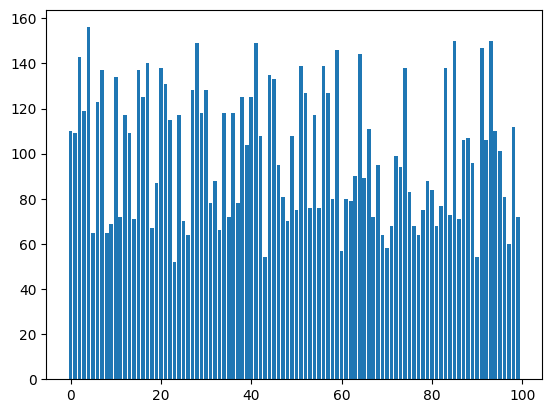

In [3]:
plt.bar(files_class.keys(), files_class.values())

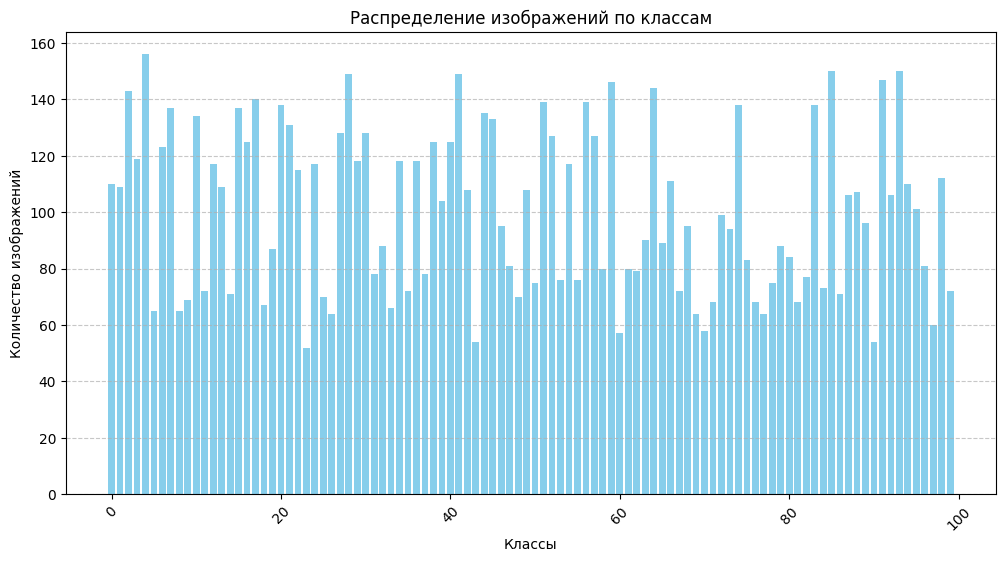

In [4]:
plt.figure(figsize=(12, 6))
plt.bar(files_class.keys(), files_class.values(), color='skyblue')
plt.xlabel("Классы")
plt.ylabel("Количество изображений")
plt.title("Распределение изображений по классам")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Есть дисбаланс классов, будем использовать аугментацию и еще какие-нибудь эвристики, чтобы немного сбалансировать


77
13
89
62
16
57
79
84
6
29


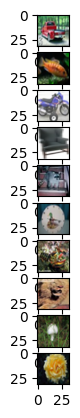

In [2]:
fig, axes = plt.subplots(10)

for id in range(10):
  cls = random.randint(0, 100)
  path = os.path.join('train', f"{cls}")
  files = glob.glob(f"{path}/*.png")
  filename = files[0]
  img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
  axes[id].imshow(img)
  print(cls)

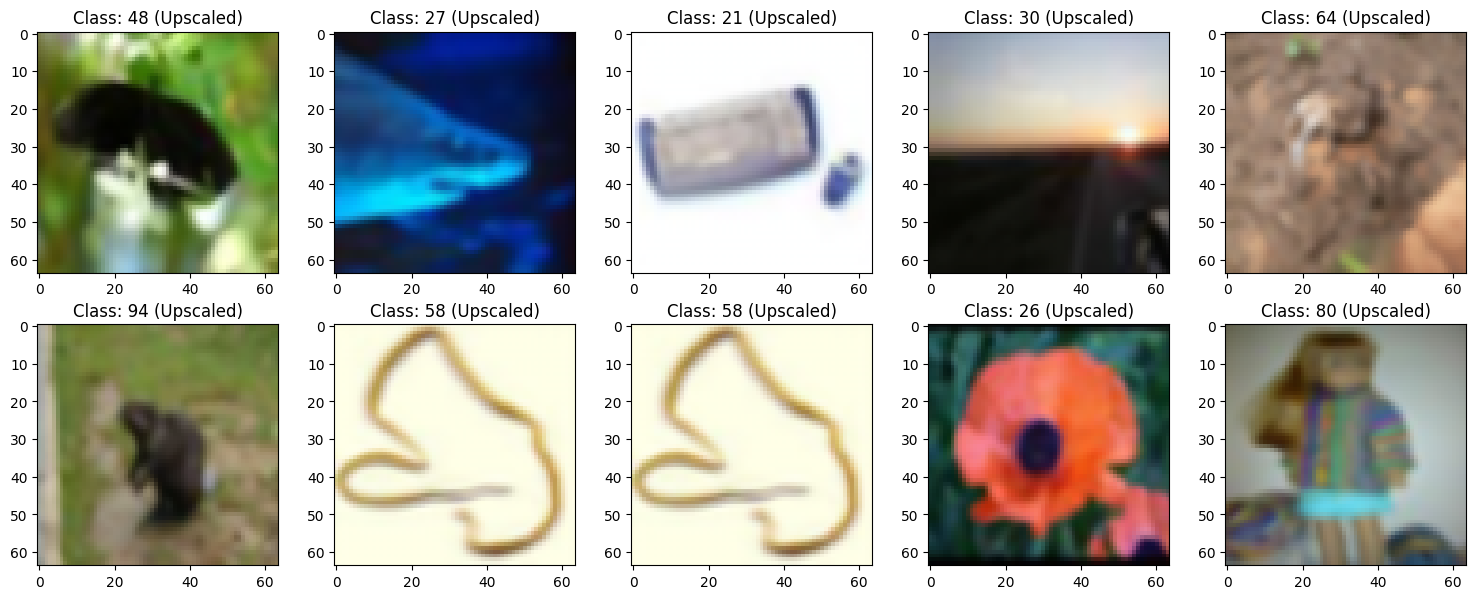

In [3]:
def upscale_image(image, model_path="EDSR_x2.pb", model_name="edsr", scale=2):
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(model_path)
    sr.setModel(model_name, scale)
    return sr.upsample(image)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for id in range(10):
    cls = random.randint(0, 100)
    path = os.path.join('train', f"{cls}")
    files = glob.glob(f"{path}/*.png")

    filename = files[0]
    img = cv2.imread(filename)

    # Увеличиваем изображение
    img_upscaled = upscale_image(img)

    # Конвертируем для отображения
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_upscaled_rgb = cv2.cvtColor(img_upscaled, cv2.COLOR_BGR2RGB)

    # Отображаем результат
    axes[id].imshow(img_upscaled_rgb)
    axes[id].set_title(f"Class: {cls} (Upscaled)")

    # Сохраняем результат
    output_path = f"upscaled_cls_{cls}.png"
    cv2.imwrite(output_path, img_upscaled)

plt.tight_layout()
plt.show()

In [ ]:
def upscale_image(image, model_path, model_name, scale):
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(model_path)
    sr.setModel(model_name, scale)
    return sr.upsample(image)

plt.figure(figsize=(20, 15))

for id in range(10):
    cls = random.randint(0, 100)
    path = os.path.join('train', f"{cls}")
    files = glob.glob(f"{path}/*.png")

    filename = files[0]
    img = cv2.imread(filename)

    # Увеличение в 6 раз (сначала x2, потом x3)
    img_x2 = upscale_image(img, "EDSR_x2.pb", "edsr", 2)
    img_x6 = upscale_image(img_x2, "EDSR_x3.pb", "edsr", 3)

    # Конвертация в RGB для отображения
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_x6_rgb = cv2.cvtColor(img_x6, cv2.COLOR_BGR2RGB)

    # Билинейное увеличение для сравнения
    img_bilinear = cv2.resize(img, None, fx=6, fy=6, interpolation=cv2.INTER_LINEAR)
    img_bilinear_rgb = cv2.cvtColor(img_bilinear, cv2.COLOR_BGR2RGB)

    # Вывод результатов
    plt.subplot(10, 3, 3*id + 1)
    plt.imshow(img_rgb)
    plt.title(f"Original\n{img.shape[1]}x{img.shape[0]}")
    plt.axis('off')

    plt.subplot(10, 3, 3*id + 2)
    plt.imshow(img_bilinear_rgb)
    plt.title(f"Bilinear 6x\n{img_bilinear.shape[1]}x{img_bilinear.shape[0]}")
    plt.axis('off')

    plt.subplot(10, 3, 3*id + 3)
    plt.imshow(img_x6_rgb)
    plt.title(f"EDSR 6x\n{img_x6.shape[1]}x{img_x6.shape[0]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Пересоберем датасет (train) и (test), попробуем увеличить качества с помощью edsr, увеличим размер из 32 на 32 в 192 на 192.

In [9]:
# import os
# import cv2
# import glob
# from tqdm import tqdm

# def upscale_image(image, model_path, model_name, scale):
#     """Увеличение изображения с помощью EDSR"""
#     try:
#         sr = cv2.dnn_superres.DnnSuperResImpl_create()
#         sr.readModel(model_path)
#         sr.setModel(model_name, scale)
#         return sr.upsample(image)

# def process_dataset(input_dir="train", output_dir="train_edsr", scale=6):

#     os.makedirs(output_dir, exist_ok=True)

#     for cls in tqdm(range(0, 100), desc="Обработка классов"):
#         class_dir = os.path.join(input_dir, str(cls))
#         output_class_dir = os.path.join(output_dir, str(cls))
#         os.makedirs(output_class_dir, exist_ok=True)

#         # Обрабатываем все изображения класса
#         for img_path in glob.glob(os.path.join(class_dir, "*.png")):
#             try:
#                 img = cv2.imread(img_path)
#                 if img is None:
#                     continue

#                 # Каскадное увеличение (2x → 3x = 6x)
#                 img_x2 = upscale_image(img, "EDSR_x2.pb", "edsr", 2)
#                 if img_x2 is None:
#                     continue

#                 img_x6 = upscale_image(img_x2, "EDSR_x3.pb", "edsr", 3)
#                 if img_x6 is None:
#                     continue

#                 # Сохраняем результат
#                 filename = os.path.basename(img_path)
#                 output_path = os.path.join(output_class_dir, filename)
#                 cv2.imwrite(output_path, img_x6)


#     print(f"\nОбработка завершена! Результаты сохранены в {output_dir}")

# # Запускаем обработку
# process_dataset()
# import cv2
# import glob
# import os
# from tqdm import tqdm

# def upscale_image(image, model_path, model_name, scale):
#     """Увеличение изображения с помощью EDSR"""
#     sr = cv2.dnn_superres.DnnSuperResImpl_create()
#     sr.readModel(model_path)
#     sr.setModel(model_name, scale)
#     return sr.upsample(image)

# def process_test_dataset(input_dir="test", output_dir="test_edsr", scale=6):
#     os.makedirs(output_dir, exist_ok=True)
#     image_paths = glob.glob(os.path.join(input_dir, "*.png"))
#     for img_path in tqdm(image_paths, desc="Обработка тестовых изображений"):
#         img = cv2.imread(img_path)

#         img_x2 = upscale_image(img, "EDSR_x2.pb", "edsr", 2)
#         img_x6 = upscale_image(img_x2, "EDSR_x3.pb", "edsr", 3)

#         filename = os.path.basename(img_path)
#         output_path = os.path.join(output_dir, filename)
#         cv2.imwrite(output_path, img_x6)
# # process_test_dataset(input_dir="test", output_dir="test_edsr")


У нас 100 классов, посмотрев на представителей классов, могу сказать, что я сама далеко не всегда, могу понять, что изображено на картинках


In [ ]:
# !pip install albumentations

# 2) Проанализировать хороший аугментационный пайплайн с помощью albumentations. Собрать подготовленный пайплайн в погрузчик данных на модель. (1.5 балла).

С помощью Дипсика и немного моей обработки мы получили параметры для нормализации: Mean (R, G, B): [0.50691125 0.48691937 0.44028778]
Std (R, G, B): [0.2668507  0.25536751 0.27503409], код решила не вставлять из-за его сгенирированности


Смотрим как работают разные аугментации, чтобы потом собрать пайплайн

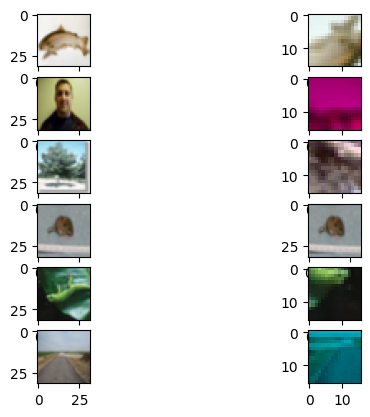

In [ ]:
fig, axes = plt.subplots(6, 2)

aug = A.Compose(
    [
      A.HorizontalFlip(p=.5),
      A.VerticalFlip(p=.5),
      A.ShiftScaleRotate(shift_limit=.08),
      A.RGBShift(r_shift_limit=20, p=.5),
      A.RandomCrop(height=16, width=16, p=.5),
      A.RandomBrightnessContrast(),
      A.RandomRotate90(),
      A.Blur(blur_limit=3),
      # A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared",
      #           approximation=1.0,
      #           noise_params={"mean_range": (0.0, 0.0), "std_range": (0.1, 0.1)},
      #           p=.5),
      A.ChannelDropout(p=.3),
      # A.AutoContrast(p=.5)
      # A.Normalize(mean=(0.50691125 0.48691937 0.44028778), std=(0.2668507  0.25536751 0.27503409)),
      # ToTensorV2()
    ]
  )

for id in range(6):
  cls = random.randint(0, 100)
  path = os.path.join('train', f"{cls}")
  files = glob.glob(f"{path}/*.png")
  filename = files[0]
  img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
  img_aug = aug(image=img)['image']
  axes[id][0].imshow(img)
  axes[id][1].imshow(img_aug)

Пишем какую-то модель, чтобы понять какой пайплайн будет хорошим

In [11]:
class CIFAR100Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 100)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [4]:
class CustomMultiClassLoss(nn.Module):
    def __init__(self):
        super(CustomMultiClassLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        loss = self.ce(outputs, targets)
        penalty = 0.001 * torch.mean(torch.sum(outputs**2, dim=1))
        return loss + penalty
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, val_metric, model):
        score = -val_metric  # Assuming lower loss is better
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0
def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs:
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self, filenames, aug=None):
    self.filenames = filenames
    self.aug = aug

  def __getitem__(self, idx):
    img = cv2.cvtColor(cv2.imread(self.filenames[idx]), cv2.COLOR_BGR2RGB)
    label = self.filenames[idx].split('/')[-2]
    if self.aug:
      img = self.aug(image=img)['image']
    label = torch.tensor(int(label))
    return img, label

  def __len__(self):
    return len(self.filenames)

In [ ]:
augment_norm = A.Compose([
    A.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ToTensorV2()
])

augment_basic = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ToTensorV2()
])

augment_advanced = A.Compose([
      A.HorizontalFlip(p=.5),
      A.VerticalFlip(p=.5),
      A.ShiftScaleRotate(shift_limit=.08),
      A.RGBShift(r_shift_limit=20, p=.5),
     #A.RandomCrop(height=16, width=16, p=.5),
      A.RandomBrightnessContrast(),
      A.RandomRotate90(),
      A.Blur(blur_limit=3),
      # A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.1, 0.1)},p=.5),
      A.ChannelDropout(p=.3),
      # A.AutoContrast(p=.5),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
])


In [ ]:
    # A.HorizontalFlip(p=0.7),
    # A.VerticalFlip(p=0.3),
    # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    # A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    # A.Blur(blur_limit=2, p=0.3),
    # A.GaussNoise(var_limit=(0.001, 0.005), p=0.3),
    # A.CoarseDropout(max_holes=1, max_height=16, max_width=16, p=0.5),

In [ ]:
filenames = glob.glob(os.path.join('data', 'data', 'train') + "/**/*.png", recursive=True)
dataset_base = MyDataset(filenames, augment_norm)
train_size = int(.8 * len(dataset_base))
val_size = len(dataset_base) - train_size
train_dataset, val_dataset = random_split(dataset_base, [train_size, val_size])
train_loader_upscale = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(val_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model_cifar =CIFAR100Model().to(device)

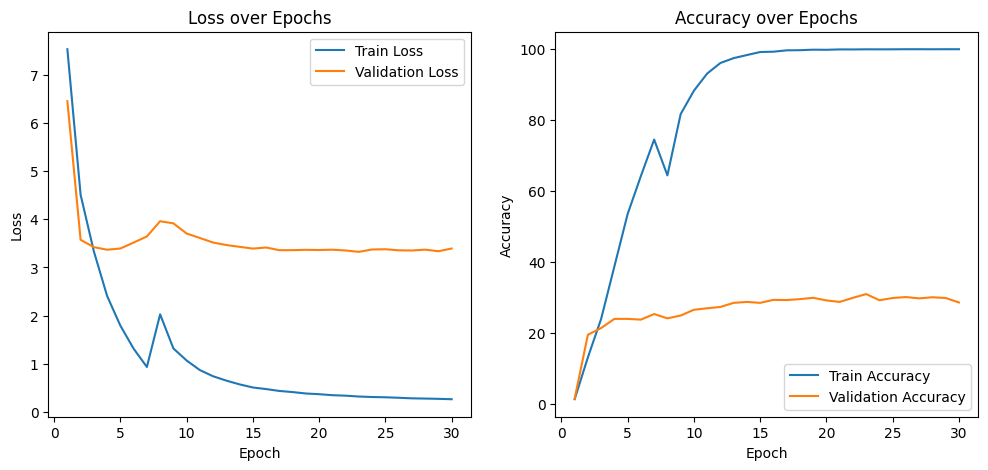

100%|██████████| 30/30 [03:05<00:00,  6.19s/it]

Epoch 30/30 | LR: 0.001000 | Train Loss: 0.2647, Train Acc: 100.00% | Val Loss: 3.3939, Val Acc: 28.60%
EarlyStopping counter: 7 out of 3
EarlyStopping counter: 7 out of 3
Epoch 30/30 | LR: 1.00e-03 | Train Loss: 0.265 Train Acc: 100.00% | Val Acc: 28.60%


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cifar.classifier.parameters(), lr=0.0001)
base_lr = 0.01
num_epochs = 30
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model_cifar.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_cifar(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model_cifar.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_cifar(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_cifar, 'best_model_cifar.pth')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model_cifar)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model_cifar)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model_cifar.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
        f"Train Loss: {train_loss:.3f} "
        f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%"
    )

Модель без какой либо аугментации жестко переобучилась, смотрим дальше.

Смотрим с самой простой аугментацией

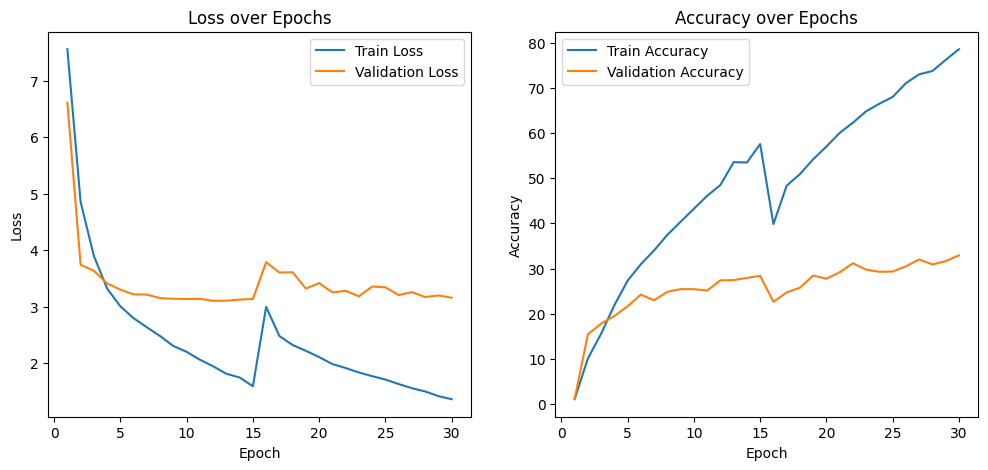

100%|██████████| 30/30 [01:44<00:00,  3.50s/it]

Epoch 30/30 | LR: 0.001000 | Train Loss: 1.3656, Train Acc: 78.52% | Val Loss: 3.1615, Val Acc: 32.91%
Epoch 30/30 | LR: 1.00e-03 | Train Loss: 1.366 Train Acc: 78.52% | Val Acc: 32.91%


In [ ]:
filenames = glob.glob(os.path.join('data', 'data', 'train') + "/**/*.png", recursive=True)
dataset_basic = MyDataset(filenames, augment_basic)
train_size = int(.8 * len(dataset_basic))
val_size = len(dataset_basic) - train_size
train_dataset, val_dataset = random_split(dataset_basic, [train_size, val_size])
train_loader_upscale = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(val_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model_cifar =CIFAR100Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cifar.classifier.parameters(), lr=0.0001)
base_lr = 0.01
num_epochs = 30
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model_cifar.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_cifar(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model_cifar.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_cifar(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_cifar, 'best_model_cifar_basic.pth')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model_cifar)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model_cifar)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model_cifar.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
        f"Train Loss: {train_loss:.3f} "
        f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%"
    )

Ого, уже лучше, что же будет дальше?

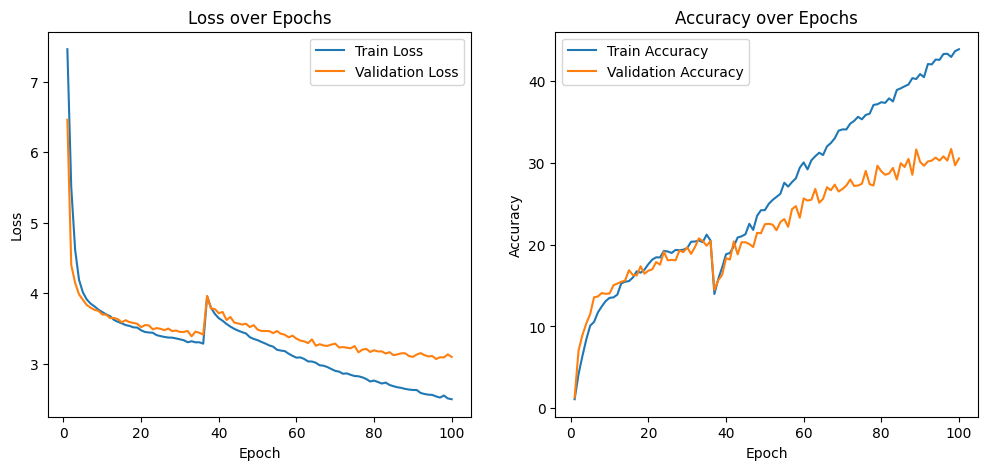

100%|██████████| 100/100 [07:56<00:00,  4.76s/it]

Epoch 100/100 | LR: 0.001000 | Train Loss: 2.4984, Train Acc: 43.90% | Val Loss: 3.0985, Val Acc: 30.55%
EarlyStopping counter: 4 out of 3
EarlyStopping counter: 4 out of 3
Epoch 100/100 | LR: 1.00e-03 | Train Loss: 2.498 Train Acc: 43.90% | Val Acc: 30.55%


In [ ]:
dataset_advanced = MyDataset(filenames, augment_advanced)
train_size = int(.8 * len(dataset_basic))
val_size = len(dataset_advanced) - train_size
train_dataset, val_dataset = random_split(dataset_advanced, [train_size, val_size])
train_loader_upscale = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(val_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model_cifar =CIFAR100Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cifar.classifier.parameters(), lr=0.0001)
base_lr = 0.01
num_epochs = 100
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model_cifar.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_cifar(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model_cifar.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_cifar(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_cifar, 'best_model_cifar_advanced.pth')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model_cifar)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model_cifar)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model_cifar.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
        f"Train Loss: {train_loss:.3f} "
        f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%"
    )

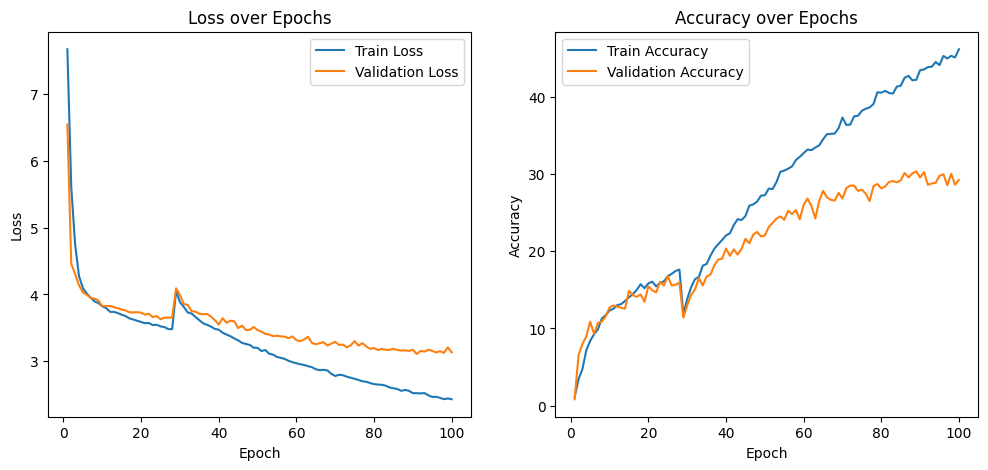

100%|██████████| 100/100 [10:04<00:00,  6.04s/it]

Epoch 100/100 | LR: 0.001000 | Train Loss: 2.4313, Train Acc: 46.15% | Val Loss: 3.1340, Val Acc: 29.23%
EarlyStopping counter: 9 out of 3
EarlyStopping counter: 9 out of 3
Epoch 100/100 | LR: 1.00e-03 | Train Loss: 2.431 Train Acc: 46.15% | Val Acc: 29.23%


In [ ]:
augment_advanced_2 = A.Compose([
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
      A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
     #A.RandomCrop(height=16, width=16, p=.5),
      A.RandomBrightnessContrast(),
      A.RandomRotate90(),
      A.Blur(blur_limit=2, p=0.3),
     # A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.1, 0.1)},p=.5),
      A.ChannelDropout(p=.3),
      A.GaussNoise(var_limit=(0.001, 0.005), p=0.3),
      A.CoarseDropout(max_holes=1, max_height=16, max_width=16, p=0.5),
      A.RandomGamma(gamma_limit=(80, 120), p=0.5),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
])
dataset_advanced_2 = MyDataset(filenames, augment_advanced_2)
train_size = int(.8 * len(dataset_advanced_2))
val_size = len(dataset_advanced_2) - train_size
train_dataset, val_dataset = random_split(dataset_advanced_2, [train_size, val_size])
train_loader_upscale = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(val_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model_cifar =CIFAR100Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cifar.classifier.parameters(), lr=0.0001)
base_lr = 0.01
num_epochs = 100
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model_cifar.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_cifar(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model_cifar.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_cifar(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_cifar, 'best_model_cifar_advanced_2.pth')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model_cifar)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model_cifar)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model_cifar.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
        f"Train Loss: {train_loss:.3f} "
        f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%"
    )

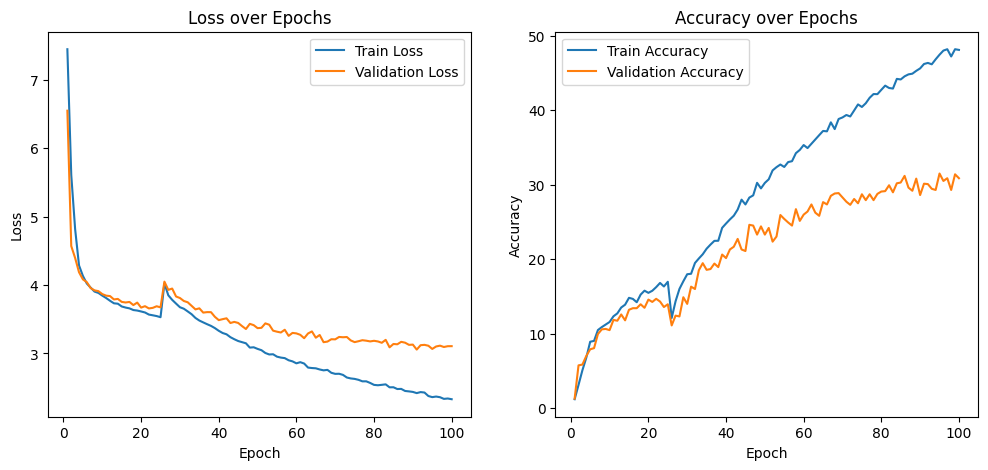

100%|██████████| 100/100 [08:26<00:00,  5.06s/it]

Epoch 100/100 | LR: 0.001000 | Train Loss: 2.3312, Train Acc: 48.09% | Val Loss: 3.1068, Val Acc: 30.86%
EarlyStopping counter: 9 out of 3
EarlyStopping counter: 9 out of 3
Epoch 100/100 | LR: 1.00e-03 | Train Loss: 2.331 Train Acc: 48.09% | Val Acc: 30.86%


In [ ]:
augment_advanced_3 = A.Compose([
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
      A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
     #A.RandomCrop(height=16, width=16, p=.5),
      A.RandomBrightnessContrast(),
      A.RandomRotate90(),
      A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
      #A.Blur(blur_limit=2, p=0.3),
     # A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.1, 0.1)},p=.5),
      A.ChannelDropout(p=.3),
      #A.GaussNoise(var_limit=(0.001, 0.005), p=0.3),
      A.CoarseDropout(max_holes=1, max_height=16, max_width=16, p=0.5),
      A.RandomGamma(gamma_limit=(80, 120), p=0.5),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
])

dataset_advanced_3 = MyDataset(filenames, augment_advanced_3)
train_size = int(.8 * len(dataset_advanced_3))
val_size = len(dataset_advanced_3) - train_size
train_dataset, val_dataset = random_split(dataset_advanced_3, [train_size, val_size])
train_loader_upscale = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(val_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model_cifar =CIFAR100Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cifar.classifier.parameters(), lr=0.0001)
base_lr = 0.01
num_epochs = 100
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model_cifar.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_cifar(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model_cifar.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_cifar(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_cifar, 'best_model_cifar_advanced_3.pth')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model_cifar)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model_cifar)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model_cifar.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
        f"Train Loss: {train_loss:.3f} "
        f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%"
    )

После того как мы посмотрели на разные аугментации, перейдем к построению моделей


**3) Поделить данные на трейн-валидацию, обучить базовую модель (с и без transfer learning) без навороченных аугментаций (только отражение во горизонтали и вертикали) и с навороченными. Попробуйте применить продвинутые методы апскейлинга для подачи модели нужного размера для transfer learning. Проверить результаты моделей с аугментацией на тесте и без. Сделать аугментацию моделей на валидации (или тесте на каггле). Снабдить обучение моделей графиками отрисовки лосей и метрик, шедулерами, свитч лосей (метрик), сохранение лучшей модели, ранней остановкой, вормапом. (4.5 балла)**

**Densenet**

Возьмем модель densenet. так как ее советовали и посмотрим на предобученную модель с базовой аугментацией, а потом посмотрим на не предобученную модель

In [15]:
# предобученная модель
model = models.densenet121(weights=models.DenseNet121_Weights)
for param in model.parameters():
  param.requires_grad = False

num_classes = 100
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Модель готова {device}")

class CustomMultiClassLoss(nn.Module):
    def __init__(self):
        super(CustomMultiClassLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        loss = self.ce(outputs, targets)
        penalty = 0.001 * torch.mean(torch.sum(outputs**2, dim=1))
        return loss + penalty
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, val_metric, model):
        score = -val_metric  # Assuming lower loss is better
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0
def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs:
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /tmp/xdg_cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 45.4MB/s]


Модель готова cuda


In [ ]:
aug_upscale = A.Compose(
    [
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.8),
      A.VerticalFlip(p=.8),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet = MyDataset(filenames, aug_upscale)
train_size = int(.8 * len(dataset_advanced_densnet))
val_size = len(dataset_advanced_densnet) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet, [train_size, val_size])
train_loader_upscale = DataLoader(train_dataset_upscale, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(val_dataset_upscale, batch_size=64, shuffle=False)

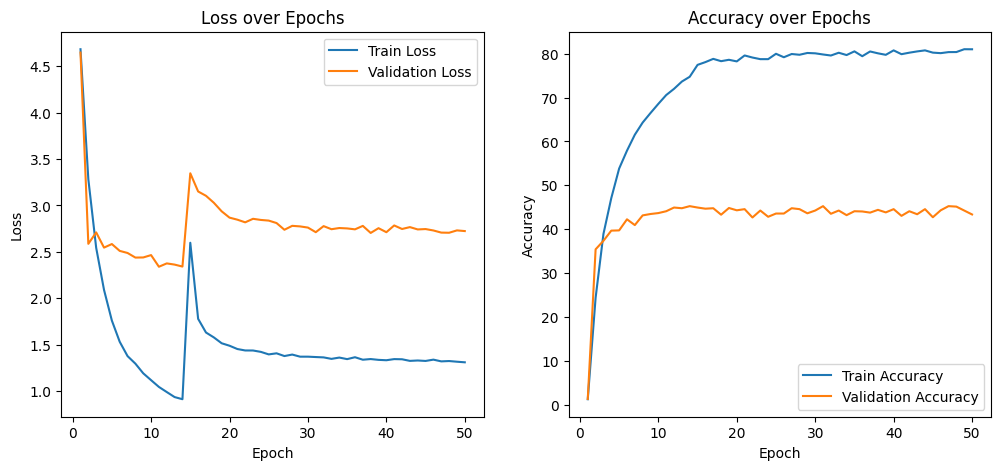

 50%|█████     | 50/100 [25:35<25:23, 30.47s/it]

Epoch 50/100 | LR: 0.001000 | Train Loss: 1.3096, Train Acc: 80.98% | Val Loss: 2.7234, Val Acc: 43.38%
EarlyStopping counter: 12 out of 3
EarlyStopping counter: 12 out of 3


 50%|█████     | 50/100 [25:59<25:59, 31.18s/it]


KeyboardInterrupt: 

In [ ]:
base_lr = 0.01
num_epochs = 100
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_advanced_densnet.pth')
        print(f'Best Val Acc: {best_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

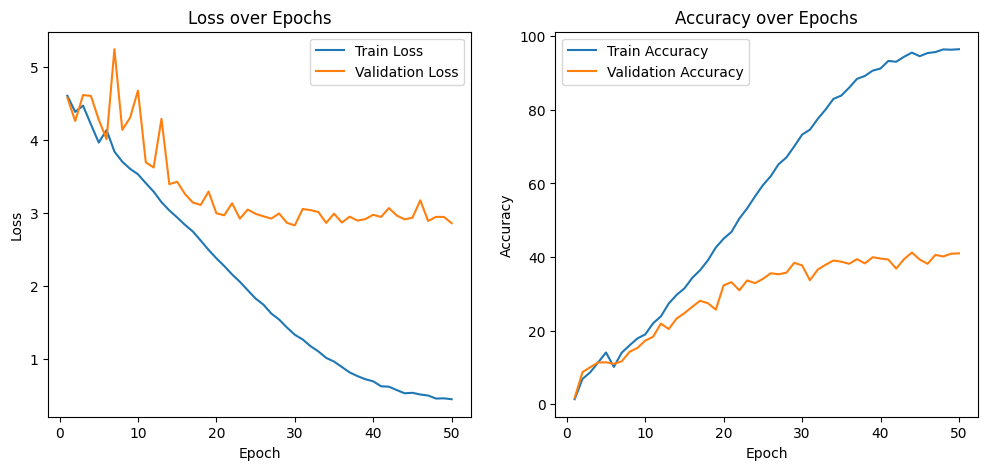

100%|██████████| 50/50 [50:28<00:00, 60.57s/it]

Epoch 50/50 | LR: 0.001000 | Train Loss: 0.4502, Train Acc: 96.46% | Val Loss: 2.8625, Val Acc: 41.01%
EarlyStopping counter: 20 out of 3
EarlyStopping counter: 20 out of 3


In [ ]:
# не предобученная модель
model = models.densenet121(weights=None)

num_classes = 100
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Модель готова {device}")
aug_upscale = A.Compose(
    [
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.8),
      A.VerticalFlip(p=.8),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_2 = MyDataset(filenames, aug_upscale)
train_size = int(.8 * len(dataset_advanced_densnet_2))
val_size = len(dataset_advanced_densnet_2) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_2, [train_size, val_size])
train_loader_upscale = DataLoader(train_dataset_upscale, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(val_dataset_upscale, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 50
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_advanced_densnet_2.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
# predictions.csv

In [ ]:
fname = './test.zip'
path = './'

with zipfile.ZipFile(fname, 'r') as zf:
    for entry in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(entry, path)
        except zipfile.error as e:
            pass


Extracting : 100%|██████████| 3879/3879 [01:10<00:00, 54.88it/s] 


In [ ]:
# model = models.densenet121(weights=None)
# num_classes = 100
# model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# model = torch.load('best_model_advanced_densnet.pth', map_location='cpu')  # Загружаем всю модель
# model.eval()

Получаем 0.33177!! на тесте

теперь попробуем навороченную аугментацию

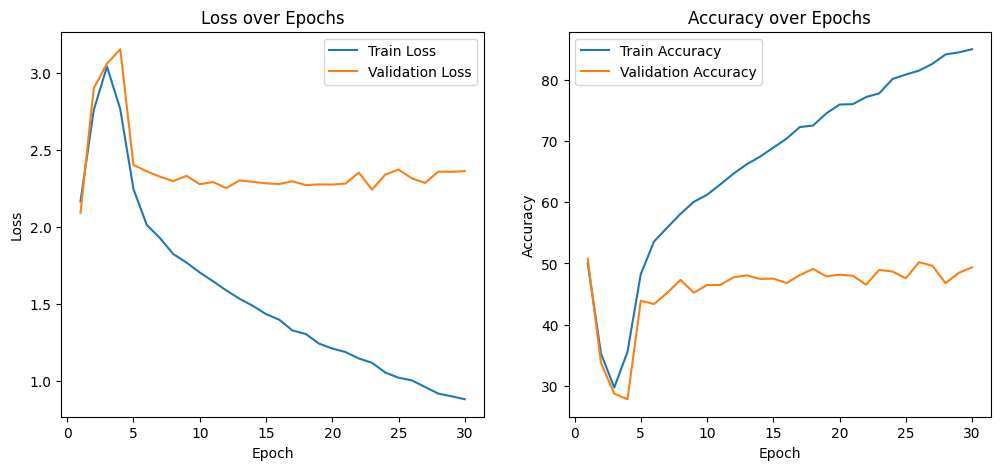

100%|██████████| 30/30 [34:41<00:00, 69.38s/it]

Epoch 30/30 | LR: 0.001000 | Train Loss: 0.8839, Train Acc: 85.02% | Val Loss: 2.3644, Val Acc: 49.37%
EarlyStopping counter: 7 out of 3
EarlyStopping counter: 7 out of 3


In [ ]:
aug_upscale = A.Compose(
    [
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
      A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
     #A.RandomCrop(height=16, width=16, p=.5),
      A.RandomBrightnessContrast(),
      A.RandomRotate90(),
      A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
      #A.Blur(blur_limit=2, p=0.3),
     # A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.1, 0.1)},p=.5),
      A.ChannelDropout(p=.3),
      #A.GaussNoise(var_limit=(0.001, 0.005), p=0.3),
      A.CoarseDropout(max_holes=1, max_height=16, max_width=16, p=0.5),
      A.RandomGamma(gamma_limit=(80, 120), p=0.5),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale = MyDataset(filenames, aug_upscale)
train_size = int(.8 * len(dataset_advanced_densnet_upscale))
val_size = len(dataset_advanced_densnet_upscale) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale, [train_size, val_size])
train_loader_upscale = DataLoader(train_dataset_upscale, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(val_dataset_upscale, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 30
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_advanced_densnet_upsckl.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
# predictions_best_model_advanced_densnet_upsckl.pth.csv

0.42031 !!!! best_model_advanced_densnet_upsckl.pth, перебила свой же счет в лидерборде, пробуем обработку тестовых данных и посмотрим что будет на тесте с продвинутым методом апсейлинга

Добавим методы апсейлинга

**densnet121**

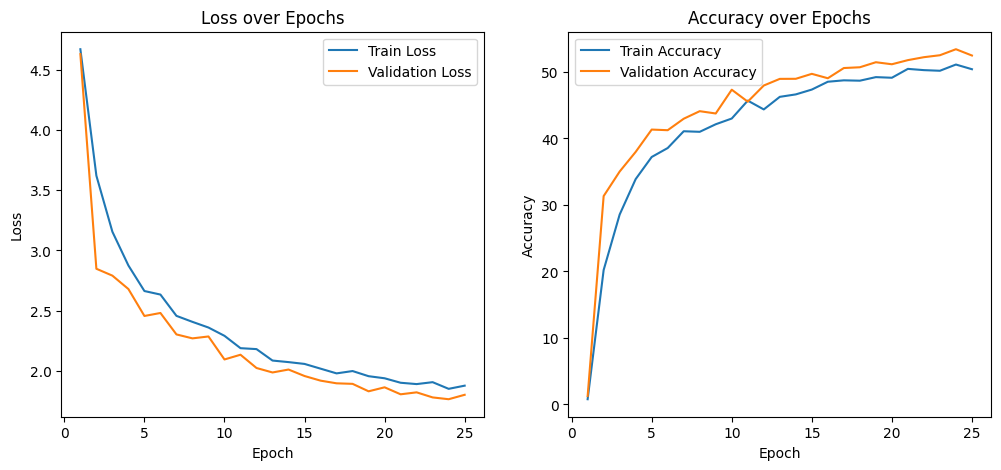

100%|██████████| 25/25 [30:43<00:00, 73.73s/it]

Epoch 25/25 | LR: 0.000657 | Train Loss: 1.8790, Train Acc: 50.41% | Val Loss: 1.8033, Val Acc: 52.47%
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 1 out of 3


In [ ]:
filenames = glob.glob(os.path.join('data', 'data', 'train') + "/**/*.png", recursive=True)
model = models.densenet121(weights=models.DenseNet121_Weights)
for param in model.parameters():
  param.requires_grad = False

num_classes = 100
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Модель готова {device}")
aug_upscale_plus = A.Compose(
    [
      A.SmallestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC),
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
      A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
     #A.RandomCrop(height=16, width=16, p=.5),
      A.RandomBrightnessContrast(),
      A.RandomRotate90(),
      A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
      #A.Blur(blur_limit=2, p=0.3),
     # A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.1, 0.1)},p=.5),
      A.ChannelDropout(p=.3),
      #A.GaussNoise(var_limit=(0.001, 0.005), p=0.3),
      A.CoarseDropout(max_holes=1, max_height=16, max_width=16, p=0.5),
      A.RandomGamma(gamma_limit=(80, 120), p=0.5),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 25
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_advanced_densnet_upscale_plus.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
# best_model_advanced_densnet_upscale_plus.csv
#Причем на тесте я аугментацию такую же накрутила, как и на трейне

ну так, на тесте 0.38

**Высший апскейлинг, как я поняла**

я пересобрала датасет, тепрь у меня изображения 192 на 192 с улучшенным качеством

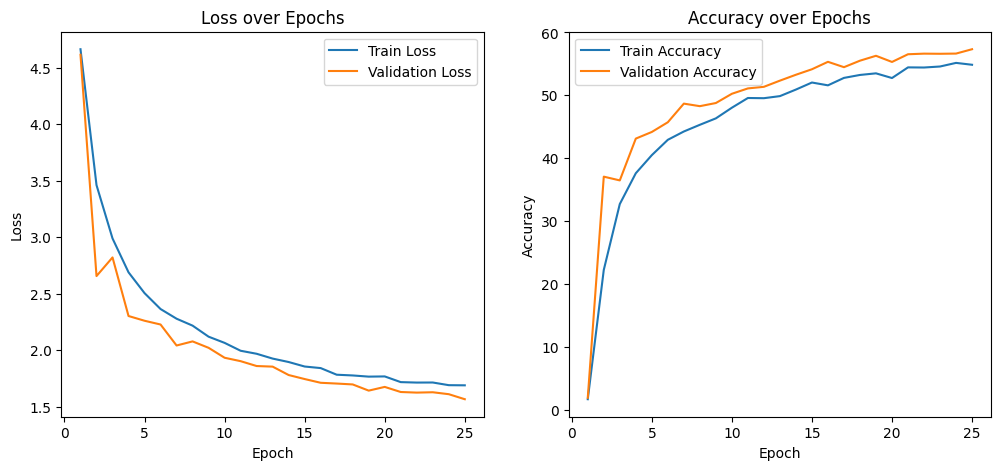

100%|██████████| 25/25 [43:42<00:00, 104.90s/it]

Epoch 25/25 | LR: 0.000657 | Train Loss: 1.6890, Train Acc: 54.86% | Val Loss: 1.5660, Val Acc: 57.33%


In [ ]:
filenames = glob.glob(os.path.join('train_edsr') + "/**/*.png", recursive=True)
model = models.densenet121(weights=models.DenseNet121_Weights)
for param in model.parameters():
  param.requires_grad = False

num_classes = 100
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Модель готова {device}")
aug_upscale_plus = A.Compose(
    [
      #A.SmallestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC),
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
      A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
     #A.RandomCrop(height=16, width=16, p=.5),
      A.RandomBrightnessContrast(),
      A.RandomRotate90(),
      A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
      #A.Blur(blur_limit=2, p=0.3),
     # A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.1, 0.1)},p=.5),
      A.ChannelDropout(p=.3),
      #A.GaussNoise(var_limit=(0.001, 0.005), p=0.3),
      A.CoarseDropout(max_holes=1, max_height=16, max_width=16, p=0.5),
      A.RandomGamma(gamma_limit=(80, 120), p=0.5),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 25
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_advanced_densnet_edsr.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
        
# best_model_advanced_densnet_edsrrr.csv

на тесте 0.55


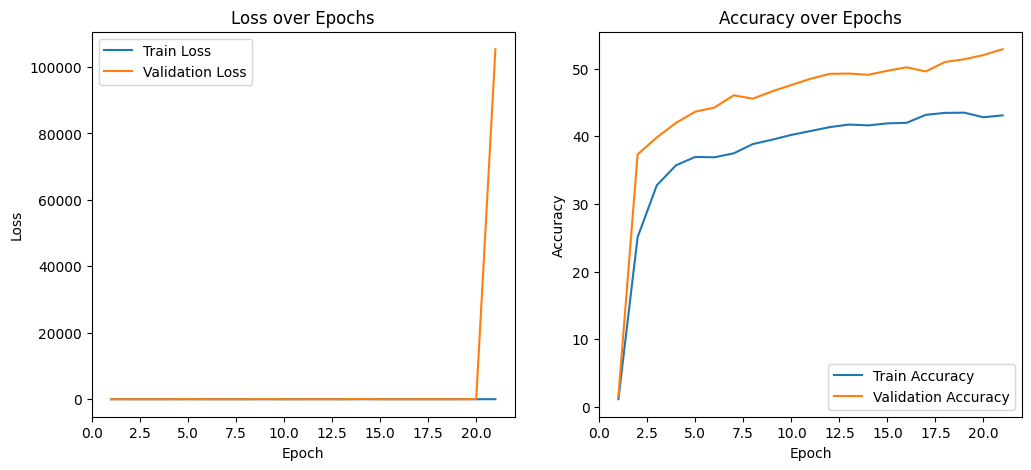

 84%|████████▍ | 21/25 [34:04<06:17, 94.31s/it]

Epoch 21/25 | LR: 0.001000 | Train Loss: 2.8120, Train Acc: 43.09% | Val Loss: 105362.7458, Val Acc: 52.85%
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 1 out of 3


 84%|████████▍ | 21/25 [34:57<06:39, 99.90s/it]


KeyboardInterrupt: 

In [7]:
filenames = glob.glob(os.path.join('train_edsr') + "/**/*.png", recursive=True)

model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT) 

for param in model.parameters():
    param.requires_grad = False
num_classes = 100
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Модель готова {device}")
aug_upscale_plus = A.Compose(
    [
      #A.SmallestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC),
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
      A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
     #A.RandomCrop(height=16, width=16, p=.5),
      A.RandomBrightnessContrast(),
      A.RandomRotate90(),
      A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
      #A.Blur(blur_limit=2, p=0.3),
     # A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.1, 0.1)},p=.5),
      A.ChannelDropout(p=.3),
      #A.GaussNoise(var_limit=(0.001, 0.005), p=0.3),
      A.CoarseDropout(max_holes=1, max_height=16, max_width=16, p=0.5),
      A.RandomGamma(gamma_limit=(80, 120), p=0.5),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 25
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_efficient_edsr.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

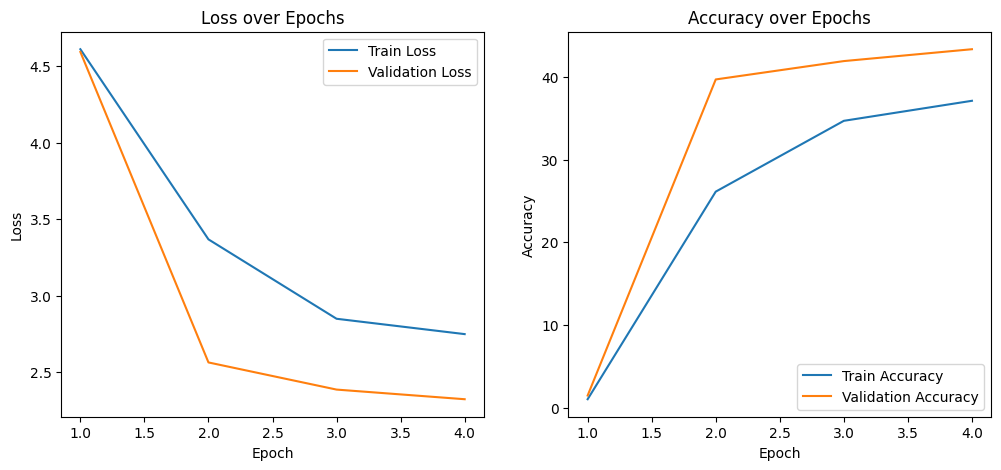

 16%|█▌        | 4/25 [07:50<41:05, 117.39s/it]

Epoch 4/25 | LR: 0.006003 | Train Loss: 2.7475, Train Acc: 37.14% | Val Loss: 2.3215, Val Acc: 43.38%


 16%|█▌        | 4/25 [08:04<42:21, 121.05s/it]


KeyboardInterrupt: 

In [8]:
filenames = glob.glob(os.path.join('train_edsr') + "/**/*.png", recursive=True)

model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)  # или _M, _L для больших версий

for param in model.parameters():
    param.requires_grad = False
num_classes = 100
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Модель готова {device}")
aug_upscale_plus = A.Compose(
    [
      #A.SmallestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC),
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
      A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
     #A.RandomCrop(height=16, width=16, p=.5),
      A.RandomBrightnessContrast(),
      A.RandomRotate90(),
      A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
      #A.Blur(blur_limit=2, p=0.3),
     # A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.1, 0.1)},p=.5),
      A.ChannelDropout(p=.3),
      #A.GaussNoise(var_limit=(0.001, 0.005), p=0.3),
      A.CoarseDropout(max_holes=1, max_height=16, max_width=16, p=0.5),
      A.RandomGamma(gamma_limit=(80, 120), p=0.5),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 25
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_efficient_M_edsr.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

попробуем взять другую модель и посмотреть, что выйдет 

утром посмотреть

In [26]:
filenames = glob.glob(os.path.join('train_edsr') + "/**/*.png", recursive=True)

model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.DEFAULT)  # или _M, _L для больших версий

for param in model.parameters():
    param.requires_grad = False
num_classes = 100
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Модель готова {device}")
aug_upscale_plus = A.Compose(
    [
      #A.SmallestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC),
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
     #  # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
     #  A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
     # #A.RandomCrop(height=16, width=16, p=.5),
     #  A.RandomBrightnessContrast(),
      # A.RandomRotate90(p = .4),
     #  A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
     #  #A.Blur(blur_limit=2, p=0.3),
     # # A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.1, 0.1)},p=.5),
     #  A.ChannelDropout(p=.3),
     #  #A.GaussNoise(var_limit=(0.001, 0.005), p=0.3),
     #  A.CoarseDropout(max_holes=1, max_height=16, max_width=16, p=0.5),
     #  A.RandomGamma(gamma_limit=(80, 120), p=0.5),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 50
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_efficient_L_edsr.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
# best_model_efficient_L_edsr.csv

Модель готова cuda


  0%|          | 0/50 [01:54<?, ?it/s]


KeyboardInterrupt: 

0.59947 пока мой самый высокий результат), поменяла количество эпох - 0.60


In [6]:
class CustomMultiClassLoss(nn.Module):
    def __init__(self):
        super(CustomMultiClassLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        loss = self.ce(outputs, targets)
        penalty = 0.001 * torch.mean(torch.sum(outputs**2, dim=1))
        return loss + penalty
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, val_metric, model):
        score = -val_metric  # Assuming lower loss is better
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0
def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs:
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer

**densenet201**

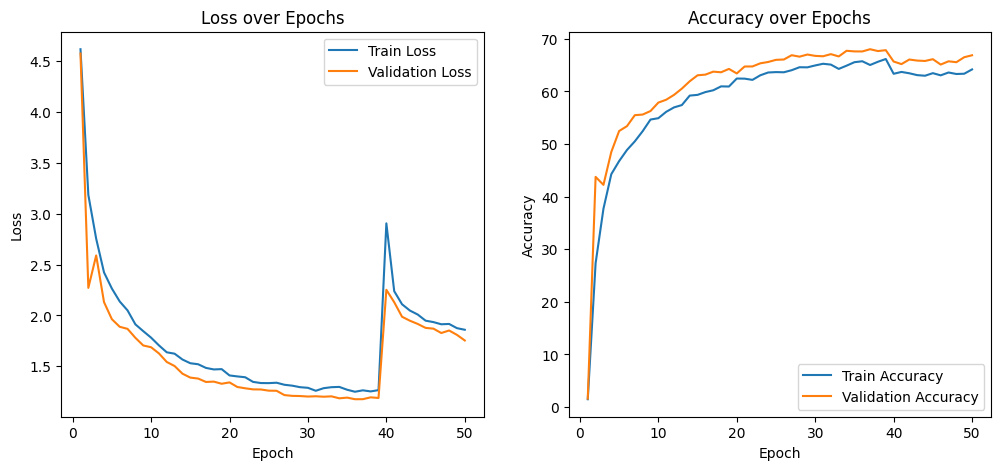

100%|██████████| 50/50 [1:34:44<00:00, 113.70s/it]

Epoch 50/50 | LR: 0.001000 | Train Loss: 1.8595, Train Acc: 64.19% | Val Loss: 1.7542, Val Acc: 66.88%
EarlyStopping counter: 14 out of 3


In [14]:
filenames = glob.glob(os.path.join('train_edsr') + "/**/*.png", recursive=True)
model = models.densenet201(weights=models.DenseNet201_Weights)
for param in model.parameters():
  param.requires_grad = False

num_classes = 100
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Модель готова {device}")
aug_upscale_plus = A.Compose(
    [
      #A.SmallestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC),
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
      A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
     #A.RandomCrop(height=16, width=16, p=.5),
      A.RandomBrightnessContrast(),
      A.RandomRotate90(),
      A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
      #A.Blur(blur_limit=2, p=0.3),
     # A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.1, 0.1)},p=.5),
      A.ChannelDropout(p=.3),
      #A.GaussNoise(var_limit=(0.001, 0.005), p=0.3),
      A.CoarseDropout(max_holes=1, max_height=16, max_width=16, p=0.5),
      A.RandomGamma(gamma_limit=(80, 120), p=0.5),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 50
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_advanced_densnet_201_edsr.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
# best_model_advanced_densnet_201_edsr.csv

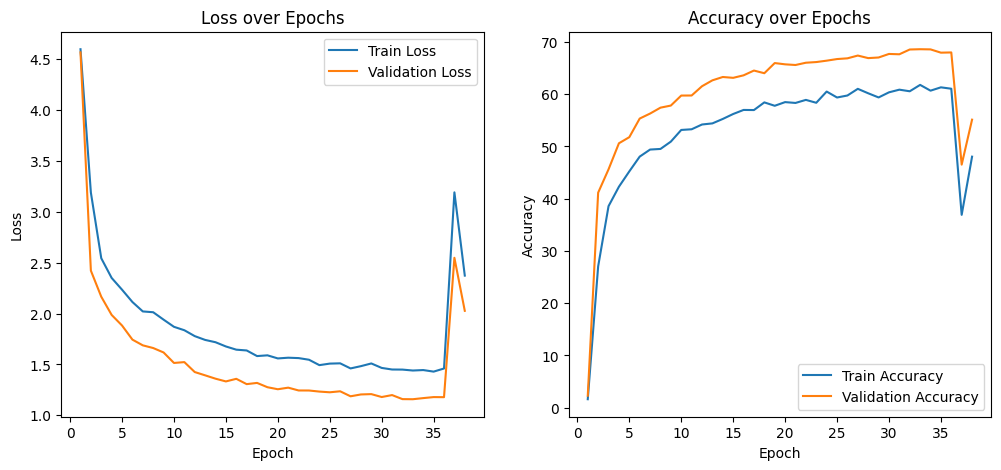

 76%|███████▌  | 38/50 [1:47:05<31:18, 156.55s/it]

Epoch 38/50 | LR: 0.001000 | Train Loss: 2.3729, Train Acc: 48.05% | Val Loss: 2.0270, Val Acc: 55.14%


 76%|███████▌  | 38/50 [1:48:49<34:21, 171.82s/it]


KeyboardInterrupt: 

In [9]:
filenames = glob.glob(os.path.join('train_edsr') + "/**/*.png", recursive=True)

model = models.wide_resnet50_2(weights=models.Wide_ResNet50_2_Weights.DEFAULT)  # или _M, _L для больших версий

num_features = model.fc.in_features

# Заменяем финальный слой (fc) на новый классификатор
model.fc = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_features, num_classes)
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Модель готова {device}")
aug_upscale_plus = A.Compose(
    [
      #A.SmallestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC),
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
      A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
     #A.RandomCrop(height=16, width=16, p=.5),
      A.RandomBrightnessContrast(),
      A.RandomRotate90(),
      A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
      #A.Blur(blur_limit=2, p=0.3),
     # A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.1, 0.1)},p=.5),
      A.ChannelDropout(p=.3),
      #A.GaussNoise(var_limit=(0.001, 0.005), p=0.3),
      A.CoarseDropout(max_holes=1, max_height=16, max_width=16, p=0.5),
      A.RandomGamma(gamma_limit=(80, 120), p=0.5),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 50
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_wide_resnet50_2.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

**Балуюсь с заморозкой и разморозкой**

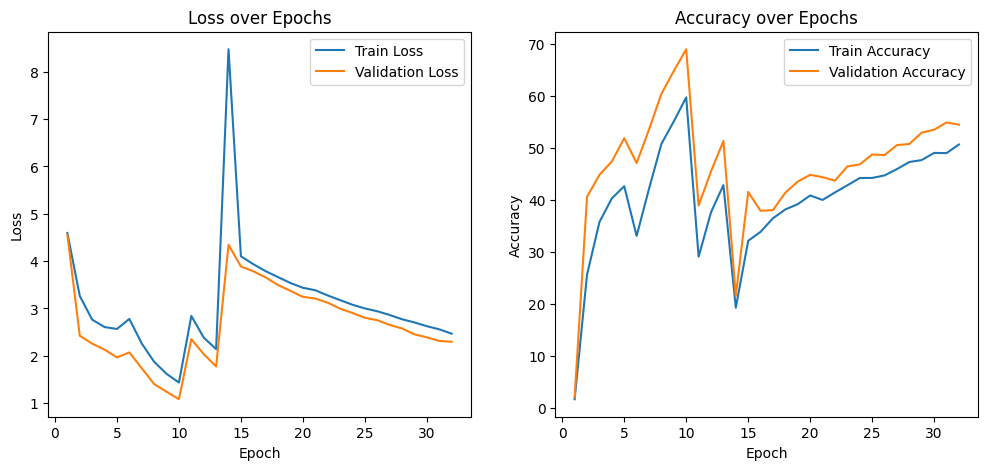

 64%|██████▍   | 32/50 [1:12:31<45:38, 152.14s/it]

Epoch 32/50 | LR: 0.001000 | Train Loss: 2.4668, Train Acc: 50.71% | Val Loss: 2.2956, Val Acc: 54.52%


 64%|██████▍   | 32/50 [1:14:30<41:54, 139.70s/it]


KeyboardInterrupt: 

In [10]:

model = models.wide_resnet50_2(weights=models.Wide_ResNet50_2_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_features, num_classes)
)

# Функция для размораживания слоев
def unfreeze_layers(model, epoch, unfreeze_schedule):
    for unfreeze_epoch, layer_names in unfreeze_schedule:
        if epoch == unfreeze_epoch:
            print(f"\nРазмораживаем слои на эпохе {epoch}: {layer_names}")
            for name, param in model.named_parameters():
                if any(layer_name in name for layer_name in layer_names):
                    param.requires_grad = True

# Расписание размораживания (эпоха, [имена слоев])
unfreeze_schedule = [
    (5, ['layer4']),      # Разморозить последний блок на 5 эпохе
    (10, ['layer3']),     # Разморозить предпоследний блок на 10 эпохе
    (15, ['layer2']),     # Разморозить средний блок на 15 эпохе
    (20, ['layer1']),     # Разморозить начальный блок на 20 эпохе
    (25, ['conv1']),      # Разморозить первый слой на 25 эпохе
]

# Изначально замораживаем все слои, кроме последнего
for name, param in model.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False

# Оптимизатор - теперь будем обновлять только размороженные параметры
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
criterion = nn.CrossEntropyLoss()
# Остальная часть инициализации остается без изменений
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Модель готова {device}")
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 50
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
# В цикле обучения добавляем вызов unfreeze_layers перед обучением
for epoch in tqdm(range(num_epochs)):
    # Размораживаем слои согласно расписанию
    unfreeze_layers(model, epoch, unfreeze_schedule)
    
    # Обновляем оптимизатор, чтобы включить новые параметры
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=optimizer.param_groups[0]['lr']
    )
    
    # Остальной код цикла обучения остается без изменений
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_wide_resnet50_2_2.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
        
# best_model_wide_resnet50_2_2.csv

**Делаем генератор 4) Обучить простенький генератор для дополнительной аугментации данных, настроить для него условную генерацию на классах и аугментационный пайплайн. Изучить влияние сгенерированных данных на перформанс модели. (2 балла)**

Делаем VAE

In [3]:
from torch.utils.data import Dataset, DataLoader
import glob
import os
class MyDataset(Dataset):
  def __init__(self, filenames, aug=None):
    self.filenames = filenames
    self.aug = aug

  def __getitem__(self, idx):
    img = cv2.cvtColor(cv2.imread(self.filenames[idx]), cv2.COLOR_BGR2RGB)
    label = self.filenames[idx].split('/')[-2]
    if self.aug:
      img = self.aug(image=img)['image']
    label = torch.tensor(int(label))
    return img, label

  def __len__(self):
    return len(self.filenames)
filenames = glob.glob(os.path.join('train') + "/**/*.png", recursive=True)
dataset_generator = MyDataset(filenames)
loader = DataLoader(dataset_generator, batch_size=64, shuffle=True)

In [4]:
import torch.nn as nn

class VAE(nn.Module):
  def __init__(self, input_size, num_classes):
    super().__init__()

    self.embed = nn.Embedding(num_classes, num_classes)

    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=3 + num_classes, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU()
    )

    self.mu = nn.Linear(256 * 32 * 32, 32)
    self.logvar = nn.Linear(256 * 32 * 32, 32)

    self.dense = nn.Linear(32 + num_classes, 256 * 32 * 32)

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1),
        nn.Sigmoid(),
    )

  def forward(self, x, labels):
    # [batch, classes]
    y = self.embed(labels).unsqueeze(2).unsqueeze(3)
    # [batch, classes, 1, 1]
    y = y.expand(-1, -1, x.size(2), x.size(3))
    # [batch, classes, 32, 32]
    x = torch.cat([x, y], dim=1)
    x = self.encoder(x)
    x = x.view(x.size(0), -1)

    mu = self.mu(x)
    logvar = self.logvar(x)

    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)

    pred = mu + eps * std

    y = self.embed(labels)
    out = torch.cat([pred, y], dim=1)
    out = self.dense(out)
    out = out.view(-1, 256, 32, 32)
    out = self.decoder(out)

    return out, mu, logvar

In [5]:
import torch.nn.functional as F

def loss_criterion(pred, img, mu, logvar):
  loss_classes = F.cross_entropy(pred, img, reduction='sum')
  loss_params = -.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return loss_classes + loss_params

In [8]:
import torch
import cv2
from torch import nn  # если используете нейросетевые модули
import torch.nn.functional as F 
model = VAE(input_size=32, num_classes=100)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

best_loss = float('inf')

for epoch in range(30):
  for img, labels in loader:
    optimizer.zero_grad()
    img = img.permute(0, 3, 1, 2).float()
    pred, mu, logvar = model(img, labels)
    loss = loss_criterion(pred, img, mu, logvar)
    optimizer.step()

  if loss.item() < best_loss:
    best_loss = loss.item()
    torch.save(model, 'VAE.pth')

  print(f"Эпоха {epoch} - {loss.item() / len(loader)}")

Эпоха 0 - 102373.90604026846
Эпоха 1 - 105318.65100671141
Эпоха 2 - 100036.25503355704
Эпоха 3 - 114687.8389261745
Эпоха 4 - 109764.1610738255
Эпоха 5 - 109583.95302013423
Эпоха 6 - 100777.26845637584
Эпоха 7 - 105763.13422818792
Эпоха 8 - 103699.9798657718
Эпоха 9 - 96086.6644295302
Эпоха 10 - 103037.40268456376
Эпоха 11 - 101816.05369127517
Эпоха 12 - 104531.61744966442
Эпоха 13 - 117417.04697986577
Эпоха 14 - 104637.72483221476
Эпоха 15 - 104058.67785234899
Эпоха 16 - 104135.12080536912
Эпоха 17 - 99958.03355704698
Эпоха 18 - 112879.42281879195
Эпоха 19 - 100367.76510067114
Эпоха 20 - 103662.65771812081
Эпоха 21 - 100907.44295302013
Эпоха 22 - 115234.76510067114
Эпоха 23 - 109000.90604026846
Эпоха 24 - 106047.12080536912
Эпоха 25 - 110225.9865771812
Эпоха 26 - 102543.0
Эпоха 27 - 105962.09395973154
Эпоха 28 - 100300.93959731543
Эпоха 29 - 118504.91275167785


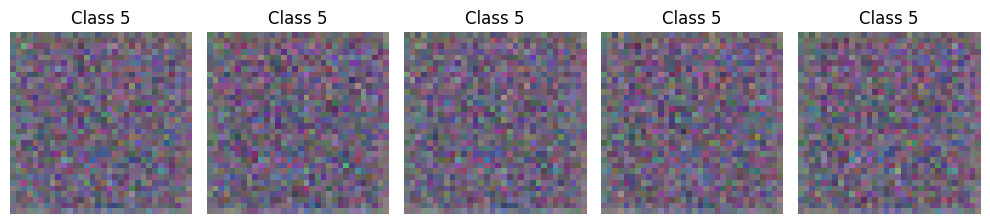

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Загрузка сохраненной модели
model = torch.load('VAE.pth')
model.eval()  # Переводим модель в режим оценки

# Генерация изображений для 5-го класса
num_images = 5  # Количество изображений для генерации
latent_dim = 32  # Размерность латентного пространства (как в вашей модели)
class_label = 5  # Класс, для которого генерируем изображения

with torch.no_grad():
    # Создаем метки класса
    labels = torch.tensor([class_label] * num_images)
    
    # Генерируем случайные точки в латентном пространстве
    z = torch.randn(num_images, latent_dim)
    
    # Получаем эмбеддинги для меток класса
    y = model.embed(labels)
    
    # Конкатенируем латентные векторы с эмбеддингами классов
    z_with_class = torch.cat([z, y], dim=1)
    
    # Пропускаем через dense слой
    out = model.dense(z_with_class)
    out = out.view(-1, 256, 32, 32)
    
    # Декодируем в изображения
    generated_images = model.decoder(out)
    
    # Преобразуем изображения для отображения
    generated_images = generated_images.permute(0, 2, 3, 1).cpu().numpy()

# Отображаем сгенерированные изображения
plt.figure(figsize=(10, 4))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(generated_images[i])
    plt.title(f"Class {class_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Vae совсем грустный, по крайней мере то, что написала я посмотрим что даст нам cGAN

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import cv2
import albumentations as A
import torch
from torch.utils.data import DataLoader
import glob
import torch
import cv2
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2 

In [5]:
class MyDataset(Dataset):
    def __init__(self, filenames, aug=None):
        self.filenames = filenames
        self.aug = aug

    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.filenames[idx]), cv2.COLOR_BGR2RGB)
        if self.aug:
            img = self.aug(image=img)['image']
        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        return img  # Возвращаем только изображение

    def __len__(self):
        return len(self.filenames)
filenames = glob.glob(os.path.join('train') + "/**/*.png", recursive=True)
dataset_generator = MyDataset(filenames)
dataloader = DataLoader(dataset_generator, batch_size=64, shuffle=True)

In [6]:
import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class MultiClassImageDataset(Dataset):
    def __init__(self, root_dir='train', transform=None):
        """
        Args:
            root_dir: Папка с подпапками классов (например, 'train')
            transform: Аугментации. Если None, применяется дефолтный набор для 32x32
        """
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))  # Список из 100 подпапок
        
        # Собираем все пути к изображениям (метки игнорируются)
        self.image_paths = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(cls_dir, fname))
        
        # Дефолтные аугментации для 32x32 (без ресайза!)
        self.transform = transform if transform else A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Диапазон [-1, 1]
            ToTensorV2()  # Конвертация в тензор [C, H, W]
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Загрузка изображения
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert('RGB')
        image_np = np.array(image)
        
        # Проверка размера (опционально)
        if image_np.shape[0] != 32 or image_np.shape[1] != 32:
            raise ValueError(f"Ожидается 32x32, получено {image_np.shape[:2]} (файл: {img_path})")
        
        # Применение аугментаций
        augmented = self.transform(image=image_np)
        image_tensor = augmented['image']  # Тензор [3, 32, 32] в [-1, 1]
        
        return image_tensor  # Только изображение, без метки
dataset = MultiClassImageDataset('train')  # Папка с 100 подпапками
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Проверка
batch = next(iter(dataloader))
print(batch.shape)  # torch.Size([64, 3, 32, 32])
print(batch.min(), batch.max())  # tensor(-1.), tensor(1.)

torch.Size([64, 3, 32, 32])
tensor(-1.) tensor(1.)


In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, feature_map_size=64, channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Вход: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),
            # 512 x 4 x 4
            
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),
            # 256 x 8 x 8
            
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),
            # 128 x 16 x 16
            
            nn.ConvTranspose2d(feature_map_size * 2, channels, 4, 2, 1, bias=False),
            # 3 x 32 x 32
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.model(z)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, feature_map_size=64, channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Вход: 3 x 32 x 32
            nn.Conv2d(channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 16 x 16
            
            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 8 x 8
            
            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 4 x 4
            
            nn.Conv2d(feature_map_size * 4, 1, 4, 1, 0, bias=False),
            # 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x)
        return out.view(-1) 

In [9]:
model_G = Generator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_G.to(device)


Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [10]:
model_C = Discriminator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_C.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [11]:
import torch.optim as optim

latent_dim = 100
lr = 0.00005
n_discriminator = 1     # количество шагов обучения критика за один шаг обучения генератора
n_generator = 1
clip_value = 0.01
num_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)

real_label = 1.
fake_label = 0.

optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

losses_G = []
losses_D = []

In [12]:
criterion = nn.BCELoss()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100] Batch 0/149  Loss_D: 1.3990  Loss_G: 1.4578
Epoch [1/100] Batch 50/149  Loss_D: 0.1744  Loss_G: 6.0381
Epoch [1/100] Batch 100/149  Loss_D: 0.0749  Loss_G: 6.2637


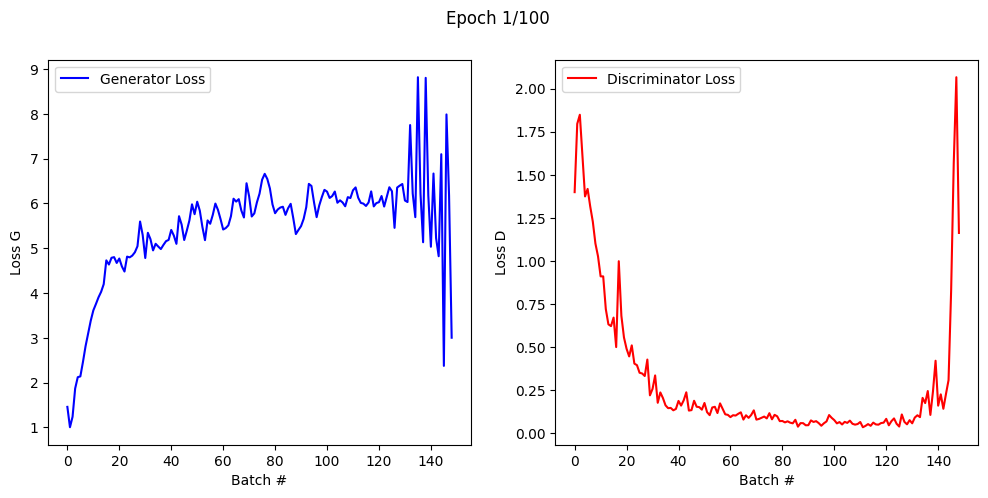

  1%|          | 1/100 [00:31<52:31, 31.83s/it]

Epoch [2/100] Batch 0/149  Loss_D: 0.6569  Loss_G: 2.2318
Epoch [2/100] Batch 50/149  Loss_D: 0.3897  Loss_G: 3.9685
Epoch [2/100] Batch 100/149  Loss_D: 0.6470  Loss_G: 4.9735


<Figure size 640x480 with 0 Axes>

  2%|▏         | 2/100 [00:39<29:06, 17.83s/it]

Epoch [3/100] Batch 0/149  Loss_D: 0.8164  Loss_G: 3.3272
Epoch [3/100] Batch 50/149  Loss_D: 0.7939  Loss_G: 1.3515
Epoch [3/100] Batch 100/149  Loss_D: 0.5344  Loss_G: 2.2079


<Figure size 640x480 with 0 Axes>

  3%|▎         | 3/100 [00:46<20:42, 12.81s/it]

Epoch [4/100] Batch 0/149  Loss_D: 0.7529  Loss_G: 1.8489
Epoch [4/100] Batch 50/149  Loss_D: 0.8840  Loss_G: 3.2777
Epoch [4/100] Batch 100/149  Loss_D: 1.2605  Loss_G: 1.2141


<Figure size 640x480 with 0 Axes>

  4%|▍         | 4/100 [00:53<16:44, 10.46s/it]

Epoch [5/100] Batch 0/149  Loss_D: 0.6222  Loss_G: 2.0760
Epoch [5/100] Batch 50/149  Loss_D: 0.4670  Loss_G: 3.1345
Epoch [5/100] Batch 100/149  Loss_D: 0.6243  Loss_G: 3.8428


<Figure size 640x480 with 0 Axes>

  5%|▌         | 5/100 [01:00<14:29,  9.15s/it]

Epoch [6/100] Batch 0/149  Loss_D: 0.3815  Loss_G: 2.5510
Epoch [6/100] Batch 50/149  Loss_D: 0.6079  Loss_G: 3.7146
Epoch [6/100] Batch 100/149  Loss_D: 0.4375  Loss_G: 1.6364


<Figure size 640x480 with 0 Axes>

  6%|▌         | 6/100 [01:07<13:08,  8.39s/it]

Epoch [7/100] Batch 0/149  Loss_D: 0.7319  Loss_G: 3.2540
Epoch [7/100] Batch 50/149  Loss_D: 0.8367  Loss_G: 3.9656
Epoch [7/100] Batch 100/149  Loss_D: 0.2905  Loss_G: 1.9203


<Figure size 640x480 with 0 Axes>

  7%|▋         | 7/100 [01:14<12:22,  7.99s/it]

Epoch [8/100] Batch 0/149  Loss_D: 0.5662  Loss_G: 3.0567
Epoch [8/100] Batch 50/149  Loss_D: 0.9536  Loss_G: 1.7508
Epoch [8/100] Batch 100/149  Loss_D: 0.2822  Loss_G: 2.7138


<Figure size 640x480 with 0 Axes>

  8%|▊         | 8/100 [01:21<11:40,  7.62s/it]

Epoch [9/100] Batch 0/149  Loss_D: 0.5536  Loss_G: 2.1590
Epoch [9/100] Batch 50/149  Loss_D: 0.3108  Loss_G: 2.5298
Epoch [9/100] Batch 100/149  Loss_D: 0.3634  Loss_G: 3.7581


<Figure size 640x480 with 0 Axes>

  9%|▉         | 9/100 [01:28<11:21,  7.49s/it]

Epoch [10/100] Batch 0/149  Loss_D: 0.2816  Loss_G: 3.4611
Epoch [10/100] Batch 50/149  Loss_D: 0.3466  Loss_G: 2.9599
Epoch [10/100] Batch 100/149  Loss_D: 0.4889  Loss_G: 3.5986


<Figure size 640x480 with 0 Axes>

 10%|█         | 10/100 [01:35<10:58,  7.32s/it]

Epoch [11/100] Batch 0/149  Loss_D: 0.5066  Loss_G: 3.2673
Epoch [11/100] Batch 50/149  Loss_D: 0.4181  Loss_G: 3.1048
Epoch [11/100] Batch 100/149  Loss_D: 0.2669  Loss_G: 2.8901


<Figure size 640x480 with 0 Axes>

 11%|█         | 11/100 [01:42<10:41,  7.21s/it]

Epoch [12/100] Batch 0/149  Loss_D: 1.0186  Loss_G: 5.1551
Epoch [12/100] Batch 50/149  Loss_D: 0.2133  Loss_G: 3.4399
Epoch [12/100] Batch 100/149  Loss_D: 0.6955  Loss_G: 2.8546


<Figure size 640x480 with 0 Axes>

 12%|█▏        | 12/100 [01:49<10:26,  7.12s/it]

Epoch [13/100] Batch 0/149  Loss_D: 0.3156  Loss_G: 3.7474
Epoch [13/100] Batch 50/149  Loss_D: 0.9417  Loss_G: 3.7374
Epoch [13/100] Batch 100/149  Loss_D: 0.9215  Loss_G: 3.1209


<Figure size 640x480 with 0 Axes>

 13%|█▎        | 13/100 [01:56<10:10,  7.02s/it]

Epoch [14/100] Batch 0/149  Loss_D: 0.1858  Loss_G: 3.8953
Epoch [14/100] Batch 50/149  Loss_D: 0.3475  Loss_G: 2.0098
Epoch [14/100] Batch 100/149  Loss_D: 0.8145  Loss_G: 4.9249


<Figure size 640x480 with 0 Axes>

 14%|█▍        | 14/100 [02:03<10:01,  6.99s/it]

Epoch [15/100] Batch 0/149  Loss_D: 0.4117  Loss_G: 3.9177
Epoch [15/100] Batch 50/149  Loss_D: 0.4929  Loss_G: 3.9762
Epoch [15/100] Batch 100/149  Loss_D: 0.6865  Loss_G: 3.6213


<Figure size 640x480 with 0 Axes>

 15%|█▌        | 15/100 [02:10<09:54,  6.99s/it]

Epoch [16/100] Batch 0/149  Loss_D: 0.9099  Loss_G: 4.5730
Epoch [16/100] Batch 50/149  Loss_D: 0.1092  Loss_G: 3.6998
Epoch [16/100] Batch 100/149  Loss_D: 0.4226  Loss_G: 3.5322


<Figure size 640x480 with 0 Axes>

 16%|█▌        | 16/100 [02:16<09:42,  6.93s/it]

Epoch [17/100] Batch 0/149  Loss_D: 0.4323  Loss_G: 2.2249
Epoch [17/100] Batch 50/149  Loss_D: 0.5535  Loss_G: 4.9914
Epoch [17/100] Batch 100/149  Loss_D: 0.3870  Loss_G: 2.3546


<Figure size 640x480 with 0 Axes>

 17%|█▋        | 17/100 [02:23<09:34,  6.92s/it]

Epoch [18/100] Batch 0/149  Loss_D: 0.1895  Loss_G: 3.0141
Epoch [18/100] Batch 50/149  Loss_D: 0.3539  Loss_G: 2.7049
Epoch [18/100] Batch 100/149  Loss_D: 0.4160  Loss_G: 3.1594


<Figure size 640x480 with 0 Axes>

 18%|█▊        | 18/100 [02:30<09:33,  6.99s/it]

Epoch [19/100] Batch 0/149  Loss_D: 0.3646  Loss_G: 3.5342
Epoch [19/100] Batch 50/149  Loss_D: 0.3710  Loss_G: 4.8372
Epoch [19/100] Batch 100/149  Loss_D: 1.2637  Loss_G: 0.3367


<Figure size 640x480 with 0 Axes>

 19%|█▉        | 19/100 [02:37<09:23,  6.96s/it]

Epoch [20/100] Batch 0/149  Loss_D: 0.2093  Loss_G: 2.9580
Epoch [20/100] Batch 50/149  Loss_D: 0.3688  Loss_G: 2.9758
Epoch [20/100] Batch 100/149  Loss_D: 0.2434  Loss_G: 3.6242


<Figure size 640x480 with 0 Axes>

 20%|██        | 20/100 [02:44<09:21,  7.02s/it]

Epoch [21/100] Batch 0/149  Loss_D: 0.1111  Loss_G: 3.8470
Epoch [21/100] Batch 50/149  Loss_D: 0.8963  Loss_G: 3.0582
Epoch [21/100] Batch 100/149  Loss_D: 0.8316  Loss_G: 2.2516


<Figure size 640x480 with 0 Axes>

 21%|██        | 21/100 [02:51<09:11,  6.98s/it]

Epoch [22/100] Batch 0/149  Loss_D: 0.3925  Loss_G: 2.4943
Epoch [22/100] Batch 50/149  Loss_D: 0.4091  Loss_G: 2.8722
Epoch [22/100] Batch 100/149  Loss_D: 0.2602  Loss_G: 3.4302


<Figure size 640x480 with 0 Axes>

 22%|██▏       | 22/100 [02:58<09:03,  6.97s/it]

Epoch [23/100] Batch 0/149  Loss_D: 0.1285  Loss_G: 4.4444
Epoch [23/100] Batch 50/149  Loss_D: 0.5239  Loss_G: 1.5686
Epoch [23/100] Batch 100/149  Loss_D: 0.3267  Loss_G: 3.0231


<Figure size 640x480 with 0 Axes>

 23%|██▎       | 23/100 [03:05<08:59,  7.01s/it]

Epoch [24/100] Batch 0/149  Loss_D: 0.2462  Loss_G: 3.8663
Epoch [24/100] Batch 50/149  Loss_D: 0.1910  Loss_G: 3.5318
Epoch [24/100] Batch 100/149  Loss_D: 0.1213  Loss_G: 3.5688


<Figure size 640x480 with 0 Axes>

 24%|██▍       | 24/100 [03:13<09:00,  7.12s/it]

Epoch [25/100] Batch 0/149  Loss_D: 0.0935  Loss_G: 5.3044
Epoch [25/100] Batch 50/149  Loss_D: 0.1304  Loss_G: 3.1222
Epoch [25/100] Batch 100/149  Loss_D: 0.1477  Loss_G: 3.9810


<Figure size 640x480 with 0 Axes>

 25%|██▌       | 25/100 [03:20<08:48,  7.04s/it]

Epoch [26/100] Batch 0/149  Loss_D: 0.9210  Loss_G: 2.8380
Epoch [26/100] Batch 50/149  Loss_D: 0.1700  Loss_G: 2.6313
Epoch [26/100] Batch 100/149  Loss_D: 0.0830  Loss_G: 3.9187


<Figure size 640x480 with 0 Axes>

 26%|██▌       | 26/100 [03:26<08:36,  6.98s/it]

Epoch [27/100] Batch 0/149  Loss_D: 0.1565  Loss_G: 3.9759
Epoch [27/100] Batch 50/149  Loss_D: 0.1120  Loss_G: 4.4802
Epoch [27/100] Batch 100/149  Loss_D: 0.1622  Loss_G: 2.7684


<Figure size 640x480 with 0 Axes>

 27%|██▋       | 27/100 [03:33<08:26,  6.94s/it]

Epoch [28/100] Batch 0/149  Loss_D: 0.0607  Loss_G: 3.7284
Epoch [28/100] Batch 50/149  Loss_D: 0.1413  Loss_G: 4.1293
Epoch [28/100] Batch 100/149  Loss_D: 0.8128  Loss_G: 1.9020


<Figure size 640x480 with 0 Axes>

 28%|██▊       | 28/100 [03:40<08:18,  6.93s/it]

Epoch [29/100] Batch 0/149  Loss_D: 0.6465  Loss_G: 2.8101
Epoch [29/100] Batch 50/149  Loss_D: 0.6310  Loss_G: 1.8327
Epoch [29/100] Batch 100/149  Loss_D: 0.3979  Loss_G: 3.1794


<Figure size 640x480 with 0 Axes>

 29%|██▉       | 29/100 [03:47<08:09,  6.90s/it]

Epoch [30/100] Batch 0/149  Loss_D: 0.1560  Loss_G: 2.8147
Epoch [30/100] Batch 50/149  Loss_D: 0.0974  Loss_G: 3.5331
Epoch [30/100] Batch 100/149  Loss_D: 0.2399  Loss_G: 2.3114


<Figure size 640x480 with 0 Axes>

 30%|███       | 30/100 [03:54<08:03,  6.91s/it]

Epoch [31/100] Batch 0/149  Loss_D: 0.2691  Loss_G: 2.5498
Epoch [31/100] Batch 50/149  Loss_D: 0.0962  Loss_G: 3.0992
Epoch [31/100] Batch 100/149  Loss_D: 0.1582  Loss_G: 2.7956


<Figure size 640x480 with 0 Axes>

 31%|███       | 31/100 [04:01<07:55,  6.90s/it]

Epoch [32/100] Batch 0/149  Loss_D: 0.3541  Loss_G: 3.4008
Epoch [32/100] Batch 50/149  Loss_D: 0.0707  Loss_G: 3.3943
Epoch [32/100] Batch 100/149  Loss_D: 0.4083  Loss_G: 1.7486


<Figure size 640x480 with 0 Axes>

 32%|███▏      | 32/100 [04:08<07:49,  6.91s/it]

Epoch [33/100] Batch 0/149  Loss_D: 0.1729  Loss_G: 3.6578
Epoch [33/100] Batch 50/149  Loss_D: 0.2821  Loss_G: 2.6759
Epoch [33/100] Batch 100/149  Loss_D: 0.0635  Loss_G: 3.9279


<Figure size 640x480 with 0 Axes>

 33%|███▎      | 33/100 [04:15<07:41,  6.90s/it]

Epoch [34/100] Batch 0/149  Loss_D: 0.1040  Loss_G: 5.1853
Epoch [34/100] Batch 50/149  Loss_D: 0.1954  Loss_G: 5.5838
Epoch [34/100] Batch 100/149  Loss_D: 0.0696  Loss_G: 4.1229


<Figure size 640x480 with 0 Axes>

 34%|███▍      | 34/100 [04:21<07:34,  6.89s/it]

Epoch [35/100] Batch 0/149  Loss_D: 0.2770  Loss_G: 2.5260
Epoch [35/100] Batch 50/149  Loss_D: 0.2166  Loss_G: 4.2764
Epoch [35/100] Batch 100/149  Loss_D: 0.1069  Loss_G: 4.7767


<Figure size 640x480 with 0 Axes>

 35%|███▌      | 35/100 [04:28<07:28,  6.90s/it]

Epoch [36/100] Batch 0/149  Loss_D: 0.0892  Loss_G: 2.2983
Epoch [36/100] Batch 50/149  Loss_D: 2.3410  Loss_G: 11.0895
Epoch [36/100] Batch 100/149  Loss_D: 0.1063  Loss_G: 4.7701


<Figure size 640x480 with 0 Axes>

 36%|███▌      | 36/100 [04:35<07:21,  6.89s/it]

Epoch [37/100] Batch 0/149  Loss_D: 0.2044  Loss_G: 2.4261
Epoch [37/100] Batch 50/149  Loss_D: 0.0379  Loss_G: 4.0973
Epoch [37/100] Batch 100/149  Loss_D: 0.2072  Loss_G: 3.8555


<Figure size 640x480 with 0 Axes>

 37%|███▋      | 37/100 [04:42<07:15,  6.91s/it]

Epoch [38/100] Batch 0/149  Loss_D: 0.2056  Loss_G: 4.7528
Epoch [38/100] Batch 50/149  Loss_D: 0.1264  Loss_G: 4.2089
Epoch [38/100] Batch 100/149  Loss_D: 1.6427  Loss_G: 4.1300


<Figure size 640x480 with 0 Axes>

 38%|███▊      | 38/100 [04:49<07:06,  6.87s/it]

Epoch [39/100] Batch 0/149  Loss_D: 0.3764  Loss_G: 2.4182
Epoch [39/100] Batch 50/149  Loss_D: 0.1657  Loss_G: 3.5423
Epoch [39/100] Batch 100/149  Loss_D: 0.0811  Loss_G: 3.2303


<Figure size 640x480 with 0 Axes>

 39%|███▉      | 39/100 [04:56<06:59,  6.88s/it]

Epoch [40/100] Batch 0/149  Loss_D: 0.0511  Loss_G: 2.9289
Epoch [40/100] Batch 50/149  Loss_D: 0.6667  Loss_G: 3.2350
Epoch [40/100] Batch 100/149  Loss_D: 0.4955  Loss_G: 5.0709


<Figure size 640x480 with 0 Axes>

 40%|████      | 40/100 [05:03<06:54,  6.92s/it]

Epoch [41/100] Batch 0/149  Loss_D: 0.1047  Loss_G: 3.0628
Epoch [41/100] Batch 50/149  Loss_D: 0.1659  Loss_G: 3.8445
Epoch [41/100] Batch 100/149  Loss_D: 0.9597  Loss_G: 4.5579


<Figure size 640x480 with 0 Axes>

 41%|████      | 41/100 [05:10<06:49,  6.94s/it]

Epoch [42/100] Batch 0/149  Loss_D: 0.1567  Loss_G: 3.6799
Epoch [42/100] Batch 50/149  Loss_D: 0.1719  Loss_G: 3.3927
Epoch [42/100] Batch 100/149  Loss_D: 0.0938  Loss_G: 3.2626


<Figure size 640x480 with 0 Axes>

 42%|████▏     | 42/100 [05:17<06:51,  7.09s/it]

Epoch [43/100] Batch 0/149  Loss_D: 0.0522  Loss_G: 5.8412
Epoch [43/100] Batch 50/149  Loss_D: 0.0950  Loss_G: 3.8942
Epoch [43/100] Batch 100/149  Loss_D: 0.4822  Loss_G: 1.1643


<Figure size 640x480 with 0 Axes>

 43%|████▎     | 43/100 [05:24<06:40,  7.02s/it]

Epoch [44/100] Batch 0/149  Loss_D: 0.2709  Loss_G: 1.6925
Epoch [44/100] Batch 50/149  Loss_D: 0.0813  Loss_G: 4.2915
Epoch [44/100] Batch 100/149  Loss_D: 0.1135  Loss_G: 3.1665


<Figure size 640x480 with 0 Axes>

 44%|████▍     | 44/100 [05:31<06:29,  6.96s/it]

Epoch [45/100] Batch 0/149  Loss_D: 0.0308  Loss_G: 5.1478
Epoch [45/100] Batch 50/149  Loss_D: 0.2089  Loss_G: 3.2729
Epoch [45/100] Batch 100/149  Loss_D: 0.1436  Loss_G: 4.1078


<Figure size 640x480 with 0 Axes>

 45%|████▌     | 45/100 [05:38<06:24,  6.99s/it]

Epoch [46/100] Batch 0/149  Loss_D: 0.0832  Loss_G: 5.6873
Epoch [46/100] Batch 50/149  Loss_D: 0.8098  Loss_G: 3.1214
Epoch [46/100] Batch 100/149  Loss_D: 0.1124  Loss_G: 3.9422


<Figure size 640x480 with 0 Axes>

 46%|████▌     | 46/100 [05:45<06:15,  6.96s/it]

Epoch [47/100] Batch 0/149  Loss_D: 0.0444  Loss_G: 4.7549
Epoch [47/100] Batch 50/149  Loss_D: 0.1436  Loss_G: 3.4526
Epoch [47/100] Batch 100/149  Loss_D: 0.1180  Loss_G: 3.6542


<Figure size 640x480 with 0 Axes>

 47%|████▋     | 47/100 [05:52<06:06,  6.92s/it]

Epoch [48/100] Batch 0/149  Loss_D: 0.0854  Loss_G: 3.8895
Epoch [48/100] Batch 50/149  Loss_D: 0.4815  Loss_G: 4.0757
Epoch [48/100] Batch 100/149  Loss_D: 0.1772  Loss_G: 3.7673


<Figure size 640x480 with 0 Axes>

 48%|████▊     | 48/100 [05:59<05:58,  6.90s/it]

Epoch [49/100] Batch 0/149  Loss_D: 0.2736  Loss_G: 3.4206
Epoch [49/100] Batch 50/149  Loss_D: 0.0938  Loss_G: 4.1305
Epoch [49/100] Batch 100/149  Loss_D: 0.0599  Loss_G: 4.1030


<Figure size 640x480 with 0 Axes>

 49%|████▉     | 49/100 [06:06<05:51,  6.89s/it]

Epoch [50/100] Batch 0/149  Loss_D: 0.1035  Loss_G: 4.0993
Epoch [50/100] Batch 50/149  Loss_D: 0.1835  Loss_G: 2.4652
Epoch [50/100] Batch 100/149  Loss_D: 0.2336  Loss_G: 2.9242


<Figure size 640x480 with 0 Axes>

 50%|█████     | 50/100 [06:12<05:44,  6.88s/it]

Epoch [51/100] Batch 0/149  Loss_D: 0.1455  Loss_G: 3.7785
Epoch [51/100] Batch 50/149  Loss_D: 0.1156  Loss_G: 4.2809
Epoch [51/100] Batch 100/149  Loss_D: 0.8912  Loss_G: 0.8601


<Figure size 640x480 with 0 Axes>

 51%|█████     | 51/100 [06:19<05:39,  6.94s/it]

Epoch [52/100] Batch 0/149  Loss_D: 0.1326  Loss_G: 3.5131
Epoch [52/100] Batch 50/149  Loss_D: 0.1094  Loss_G: 3.3919
Epoch [52/100] Batch 100/149  Loss_D: 0.3478  Loss_G: 2.9489


<Figure size 640x480 with 0 Axes>

 52%|█████▏    | 52/100 [06:26<05:32,  6.92s/it]

Epoch [53/100] Batch 0/149  Loss_D: 0.1160  Loss_G: 4.2860
Epoch [53/100] Batch 50/149  Loss_D: 0.1512  Loss_G: 1.8133
Epoch [53/100] Batch 100/149  Loss_D: 0.2503  Loss_G: 2.7949


<Figure size 640x480 with 0 Axes>

 53%|█████▎    | 53/100 [06:33<05:26,  6.94s/it]

Epoch [54/100] Batch 0/149  Loss_D: 0.1854  Loss_G: 1.8286
Epoch [54/100] Batch 50/149  Loss_D: 0.0613  Loss_G: 4.2843
Epoch [54/100] Batch 100/149  Loss_D: 0.4173  Loss_G: 3.2874


<Figure size 640x480 with 0 Axes>

 54%|█████▍    | 54/100 [06:40<05:20,  6.97s/it]

Epoch [55/100] Batch 0/149  Loss_D: 0.2428  Loss_G: 2.2234
Epoch [55/100] Batch 50/149  Loss_D: 0.2562  Loss_G: 3.2768
Epoch [55/100] Batch 100/149  Loss_D: 0.1363  Loss_G: 2.7143


<Figure size 640x480 with 0 Axes>

 55%|█████▌    | 55/100 [06:47<05:11,  6.93s/it]

Epoch [56/100] Batch 0/149  Loss_D: 0.2904  Loss_G: 5.4005
Epoch [56/100] Batch 50/149  Loss_D: 0.3049  Loss_G: 4.6091
Epoch [56/100] Batch 100/149  Loss_D: 0.1666  Loss_G: 2.8327


<Figure size 640x480 with 0 Axes>

 56%|█████▌    | 56/100 [06:54<05:04,  6.93s/it]

Epoch [57/100] Batch 0/149  Loss_D: 0.1099  Loss_G: 3.6371
Epoch [57/100] Batch 50/149  Loss_D: 0.1782  Loss_G: 3.9225
Epoch [57/100] Batch 100/149  Loss_D: 0.1886  Loss_G: 2.2901


<Figure size 640x480 with 0 Axes>

 57%|█████▋    | 57/100 [07:01<04:58,  6.95s/it]

Epoch [58/100] Batch 0/149  Loss_D: 0.0864  Loss_G: 3.8658
Epoch [58/100] Batch 50/149  Loss_D: 0.1218  Loss_G: 4.2895
Epoch [58/100] Batch 100/149  Loss_D: 0.6000  Loss_G: 2.5811


<Figure size 640x480 with 0 Axes>

 58%|█████▊    | 58/100 [07:08<04:50,  6.93s/it]

Epoch [59/100] Batch 0/149  Loss_D: 0.1739  Loss_G: 4.8401
Epoch [59/100] Batch 50/149  Loss_D: 0.1308  Loss_G: 4.6443
Epoch [59/100] Batch 100/149  Loss_D: 0.7343  Loss_G: 1.8033


<Figure size 640x480 with 0 Axes>

 59%|█████▉    | 59/100 [07:15<04:47,  7.02s/it]

Epoch [60/100] Batch 0/149  Loss_D: 0.5001  Loss_G: 3.4084
Epoch [60/100] Batch 50/149  Loss_D: 0.1068  Loss_G: 4.3927
Epoch [60/100] Batch 100/149  Loss_D: 0.1473  Loss_G: 3.6600


<Figure size 640x480 with 0 Axes>

 60%|██████    | 60/100 [07:22<04:39,  7.00s/it]

Epoch [61/100] Batch 0/149  Loss_D: 0.0557  Loss_G: 3.9039
Epoch [61/100] Batch 50/149  Loss_D: 0.0884  Loss_G: 4.3612
Epoch [61/100] Batch 100/149  Loss_D: 0.2922  Loss_G: 2.3745


<Figure size 640x480 with 0 Axes>

 61%|██████    | 61/100 [07:29<04:31,  6.96s/it]

Epoch [62/100] Batch 0/149  Loss_D: 0.2898  Loss_G: 4.6385
Epoch [62/100] Batch 50/149  Loss_D: 0.1214  Loss_G: 3.0885
Epoch [62/100] Batch 100/149  Loss_D: 0.1461  Loss_G: 3.7779


<Figure size 640x480 with 0 Axes>

 62%|██████▏   | 62/100 [07:36<04:24,  6.97s/it]

Epoch [63/100] Batch 0/149  Loss_D: 0.6847  Loss_G: 3.6927
Epoch [63/100] Batch 50/149  Loss_D: 0.1492  Loss_G: 3.8907
Epoch [63/100] Batch 100/149  Loss_D: 0.2204  Loss_G: 5.6198


<Figure size 640x480 with 0 Axes>

 63%|██████▎   | 63/100 [07:43<04:16,  6.93s/it]

Epoch [64/100] Batch 0/149  Loss_D: 0.2224  Loss_G: 4.2935
Epoch [64/100] Batch 50/149  Loss_D: 0.2351  Loss_G: 3.7860
Epoch [64/100] Batch 100/149  Loss_D: 0.1161  Loss_G: 5.0372


<Figure size 640x480 with 0 Axes>

 64%|██████▍   | 64/100 [07:50<04:09,  6.93s/it]

Epoch [65/100] Batch 0/149  Loss_D: 0.0851  Loss_G: 3.1740
Epoch [65/100] Batch 50/149  Loss_D: 0.2307  Loss_G: 2.4257
Epoch [65/100] Batch 100/149  Loss_D: 0.2508  Loss_G: 4.3786


<Figure size 640x480 with 0 Axes>

 65%|██████▌   | 65/100 [07:57<04:02,  6.92s/it]

Epoch [66/100] Batch 0/149  Loss_D: 0.6229  Loss_G: 3.4436
Epoch [66/100] Batch 50/149  Loss_D: 0.2787  Loss_G: 4.2931
Epoch [66/100] Batch 100/149  Loss_D: 0.0915  Loss_G: 4.4669


<Figure size 640x480 with 0 Axes>

 66%|██████▌   | 66/100 [08:03<03:54,  6.89s/it]

Epoch [67/100] Batch 0/149  Loss_D: 0.2345  Loss_G: 2.9630
Epoch [67/100] Batch 50/149  Loss_D: 0.0839  Loss_G: 3.6951
Epoch [67/100] Batch 100/149  Loss_D: 0.2086  Loss_G: 2.8555


<Figure size 640x480 with 0 Axes>

 67%|██████▋   | 67/100 [08:10<03:48,  6.91s/it]

Epoch [68/100] Batch 0/149  Loss_D: 0.3649  Loss_G: 4.3206
Epoch [68/100] Batch 50/149  Loss_D: 0.1021  Loss_G: 3.5245
Epoch [68/100] Batch 100/149  Loss_D: 0.0486  Loss_G: 2.8572


<Figure size 640x480 with 0 Axes>

 68%|██████▊   | 68/100 [08:17<03:41,  6.93s/it]

Epoch [69/100] Batch 0/149  Loss_D: 0.9547  Loss_G: 6.6983
Epoch [69/100] Batch 50/149  Loss_D: 0.4496  Loss_G: 4.7393
Epoch [69/100] Batch 100/149  Loss_D: 0.7658  Loss_G: 4.2064


<Figure size 640x480 with 0 Axes>

 69%|██████▉   | 69/100 [08:24<03:34,  6.90s/it]

Epoch [70/100] Batch 0/149  Loss_D: 0.1179  Loss_G: 2.4408
Epoch [70/100] Batch 50/149  Loss_D: 0.3887  Loss_G: 4.4516
Epoch [70/100] Batch 100/149  Loss_D: 0.2335  Loss_G: 3.4407


<Figure size 640x480 with 0 Axes>

 70%|███████   | 70/100 [08:31<03:27,  6.92s/it]

Epoch [71/100] Batch 0/149  Loss_D: 0.1875  Loss_G: 3.8109
Epoch [71/100] Batch 50/149  Loss_D: 0.1938  Loss_G: 4.3887
Epoch [71/100] Batch 100/149  Loss_D: 0.1679  Loss_G: 3.9418


<Figure size 640x480 with 0 Axes>

 71%|███████   | 71/100 [08:38<03:20,  6.93s/it]

Epoch [72/100] Batch 0/149  Loss_D: 0.7931  Loss_G: 1.7359
Epoch [72/100] Batch 50/149  Loss_D: 0.0987  Loss_G: 4.5947
Epoch [72/100] Batch 100/149  Loss_D: 0.4450  Loss_G: 3.9060


<Figure size 640x480 with 0 Axes>

 72%|███████▏  | 72/100 [08:45<03:13,  6.89s/it]

Epoch [73/100] Batch 0/149  Loss_D: 0.2421  Loss_G: 3.1105
Epoch [73/100] Batch 50/149  Loss_D: 0.0857  Loss_G: 3.4842
Epoch [73/100] Batch 100/149  Loss_D: 0.1501  Loss_G: 3.5259


<Figure size 640x480 with 0 Axes>

 73%|███████▎  | 73/100 [08:52<03:06,  6.91s/it]

Epoch [74/100] Batch 0/149  Loss_D: 0.2107  Loss_G: 4.3181
Epoch [74/100] Batch 50/149  Loss_D: 0.2869  Loss_G: 3.3157
Epoch [74/100] Batch 100/149  Loss_D: 0.1478  Loss_G: 2.1035


<Figure size 640x480 with 0 Axes>

 74%|███████▍  | 74/100 [08:59<03:00,  6.93s/it]

Epoch [75/100] Batch 0/149  Loss_D: 0.2217  Loss_G: 3.4661
Epoch [75/100] Batch 50/149  Loss_D: 0.5930  Loss_G: 3.4915
Epoch [75/100] Batch 100/149  Loss_D: 0.1523  Loss_G: 3.8108


<Figure size 640x480 with 0 Axes>

 75%|███████▌  | 75/100 [09:06<02:53,  6.94s/it]

Epoch [76/100] Batch 0/149  Loss_D: 0.2829  Loss_G: 2.8434
Epoch [76/100] Batch 50/149  Loss_D: 0.0872  Loss_G: 3.2140
Epoch [76/100] Batch 100/149  Loss_D: 0.2052  Loss_G: 1.7422


<Figure size 640x480 with 0 Axes>

 76%|███████▌  | 76/100 [09:13<02:47,  6.96s/it]

Epoch [77/100] Batch 0/149  Loss_D: 0.1527  Loss_G: 3.6934
Epoch [77/100] Batch 50/149  Loss_D: 0.2262  Loss_G: 3.2373
Epoch [77/100] Batch 100/149  Loss_D: 0.2991  Loss_G: 3.2438


<Figure size 640x480 with 0 Axes>

 77%|███████▋  | 77/100 [09:20<02:43,  7.09s/it]

Epoch [78/100] Batch 0/149  Loss_D: 0.2222  Loss_G: 3.6750
Epoch [78/100] Batch 50/149  Loss_D: 0.2575  Loss_G: 4.7702
Epoch [78/100] Batch 100/149  Loss_D: 0.1068  Loss_G: 4.0730


<Figure size 640x480 with 0 Axes>

 78%|███████▊  | 78/100 [09:27<02:34,  7.01s/it]

Epoch [79/100] Batch 0/149  Loss_D: 0.1742  Loss_G: 4.2894
Epoch [79/100] Batch 50/149  Loss_D: 0.2464  Loss_G: 3.1981
Epoch [79/100] Batch 100/149  Loss_D: 0.4935  Loss_G: 1.9214


<Figure size 640x480 with 0 Axes>

 79%|███████▉  | 79/100 [09:34<02:29,  7.11s/it]

Epoch [80/100] Batch 0/149  Loss_D: 0.3331  Loss_G: 4.0109
Epoch [80/100] Batch 50/149  Loss_D: 0.5830  Loss_G: 6.8733
Epoch [80/100] Batch 100/149  Loss_D: 0.3297  Loss_G: 2.1888


<Figure size 640x480 with 0 Axes>

 80%|████████  | 80/100 [09:41<02:21,  7.07s/it]

Epoch [81/100] Batch 0/149  Loss_D: 0.3066  Loss_G: 4.0083
Epoch [81/100] Batch 50/149  Loss_D: 0.1694  Loss_G: 3.5814
Epoch [81/100] Batch 100/149  Loss_D: 0.1803  Loss_G: 4.1838


<Figure size 640x480 with 0 Axes>

 81%|████████  | 81/100 [09:48<02:13,  7.00s/it]

Epoch [82/100] Batch 0/149  Loss_D: 0.0899  Loss_G: 4.0118
Epoch [82/100] Batch 50/149  Loss_D: 0.1485  Loss_G: 3.4091
Epoch [82/100] Batch 100/149  Loss_D: 0.2057  Loss_G: 4.2853


<Figure size 640x480 with 0 Axes>

 82%|████████▏ | 82/100 [09:55<02:05,  6.97s/it]

Epoch [83/100] Batch 0/149  Loss_D: 0.6331  Loss_G: 5.4004
Epoch [83/100] Batch 50/149  Loss_D: 0.5178  Loss_G: 5.8182
Epoch [83/100] Batch 100/149  Loss_D: 0.2342  Loss_G: 3.7468


<Figure size 640x480 with 0 Axes>

 83%|████████▎ | 83/100 [10:02<01:57,  6.93s/it]

Epoch [84/100] Batch 0/149  Loss_D: 0.1102  Loss_G: 3.7777
Epoch [84/100] Batch 50/149  Loss_D: 0.3376  Loss_G: 5.0534
Epoch [84/100] Batch 100/149  Loss_D: 0.1681  Loss_G: 3.6873


<Figure size 640x480 with 0 Axes>

 84%|████████▍ | 84/100 [10:09<01:51,  6.96s/it]

Epoch [85/100] Batch 0/149  Loss_D: 0.2117  Loss_G: 3.0560
Epoch [85/100] Batch 50/149  Loss_D: 0.5046  Loss_G: 3.9431
Epoch [85/100] Batch 100/149  Loss_D: 0.3297  Loss_G: 2.8877


<Figure size 640x480 with 0 Axes>

 85%|████████▌ | 85/100 [10:16<01:45,  7.01s/it]

Epoch [86/100] Batch 0/149  Loss_D: 0.2878  Loss_G: 2.2108
Epoch [86/100] Batch 50/149  Loss_D: 0.3001  Loss_G: 2.6568
Epoch [86/100] Batch 100/149  Loss_D: 0.3533  Loss_G: 2.6667


<Figure size 640x480 with 0 Axes>

 86%|████████▌ | 86/100 [10:23<01:37,  6.96s/it]

Epoch [87/100] Batch 0/149  Loss_D: 0.2749  Loss_G: 3.1719
Epoch [87/100] Batch 50/149  Loss_D: 0.1076  Loss_G: 4.0139
Epoch [87/100] Batch 100/149  Loss_D: 0.1137  Loss_G: 4.0605


<Figure size 640x480 with 0 Axes>

 87%|████████▋ | 87/100 [10:30<01:30,  6.95s/it]

Epoch [88/100] Batch 0/149  Loss_D: 0.0973  Loss_G: 3.1572
Epoch [88/100] Batch 50/149  Loss_D: 0.1506  Loss_G: 2.9080
Epoch [88/100] Batch 100/149  Loss_D: 0.4228  Loss_G: 4.1901


<Figure size 640x480 with 0 Axes>

 88%|████████▊ | 88/100 [10:37<01:23,  6.96s/it]

Epoch [89/100] Batch 0/149  Loss_D: 0.2430  Loss_G: 5.3378
Epoch [89/100] Batch 50/149  Loss_D: 0.0926  Loss_G: 3.4136
Epoch [89/100] Batch 100/149  Loss_D: 0.1142  Loss_G: 4.1395


<Figure size 640x480 with 0 Axes>

 89%|████████▉ | 89/100 [10:44<01:16,  6.93s/it]

Epoch [90/100] Batch 0/149  Loss_D: 0.5518  Loss_G: 4.9364
Epoch [90/100] Batch 50/149  Loss_D: 0.1986  Loss_G: 3.2477
Epoch [90/100] Batch 100/149  Loss_D: 0.2168  Loss_G: 4.7293


<Figure size 640x480 with 0 Axes>

 90%|█████████ | 90/100 [10:51<01:10,  7.04s/it]

Epoch [91/100] Batch 0/149  Loss_D: 0.5791  Loss_G: 3.1811
Epoch [91/100] Batch 50/149  Loss_D: 0.2667  Loss_G: 2.3729
Epoch [91/100] Batch 100/149  Loss_D: 0.3052  Loss_G: 2.7570


<Figure size 640x480 with 0 Axes>

 91%|█████████ | 91/100 [10:58<01:03,  7.00s/it]

Epoch [92/100] Batch 0/149  Loss_D: 0.1090  Loss_G: 3.8406
Epoch [92/100] Batch 50/149  Loss_D: 0.5604  Loss_G: 0.8847
Epoch [92/100] Batch 100/149  Loss_D: 0.1503  Loss_G: 2.6174


<Figure size 640x480 with 0 Axes>

 92%|█████████▏| 92/100 [11:05<00:56,  7.04s/it]

Epoch [93/100] Batch 0/149  Loss_D: 0.5891  Loss_G: 1.6381
Epoch [93/100] Batch 50/149  Loss_D: 0.1353  Loss_G: 2.0861
Epoch [93/100] Batch 100/149  Loss_D: 0.2997  Loss_G: 3.4166


<Figure size 640x480 with 0 Axes>

 93%|█████████▎| 93/100 [11:12<00:49,  7.02s/it]

Epoch [94/100] Batch 0/149  Loss_D: 0.2354  Loss_G: 2.5123
Epoch [94/100] Batch 50/149  Loss_D: 0.7342  Loss_G: 6.6070
Epoch [94/100] Batch 100/149  Loss_D: 0.2135  Loss_G: 2.3577


<Figure size 640x480 with 0 Axes>

 94%|█████████▍| 94/100 [11:19<00:41,  6.99s/it]

Epoch [95/100] Batch 0/149  Loss_D: 0.5057  Loss_G: 4.6217
Epoch [95/100] Batch 50/149  Loss_D: 0.1236  Loss_G: 2.2232
Epoch [95/100] Batch 100/149  Loss_D: 0.1382  Loss_G: 4.4864


<Figure size 640x480 with 0 Axes>

 95%|█████████▌| 95/100 [11:26<00:34,  6.95s/it]

Epoch [96/100] Batch 0/149  Loss_D: 0.1952  Loss_G: 3.3993
Epoch [96/100] Batch 50/149  Loss_D: 0.3334  Loss_G: 2.0213
Epoch [96/100] Batch 100/149  Loss_D: 0.4122  Loss_G: 3.4898


<Figure size 640x480 with 0 Axes>

 96%|█████████▌| 96/100 [11:33<00:27,  6.97s/it]

Epoch [97/100] Batch 0/149  Loss_D: 0.1989  Loss_G: 4.7815
Epoch [97/100] Batch 50/149  Loss_D: 1.3488  Loss_G: 1.1206
Epoch [97/100] Batch 100/149  Loss_D: 0.2977  Loss_G: 4.0617


<Figure size 640x480 with 0 Axes>

 97%|█████████▋| 97/100 [11:40<00:20,  6.93s/it]

Epoch [98/100] Batch 0/149  Loss_D: 0.3671  Loss_G: 3.4775
Epoch [98/100] Batch 50/149  Loss_D: 0.3348  Loss_G: 3.6890
Epoch [98/100] Batch 100/149  Loss_D: 0.5459  Loss_G: 3.2249


<Figure size 640x480 with 0 Axes>

 98%|█████████▊| 98/100 [11:47<00:13,  6.92s/it]

Epoch [99/100] Batch 0/149  Loss_D: 0.4971  Loss_G: 3.8919
Epoch [99/100] Batch 50/149  Loss_D: 0.3817  Loss_G: 2.7913
Epoch [99/100] Batch 100/149  Loss_D: 0.2162  Loss_G: 3.8936


<Figure size 640x480 with 0 Axes>

 99%|█████████▉| 99/100 [11:54<00:06,  6.92s/it]

Epoch [100/100] Batch 0/149  Loss_D: 0.1314  Loss_G: 2.7840
Epoch [100/100] Batch 50/149  Loss_D: 0.4273  Loss_G: 3.0795
Epoch [100/100] Batch 100/149  Loss_D: 0.2993  Loss_G: 3.1548


<Figure size 640x480 with 0 Axes>

100%|██████████| 100/100 [12:01<00:00,  7.21s/it]


In [13]:
#Советую здесь попробовать подмешать собачьи картинки как фейковые для критика.
import matplotlib.pyplot as plt
from tqdm import tqdm


plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for epoch in tqdm(range(num_epochs)):
    for i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size_curr = real_images.size(0)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        for _ in range(n_discriminator):
            optimizer_D.zero_grad()

            labels_real = torch.full((batch_size_curr,), real_label, device=device)
            output_real = D(real_images).view(-1)
            loss_D_real = criterion(output_real, labels_real)
            loss_D_real.backward()

            noise = torch.randn(batch_size_curr, latent_dim, device=device)
            fake_images = G(noise)
            labels_fake = torch.full((batch_size_curr,), fake_label, device=device)

            output_fake = D(fake_images.detach()).view(-1)
            loss_D_fake = criterion(output_fake, labels_fake)
            loss_D_fake.backward()

            loss_D = loss_D_real + loss_D_fake
            optimizer_D.step()

        losses_D.append(loss_D.item())

        # ---------------------
        #  Train Generator
        # ---------------------
        for _ in range(n_generator):
            optimizer_G.zero_grad()
            labels_gen = torch.full((batch_size_curr,), real_label, device=device)
            noise = torch.randn(batch_size_curr, latent_dim, device=device)
            fake_images = G(noise)

            output_fake_for_G = D(fake_images).view(-1)
            loss_G = criterion(output_fake_for_G, labels_gen)
            loss_G.backward()
            optimizer_G.step()

        losses_G.append(loss_G.item())

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(dataloader)}  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")

    ax1.clear()
    ax1.plot(losses_G, label="Generator Loss", color='blue')
    ax1.set_xlabel("Batch #")
    ax1.set_ylabel("Loss G")
    ax1.legend()

    ax2.clear()
    ax2.plot(losses_D, label="Discriminator Loss", color='red')
    ax2.set_xlabel("Batch #")
    ax2.set_ylabel("Loss D")
    ax2.legend()

    plt.suptitle(f"Epoch {epoch+1}/{num_epochs}")
    plt.pause(0.1)

plt.ioff()
plt.show()

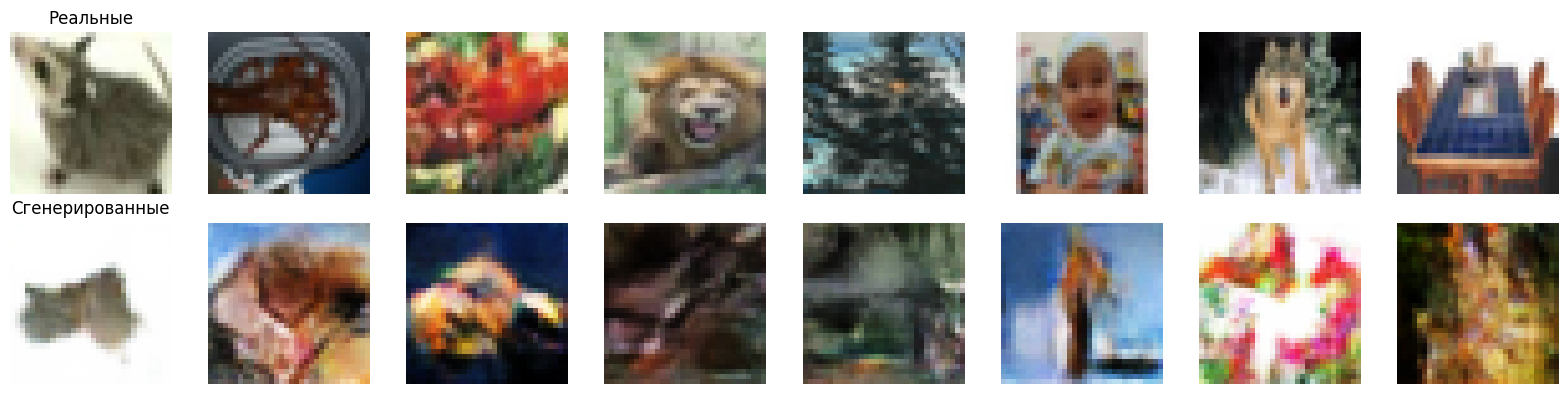

In [14]:
def denormalize(img_tensor):
    img_tensor = (img_tensor + 1) / 2
    return img_tensor.clamp(0, 1)

real_batch = next(iter(dataloader)).to(device)

noise = torch.randn(real_batch.size(0), latent_dim, device=device)
with torch.no_grad():
    fake_batch = G(noise)

n_display = 8
real_imgs = real_batch[:n_display].cpu()
fake_imgs = fake_batch[:n_display].cpu()

fig, axes = plt.subplots(2, n_display, figsize=(n_display * 2, 4))
for i in range(n_display):
    img = denormalize(real_imgs[i]).permute(1, 2, 0).numpy()
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Реальные", fontsize=12)

    img_fake = denormalize(fake_imgs[i]).permute(1, 2, 0).numpy()
    axes[1, i].imshow(img_fake)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title("Сгенерированные", fontsize=12)

plt.tight_layout()
plt.show()

Epoch 1/100: 100%|██████████| 149/149 [00:21<00:00,  6.85it/s]


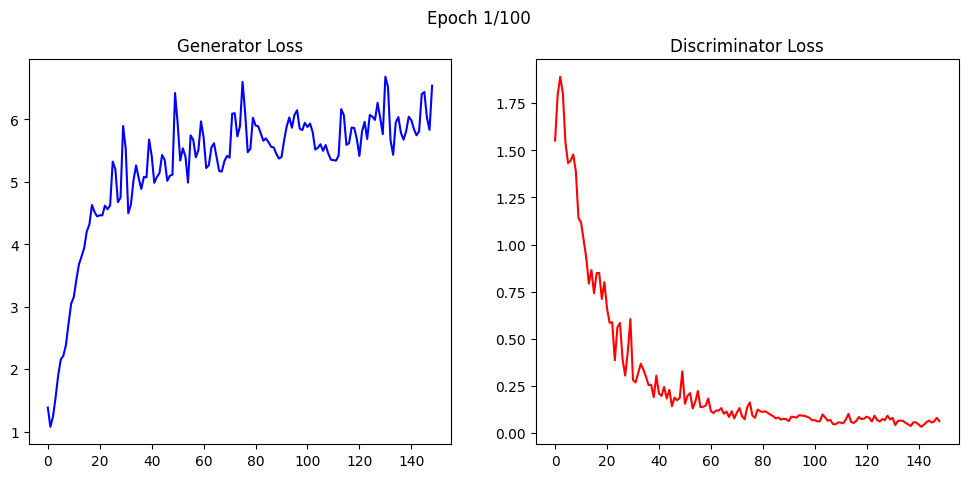

Epoch 2/100: 100%|██████████| 149/149 [00:06<00:00, 21.52it/s]


<Figure size 640x480 with 0 Axes>

Epoch 3/100: 100%|██████████| 149/149 [00:06<00:00, 24.68it/s]


<Figure size 640x480 with 0 Axes>

Epoch 4/100: 100%|██████████| 149/149 [00:05<00:00, 25.15it/s]


<Figure size 640x480 with 0 Axes>

Epoch 5/100: 100%|██████████| 149/149 [00:05<00:00, 25.24it/s]


<Figure size 640x480 with 0 Axes>

Epoch 6/100: 100%|██████████| 149/149 [00:06<00:00, 24.71it/s]


<Figure size 640x480 with 0 Axes>

Epoch 7/100: 100%|██████████| 149/149 [00:05<00:00, 25.75it/s]


<Figure size 640x480 with 0 Axes>

Epoch 8/100: 100%|██████████| 149/149 [00:05<00:00, 25.06it/s]


<Figure size 640x480 with 0 Axes>

Epoch 9/100: 100%|██████████| 149/149 [00:05<00:00, 25.72it/s]


<Figure size 640x480 with 0 Axes>

Epoch 10/100: 100%|██████████| 149/149 [00:05<00:00, 25.29it/s]


<Figure size 640x480 with 0 Axes>

Epoch 11/100: 100%|██████████| 149/149 [00:05<00:00, 25.58it/s]


<Figure size 640x480 with 0 Axes>

Epoch 12/100: 100%|██████████| 149/149 [00:05<00:00, 25.30it/s]


<Figure size 640x480 with 0 Axes>

Epoch 13/100: 100%|██████████| 149/149 [00:05<00:00, 25.34it/s]


<Figure size 640x480 with 0 Axes>

Epoch 14/100: 100%|██████████| 149/149 [00:05<00:00, 25.29it/s]


<Figure size 640x480 with 0 Axes>

Epoch 15/100: 100%|██████████| 149/149 [00:05<00:00, 25.13it/s]


<Figure size 640x480 with 0 Axes>

Epoch 16/100: 100%|██████████| 149/149 [00:05<00:00, 25.53it/s]


<Figure size 640x480 with 0 Axes>

Epoch 17/100: 100%|██████████| 149/149 [00:05<00:00, 25.25it/s]


<Figure size 640x480 with 0 Axes>

Epoch 18/100: 100%|██████████| 149/149 [00:06<00:00, 24.45it/s]


<Figure size 640x480 with 0 Axes>

Epoch 19/100: 100%|██████████| 149/149 [00:05<00:00, 25.27it/s]


<Figure size 640x480 with 0 Axes>

Epoch 20/100: 100%|██████████| 149/149 [00:05<00:00, 25.56it/s]


<Figure size 640x480 with 0 Axes>

Epoch 21/100: 100%|██████████| 149/149 [00:05<00:00, 25.21it/s]


<Figure size 640x480 with 0 Axes>

Epoch 22/100: 100%|██████████| 149/149 [00:05<00:00, 25.10it/s]


<Figure size 640x480 with 0 Axes>

Epoch 23/100: 100%|██████████| 149/149 [00:05<00:00, 25.55it/s]


<Figure size 640x480 with 0 Axes>

Epoch 24/100: 100%|██████████| 149/149 [00:05<00:00, 25.12it/s]


<Figure size 640x480 with 0 Axes>

Epoch 25/100: 100%|██████████| 149/149 [00:05<00:00, 25.20it/s]


<Figure size 640x480 with 0 Axes>

Epoch 26/100: 100%|██████████| 149/149 [00:06<00:00, 24.68it/s]


<Figure size 640x480 with 0 Axes>

Epoch 27/100: 100%|██████████| 149/149 [00:05<00:00, 25.35it/s]


<Figure size 640x480 with 0 Axes>

Epoch 28/100: 100%|██████████| 149/149 [00:05<00:00, 25.10it/s]


<Figure size 640x480 with 0 Axes>

Epoch 29/100: 100%|██████████| 149/149 [00:05<00:00, 25.04it/s]


<Figure size 640x480 with 0 Axes>

Epoch 30/100: 100%|██████████| 149/149 [00:05<00:00, 25.41it/s]


<Figure size 640x480 with 0 Axes>

Epoch 31/100: 100%|██████████| 149/149 [00:05<00:00, 25.19it/s]


<Figure size 640x480 with 0 Axes>

Epoch 32/100: 100%|██████████| 149/149 [00:05<00:00, 25.72it/s]


<Figure size 640x480 with 0 Axes>

Epoch 33/100: 100%|██████████| 149/149 [00:05<00:00, 25.27it/s]


<Figure size 640x480 with 0 Axes>

Epoch 34/100: 100%|██████████| 149/149 [00:05<00:00, 25.13it/s]


<Figure size 640x480 with 0 Axes>

Epoch 35/100: 100%|██████████| 149/149 [00:05<00:00, 24.94it/s]


<Figure size 640x480 with 0 Axes>

Epoch 36/100: 100%|██████████| 149/149 [00:05<00:00, 25.21it/s]


<Figure size 640x480 with 0 Axes>

Epoch 37/100: 100%|██████████| 149/149 [00:06<00:00, 24.75it/s]


<Figure size 640x480 with 0 Axes>

Epoch 38/100: 100%|██████████| 149/149 [00:05<00:00, 25.24it/s]


<Figure size 640x480 with 0 Axes>

Epoch 39/100: 100%|██████████| 149/149 [00:05<00:00, 25.69it/s]


<Figure size 640x480 with 0 Axes>

Epoch 40/100: 100%|██████████| 149/149 [00:05<00:00, 24.94it/s]


<Figure size 640x480 with 0 Axes>

Epoch 41/100: 100%|██████████| 149/149 [00:05<00:00, 25.72it/s]


<Figure size 640x480 with 0 Axes>

Epoch 42/100: 100%|██████████| 149/149 [00:05<00:00, 25.13it/s]


<Figure size 640x480 with 0 Axes>

Epoch 43/100: 100%|██████████| 149/149 [00:05<00:00, 25.32it/s]


<Figure size 640x480 with 0 Axes>

Epoch 44/100: 100%|██████████| 149/149 [00:06<00:00, 24.68it/s]


<Figure size 640x480 with 0 Axes>

Epoch 45/100: 100%|██████████| 149/149 [00:05<00:00, 25.24it/s]


<Figure size 640x480 with 0 Axes>

Epoch 46/100: 100%|██████████| 149/149 [00:05<00:00, 24.90it/s]


<Figure size 640x480 with 0 Axes>

Epoch 47/100: 100%|██████████| 149/149 [00:05<00:00, 24.85it/s]


<Figure size 640x480 with 0 Axes>

Epoch 48/100: 100%|██████████| 149/149 [00:05<00:00, 25.49it/s]


<Figure size 640x480 with 0 Axes>

Epoch 49/100: 100%|██████████| 149/149 [00:05<00:00, 25.12it/s]


<Figure size 640x480 with 0 Axes>

Epoch 50/100: 100%|██████████| 149/149 [00:05<00:00, 25.39it/s]


<Figure size 640x480 with 0 Axes>

Epoch 51/100: 100%|██████████| 149/149 [00:05<00:00, 24.98it/s]


<Figure size 640x480 with 0 Axes>

Epoch 52/100: 100%|██████████| 149/149 [00:05<00:00, 25.56it/s]


<Figure size 640x480 with 0 Axes>

Epoch 53/100: 100%|██████████| 149/149 [00:05<00:00, 24.85it/s]


<Figure size 640x480 with 0 Axes>

Epoch 54/100: 100%|██████████| 149/149 [00:06<00:00, 24.68it/s]


<Figure size 640x480 with 0 Axes>

Epoch 55/100: 100%|██████████| 149/149 [00:05<00:00, 25.14it/s]


<Figure size 640x480 with 0 Axes>

Epoch 56/100: 100%|██████████| 149/149 [00:05<00:00, 24.92it/s]


<Figure size 640x480 with 0 Axes>

Epoch 57/100: 100%|██████████| 149/149 [00:05<00:00, 25.68it/s]


<Figure size 640x480 with 0 Axes>

Epoch 58/100: 100%|██████████| 149/149 [00:05<00:00, 25.09it/s]


<Figure size 640x480 with 0 Axes>

Epoch 59/100: 100%|██████████| 149/149 [00:05<00:00, 25.51it/s]


<Figure size 640x480 with 0 Axes>

Epoch 60/100: 100%|██████████| 149/149 [00:05<00:00, 25.28it/s]


<Figure size 640x480 with 0 Axes>

Epoch 61/100: 100%|██████████| 149/149 [00:05<00:00, 25.56it/s]


<Figure size 640x480 with 0 Axes>

Epoch 62/100: 100%|██████████| 149/149 [00:05<00:00, 24.87it/s]


<Figure size 640x480 with 0 Axes>

Epoch 63/100: 100%|██████████| 149/149 [00:06<00:00, 24.73it/s]


<Figure size 640x480 with 0 Axes>

Epoch 64/100: 100%|██████████| 149/149 [00:05<00:00, 24.95it/s]


<Figure size 640x480 with 0 Axes>

Epoch 65/100: 100%|██████████| 149/149 [00:06<00:00, 24.73it/s]


<Figure size 640x480 with 0 Axes>

Epoch 66/100: 100%|██████████| 149/149 [00:06<00:00, 24.74it/s]


<Figure size 640x480 with 0 Axes>

Epoch 67/100: 100%|██████████| 149/149 [00:06<00:00, 24.76it/s]


<Figure size 640x480 with 0 Axes>

Epoch 68/100: 100%|██████████| 149/149 [00:05<00:00, 25.58it/s]


<Figure size 640x480 with 0 Axes>

Epoch 69/100: 100%|██████████| 149/149 [00:06<00:00, 23.60it/s]


<Figure size 640x480 with 0 Axes>

Epoch 70/100: 100%|██████████| 149/149 [00:05<00:00, 25.55it/s]


<Figure size 640x480 with 0 Axes>

Epoch 71/100: 100%|██████████| 149/149 [00:05<00:00, 25.48it/s]


<Figure size 640x480 with 0 Axes>

Epoch 72/100: 100%|██████████| 149/149 [00:05<00:00, 24.98it/s]


<Figure size 640x480 with 0 Axes>

Epoch 73/100: 100%|██████████| 149/149 [00:05<00:00, 25.26it/s]


<Figure size 640x480 with 0 Axes>

Epoch 74/100: 100%|██████████| 149/149 [00:06<00:00, 24.74it/s]


<Figure size 640x480 with 0 Axes>

Epoch 75/100: 100%|██████████| 149/149 [00:05<00:00, 25.35it/s]


<Figure size 640x480 with 0 Axes>

Epoch 76/100: 100%|██████████| 149/149 [00:05<00:00, 24.94it/s]


<Figure size 640x480 with 0 Axes>

Epoch 77/100: 100%|██████████| 149/149 [00:05<00:00, 25.17it/s]


<Figure size 640x480 with 0 Axes>

Epoch 78/100: 100%|██████████| 149/149 [00:05<00:00, 25.01it/s]


<Figure size 640x480 with 0 Axes>

Epoch 79/100: 100%|██████████| 149/149 [00:05<00:00, 24.97it/s]


<Figure size 640x480 with 0 Axes>

Epoch 80/100: 100%|██████████| 149/149 [00:05<00:00, 25.26it/s]


<Figure size 640x480 with 0 Axes>

Epoch 81/100: 100%|██████████| 149/149 [00:05<00:00, 24.98it/s]


<Figure size 640x480 with 0 Axes>

Epoch 82/100: 100%|██████████| 149/149 [00:05<00:00, 25.08it/s]


<Figure size 640x480 with 0 Axes>

Epoch 83/100: 100%|██████████| 149/149 [00:06<00:00, 24.72it/s]


<Figure size 640x480 with 0 Axes>

Epoch 84/100: 100%|██████████| 149/149 [00:05<00:00, 24.95it/s]


<Figure size 640x480 with 0 Axes>

Epoch 85/100: 100%|██████████| 149/149 [00:06<00:00, 24.25it/s]


<Figure size 640x480 with 0 Axes>

Epoch 86/100: 100%|██████████| 149/149 [00:05<00:00, 25.14it/s]


<Figure size 640x480 with 0 Axes>

Epoch 87/100: 100%|██████████| 149/149 [00:05<00:00, 24.94it/s]


<Figure size 640x480 with 0 Axes>

Epoch 88/100: 100%|██████████| 149/149 [00:05<00:00, 24.88it/s]


<Figure size 640x480 with 0 Axes>

Epoch 89/100: 100%|██████████| 149/149 [00:05<00:00, 25.18it/s]


<Figure size 640x480 with 0 Axes>

Epoch 90/100: 100%|██████████| 149/149 [00:05<00:00, 24.98it/s]


<Figure size 640x480 with 0 Axes>

Epoch 91/100: 100%|██████████| 149/149 [00:05<00:00, 25.26it/s]


<Figure size 640x480 with 0 Axes>

Epoch 92/100: 100%|██████████| 149/149 [00:05<00:00, 25.03it/s]


<Figure size 640x480 with 0 Axes>

Epoch 93/100: 100%|██████████| 149/149 [00:05<00:00, 25.39it/s]


<Figure size 640x480 with 0 Axes>

Epoch 94/100: 100%|██████████| 149/149 [00:06<00:00, 24.61it/s]


<Figure size 640x480 with 0 Axes>

Epoch 95/100: 100%|██████████| 149/149 [00:06<00:00, 24.57it/s]


<Figure size 640x480 with 0 Axes>

Epoch 96/100: 100%|██████████| 149/149 [00:05<00:00, 25.07it/s]


<Figure size 640x480 with 0 Axes>

Epoch 97/100: 100%|██████████| 149/149 [00:05<00:00, 24.96it/s]


<Figure size 640x480 with 0 Axes>

Epoch 98/100: 100%|██████████| 149/149 [00:05<00:00, 25.35it/s]


<Figure size 640x480 with 0 Axes>

Epoch 99/100: 100%|██████████| 149/149 [00:05<00:00, 24.90it/s]


<Figure size 640x480 with 0 Axes>

Epoch 100/100: 100%|██████████| 149/149 [00:05<00:00, 25.30it/s]


<Figure size 640x480 with 0 Axes>


Final models saved as cgan_final_model.pth


In [2]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Гиперпараметры
latent_dim = 100
num_classes = 100  # Должно совпадать с реальным числом классов!
lr = 0.0002
batch_size = 64
n_critic = 1
n_generator = 1
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
class MultiClassImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(cls_dir, fname), self.class_to_idx[cls]))
        
        self.transform = transform or A.Compose([
            A.Resize(32, 32),
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        image_np = np.array(image)
        
        augmented = self.transform(image=image_np)
        image_tensor = augmented['image']
        label_tensor = torch.tensor(label, dtype=torch.long)  # Критично: dtype=torch.long
        
        return image_tensor, label_tensor

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=100, feature_map_size=64, channels=3):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + num_classes, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(feature_map_size * 2, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_onehot = F.one_hot(labels, num_classes=self.num_classes).float().to(z.device)
        z = torch.cat([z, label_onehot], dim=1)
        z = z.unsqueeze(2).unsqueeze(3)
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, feature_map_size=64, channels=3, num_classes=100):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.feature_size = feature_map_size * 4 * 4 * 4
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size + num_classes, 1),
            nn.Sigmoid()
        )
        
        self.label_embedding = nn.Embedding(num_classes, num_classes)

    def forward(self, x, labels=None):
        features = self.conv_layers(x)
        features = features.view(features.size(0), -1)
        
        if labels is not None:
            label_embed = self.label_embedding(labels)
            features = torch.cat([features, label_embed], dim=1)
        
        return self.fc(features).view(-1)

# Инициализация
dataset = MultiClassImageDataset("train")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

G = Generator(latent_dim=latent_dim, num_classes=num_classes).to(device)
D = Discriminator(num_classes=num_classes).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

scheduler_G = StepLR(optimizer_G, step_size=30, gamma=0.1)
scheduler_D = StepLR(optimizer_D, step_size=30, gamma=0.1)

criterion = nn.BCELoss()

# Обучение
losses_G = []
losses_D = []

plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for epoch in range(num_epochs):
    for real_images, real_labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Проверка данных
        if real_images is None or real_labels is None:
            raise ValueError("DataLoader вернул None!")
        
        real_images = real_images.to(device)
        real_labels = real_labels.to(device)
        batch_size_curr = real_images.size(0)

        # Метки для реальных и фейковых изображений
        labels_real = torch.full((batch_size_curr,), 1.0, device=device)
        labels_fake = torch.full((batch_size_curr,), 0.0, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()
        
        # Реальные изображения
        output_real = D(real_images, real_labels)
        loss_D_real = criterion(output_real, labels_real)
        
        # Фейковые изображения
        noise = torch.randn(batch_size_curr, latent_dim, device=device)
        fake_labels = torch.randint(0, num_classes, (batch_size_curr,), device=device)
        fake_images = G(noise, fake_labels)
        
        output_fake = D(fake_images.detach(), fake_labels)
        loss_D_fake = criterion(output_fake, labels_fake)
        
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        output_fake_for_G = D(fake_images, fake_labels)
        loss_G = criterion(output_fake_for_G, labels_real)
        loss_G.backward()
        optimizer_G.step()

        # Логирование
        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())
        

    # Визуализация
    ax1.clear()
    ax1.plot(losses_G, label="Generator Loss", color='blue')
    ax1.set_title("Generator Loss")
    
    ax2.clear()
    ax2.plot(losses_D, label="Discriminator Loss", color='red')
    ax2.set_title("Discriminator Loss")
    
    plt.suptitle(f"Epoch {epoch+1}/{num_epochs}")
    plt.pause(0.1)

plt.ioff()
plt.show()
torch.save({
    'epoch': num_epochs,
    'G_state_dict': G.state_dict(),
    'D_state_dict': D.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'loss_G': loss_G.item(),
    'loss_D': loss_D.item(),
}, 'cgan_final_model.pth')

print('\nFinal models saved as cgan_final_model.pth')

Epoch 1/100: 100%|██████████| 149/149 [00:05<00:00, 24.89it/s]


Epoch 1/100 - Generator Loss: 3.7076, Discriminator Loss: 0.2787


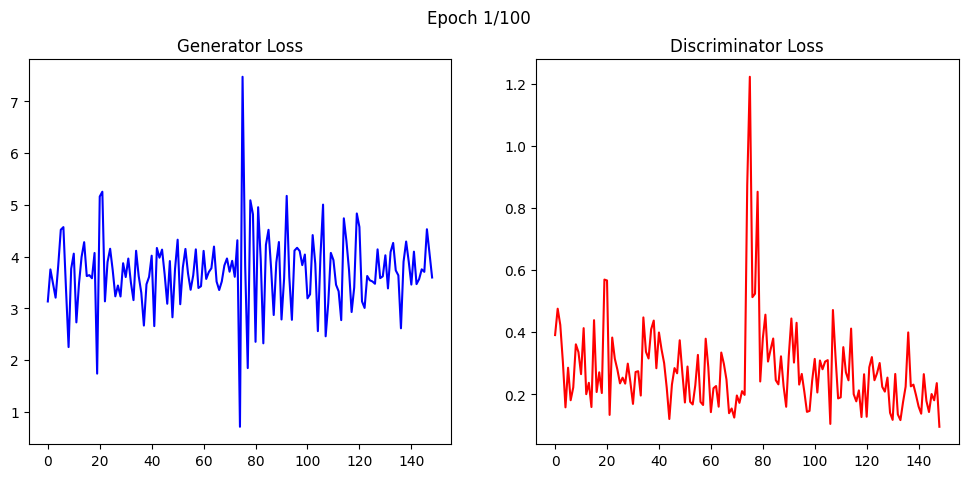

Epoch 2/100: 100%|██████████| 149/149 [00:05<00:00, 25.01it/s]

Epoch 2/100 - Generator Loss: 3.9263, Discriminator Loss: 0.2446


<Figure size 640x480 with 0 Axes>

Epoch 3/100: 100%|██████████| 149/149 [00:05<00:00, 25.66it/s]


Epoch 3/100 - Generator Loss: 3.9516, Discriminator Loss: 0.3893


<Figure size 640x480 with 0 Axes>

Epoch 4/100: 100%|██████████| 149/149 [00:06<00:00, 24.67it/s]


Epoch 4/100 - Generator Loss: 3.9062, Discriminator Loss: 0.3580


<Figure size 640x480 with 0 Axes>

Epoch 5/100: 100%|██████████| 149/149 [00:05<00:00, 25.69it/s]


Epoch 5/100 - Generator Loss: 3.7831, Discriminator Loss: 0.2402


<Figure size 640x480 with 0 Axes>

Epoch 6/100: 100%|██████████| 149/149 [00:05<00:00, 25.33it/s]


Epoch 6/100 - Generator Loss: 3.9435, Discriminator Loss: 0.2165


<Figure size 640x480 with 0 Axes>

Epoch 7/100: 100%|██████████| 149/149 [00:05<00:00, 25.57it/s]


Epoch 7/100 - Generator Loss: 3.9967, Discriminator Loss: 0.2649


<Figure size 640x480 with 0 Axes>

Epoch 8/100: 100%|██████████| 149/149 [00:05<00:00, 25.05it/s]


Epoch 8/100 - Generator Loss: 4.0330, Discriminator Loss: 0.3051


<Figure size 640x480 with 0 Axes>

Epoch 9/100: 100%|██████████| 149/149 [00:05<00:00, 25.55it/s]

Epoch 9/100 - Generator Loss: 3.9293, Discriminator Loss: 0.2271


<Figure size 640x480 with 0 Axes>

Epoch 10/100: 100%|██████████| 149/149 [00:06<00:00, 24.74it/s]

Epoch 10/100 - Generator Loss: 3.9177, Discriminator Loss: 0.6148


<Figure size 640x480 with 0 Axes>

Epoch 11/100: 100%|██████████| 149/149 [00:06<00:00, 24.83it/s]


Epoch 11/100 - Generator Loss: 3.7691, Discriminator Loss: 0.2322


<Figure size 640x480 with 0 Axes>

Epoch 12/100: 100%|██████████| 149/149 [00:05<00:00, 25.52it/s]


Epoch 12/100 - Generator Loss: 3.9353, Discriminator Loss: 0.2347


<Figure size 640x480 with 0 Axes>

Epoch 13/100: 100%|██████████| 149/149 [00:05<00:00, 24.93it/s]

Epoch 13/100 - Generator Loss: 4.0293, Discriminator Loss: 0.2450


<Figure size 640x480 with 0 Axes>

Epoch 14/100: 100%|██████████| 149/149 [00:05<00:00, 25.35it/s]

Epoch 14/100 - Generator Loss: 4.1339, Discriminator Loss: 0.3670


<Figure size 640x480 with 0 Axes>

Epoch 15/100: 100%|██████████| 149/149 [00:05<00:00, 25.18it/s]


Epoch 15/100 - Generator Loss: 3.8068, Discriminator Loss: 0.3299


<Figure size 640x480 with 0 Axes>

Epoch 16/100: 100%|██████████| 149/149 [00:05<00:00, 25.73it/s]


Epoch 16/100 - Generator Loss: 3.9703, Discriminator Loss: 0.2088


<Figure size 640x480 with 0 Axes>

Epoch 17/100: 100%|██████████| 149/149 [00:05<00:00, 25.27it/s]


Epoch 17/100 - Generator Loss: 3.9981, Discriminator Loss: 0.2422


<Figure size 640x480 with 0 Axes>

Epoch 18/100: 100%|██████████| 149/149 [00:05<00:00, 25.12it/s]

Epoch 18/100 - Generator Loss: 4.0570, Discriminator Loss: 0.2239


<Figure size 640x480 with 0 Axes>

Epoch 19/100: 100%|██████████| 149/149 [00:05<00:00, 25.13it/s]

Epoch 19/100 - Generator Loss: 4.0648, Discriminator Loss: 0.5446


<Figure size 640x480 with 0 Axes>

Epoch 20/100: 100%|██████████| 149/149 [00:05<00:00, 24.84it/s]


Epoch 20/100 - Generator Loss: 3.8610, Discriminator Loss: 0.2248


<Figure size 640x480 with 0 Axes>

Epoch 21/100: 100%|██████████| 149/149 [00:05<00:00, 25.42it/s]

Epoch 21/100 - Generator Loss: 3.9946, Discriminator Loss: 0.1945


<Figure size 640x480 with 0 Axes>

Epoch 22/100: 100%|██████████| 149/149 [00:06<00:00, 24.79it/s]


Epoch 22/100 - Generator Loss: 4.1079, Discriminator Loss: 0.1907


<Figure size 640x480 with 0 Axes>

Epoch 23/100: 100%|██████████| 149/149 [00:05<00:00, 25.27it/s]

Epoch 23/100 - Generator Loss: 4.1055, Discriminator Loss: 0.3916


<Figure size 640x480 with 0 Axes>

Epoch 24/100: 100%|██████████| 149/149 [00:05<00:00, 24.93it/s]

Epoch 24/100 - Generator Loss: 4.0456, Discriminator Loss: 0.1926


<Figure size 640x480 with 0 Axes>

Epoch 25/100: 100%|██████████| 149/149 [00:05<00:00, 25.34it/s]

Epoch 25/100 - Generator Loss: 4.0158, Discriminator Loss: 0.3897


<Figure size 640x480 with 0 Axes>

Epoch 26/100: 100%|██████████| 149/149 [00:05<00:00, 25.36it/s]


Epoch 26/100 - Generator Loss: 4.0085, Discriminator Loss: 0.1998


<Figure size 640x480 with 0 Axes>

Epoch 27/100: 100%|██████████| 149/149 [00:05<00:00, 25.01it/s]


Epoch 27/100 - Generator Loss: 4.1247, Discriminator Loss: 0.4229


<Figure size 640x480 with 0 Axes>

Epoch 28/100: 100%|██████████| 149/149 [00:05<00:00, 25.36it/s]


Epoch 28/100 - Generator Loss: 3.9806, Discriminator Loss: 0.2139


<Figure size 640x480 with 0 Axes>

Epoch 29/100: 100%|██████████| 149/149 [00:05<00:00, 24.86it/s]


Epoch 29/100 - Generator Loss: 4.0837, Discriminator Loss: 0.1914


<Figure size 640x480 with 0 Axes>

Epoch 30/100: 100%|██████████| 149/149 [00:05<00:00, 25.50it/s]


Epoch 30/100 - Generator Loss: 4.1348, Discriminator Loss: 0.1866


<Figure size 640x480 with 0 Axes>

Epoch 31/100: 100%|██████████| 149/149 [00:06<00:00, 24.36it/s]

Epoch 31/100 - Generator Loss: 3.7550, Discriminator Loss: 0.1319


<Figure size 640x480 with 0 Axes>

Epoch 32/100: 100%|██████████| 149/149 [00:05<00:00, 25.39it/s]


Epoch 32/100 - Generator Loss: 3.7569, Discriminator Loss: 0.1258


<Figure size 640x480 with 0 Axes>

Epoch 33/100: 100%|██████████| 149/149 [00:05<00:00, 24.91it/s]


Epoch 33/100 - Generator Loss: 3.7671, Discriminator Loss: 0.1228


<Figure size 640x480 with 0 Axes>

Epoch 34/100: 100%|██████████| 149/149 [00:05<00:00, 25.01it/s]

Epoch 34/100 - Generator Loss: 3.7481, Discriminator Loss: 0.1260


<Figure size 640x480 with 0 Axes>

Epoch 35/100: 100%|██████████| 149/149 [00:05<00:00, 25.35it/s]


Epoch 35/100 - Generator Loss: 3.7722, Discriminator Loss: 0.1193


<Figure size 640x480 with 0 Axes>

Epoch 36/100: 100%|██████████| 149/149 [00:06<00:00, 24.37it/s]

Epoch 36/100 - Generator Loss: 3.8382, Discriminator Loss: 0.1160


<Figure size 640x480 with 0 Axes>

Epoch 37/100: 100%|██████████| 149/149 [00:05<00:00, 25.85it/s]


Epoch 37/100 - Generator Loss: 3.8022, Discriminator Loss: 0.1177


<Figure size 640x480 with 0 Axes>

Epoch 38/100: 100%|██████████| 149/149 [00:06<00:00, 24.75it/s]


Epoch 38/100 - Generator Loss: 3.8278, Discriminator Loss: 0.1152


<Figure size 640x480 with 0 Axes>

Epoch 39/100: 100%|██████████| 149/149 [00:05<00:00, 25.24it/s]


Epoch 39/100 - Generator Loss: 3.8417, Discriminator Loss: 0.1175


<Figure size 640x480 with 0 Axes>

Epoch 40/100: 100%|██████████| 149/149 [00:06<00:00, 24.53it/s]


Epoch 40/100 - Generator Loss: 3.8554, Discriminator Loss: 0.1134


<Figure size 640x480 with 0 Axes>

Epoch 41/100: 100%|██████████| 149/149 [00:05<00:00, 25.05it/s]

Epoch 41/100 - Generator Loss: 3.8536, Discriminator Loss: 0.1147


<Figure size 640x480 with 0 Axes>

Epoch 42/100: 100%|██████████| 149/149 [00:05<00:00, 24.94it/s]

Epoch 42/100 - Generator Loss: 3.8888, Discriminator Loss: 0.1114


<Figure size 640x480 with 0 Axes>

Epoch 43/100: 100%|██████████| 149/149 [00:06<00:00, 24.80it/s]


Epoch 43/100 - Generator Loss: 3.9376, Discriminator Loss: 0.1093


<Figure size 640x480 with 0 Axes>

Epoch 44/100: 100%|██████████| 149/149 [00:05<00:00, 25.33it/s]


Epoch 44/100 - Generator Loss: 3.8730, Discriminator Loss: 0.1112


<Figure size 640x480 with 0 Axes>

Epoch 45/100: 100%|██████████| 149/149 [00:05<00:00, 24.93it/s]


Epoch 45/100 - Generator Loss: 3.9367, Discriminator Loss: 0.1062


<Figure size 640x480 with 0 Axes>

Epoch 46/100: 100%|██████████| 149/149 [00:05<00:00, 25.57it/s]


Epoch 46/100 - Generator Loss: 3.9668, Discriminator Loss: 0.1052


<Figure size 640x480 with 0 Axes>

Epoch 47/100: 100%|██████████| 149/149 [00:06<00:00, 24.75it/s]


Epoch 47/100 - Generator Loss: 3.9758, Discriminator Loss: 0.1064


<Figure size 640x480 with 0 Axes>

Epoch 48/100: 100%|██████████| 149/149 [00:05<00:00, 25.09it/s]

Epoch 48/100 - Generator Loss: 3.9733, Discriminator Loss: 0.1047


<Figure size 640x480 with 0 Axes>

Epoch 49/100: 100%|██████████| 149/149 [00:06<00:00, 24.57it/s]

Epoch 49/100 - Generator Loss: 3.9908, Discriminator Loss: 0.1051


<Figure size 640x480 with 0 Axes>

Epoch 50/100: 100%|██████████| 149/149 [00:06<00:00, 24.50it/s]

Epoch 50/100 - Generator Loss: 4.0189, Discriminator Loss: 0.1016


<Figure size 640x480 with 0 Axes>

Epoch 51/100: 100%|██████████| 149/149 [00:05<00:00, 25.61it/s]


Epoch 51/100 - Generator Loss: 4.0537, Discriminator Loss: 0.0988


<Figure size 640x480 with 0 Axes>

Epoch 52/100: 100%|██████████| 149/149 [00:06<00:00, 24.72it/s]


Epoch 52/100 - Generator Loss: 4.0718, Discriminator Loss: 0.1007


<Figure size 640x480 with 0 Axes>

Epoch 53/100: 100%|██████████| 149/149 [00:05<00:00, 25.30it/s]


Epoch 53/100 - Generator Loss: 4.0569, Discriminator Loss: 0.0994


<Figure size 640x480 with 0 Axes>

Epoch 54/100: 100%|██████████| 149/149 [00:06<00:00, 24.54it/s]


Epoch 54/100 - Generator Loss: 4.0937, Discriminator Loss: 0.0994


<Figure size 640x480 with 0 Axes>

Epoch 55/100: 100%|██████████| 149/149 [00:05<00:00, 25.58it/s]

Epoch 55/100 - Generator Loss: 4.0870, Discriminator Loss: 0.0978


<Figure size 640x480 with 0 Axes>

Epoch 56/100: 100%|██████████| 149/149 [00:06<00:00, 24.63it/s]

Epoch 56/100 - Generator Loss: 4.1097, Discriminator Loss: 0.0965


<Figure size 640x480 with 0 Axes>

Epoch 57/100: 100%|██████████| 149/149 [00:05<00:00, 25.37it/s]


Epoch 57/100 - Generator Loss: 4.0832, Discriminator Loss: 0.0990


<Figure size 640x480 with 0 Axes>

Epoch 58/100: 100%|██████████| 149/149 [00:05<00:00, 24.87it/s]


Epoch 58/100 - Generator Loss: 4.1292, Discriminator Loss: 0.0951


<Figure size 640x480 with 0 Axes>

Epoch 59/100: 100%|██████████| 149/149 [00:06<00:00, 24.73it/s]


Epoch 59/100 - Generator Loss: 4.1495, Discriminator Loss: 0.0932


<Figure size 640x480 with 0 Axes>

Epoch 60/100: 100%|██████████| 149/149 [00:05<00:00, 25.34it/s]


Epoch 60/100 - Generator Loss: 4.1555, Discriminator Loss: 0.0918


<Figure size 640x480 with 0 Axes>

Epoch 61/100: 100%|██████████| 149/149 [00:06<00:00, 24.57it/s]


Epoch 61/100 - Generator Loss: 4.1182, Discriminator Loss: 0.0891


<Figure size 640x480 with 0 Axes>

Epoch 62/100: 100%|██████████| 149/149 [00:05<00:00, 25.29it/s]


Epoch 62/100 - Generator Loss: 4.1395, Discriminator Loss: 0.0864


<Figure size 640x480 with 0 Axes>

Epoch 63/100: 100%|██████████| 149/149 [00:06<00:00, 24.60it/s]


Epoch 63/100 - Generator Loss: 4.1550, Discriminator Loss: 0.0858


<Figure size 640x480 with 0 Axes>

Epoch 64/100: 100%|██████████| 149/149 [00:05<00:00, 25.30it/s]


Epoch 64/100 - Generator Loss: 4.1488, Discriminator Loss: 0.0882


<Figure size 640x480 with 0 Axes>

Epoch 65/100: 100%|██████████| 149/149 [00:06<00:00, 24.75it/s]


Epoch 65/100 - Generator Loss: 4.1594, Discriminator Loss: 0.0842


<Figure size 640x480 with 0 Axes>

Epoch 66/100: 100%|██████████| 149/149 [00:06<00:00, 24.71it/s]

Epoch 66/100 - Generator Loss: 4.1589, Discriminator Loss: 0.0866


<Figure size 640x480 with 0 Axes>

Epoch 67/100: 100%|██████████| 149/149 [00:05<00:00, 25.38it/s]

Epoch 67/100 - Generator Loss: 4.1558, Discriminator Loss: 0.0865


<Figure size 640x480 with 0 Axes>

Epoch 68/100: 100%|██████████| 149/149 [00:06<00:00, 24.82it/s]


Epoch 68/100 - Generator Loss: 4.1607, Discriminator Loss: 0.0863


<Figure size 640x480 with 0 Axes>

Epoch 69/100: 100%|██████████| 149/149 [00:05<00:00, 25.30it/s]


Epoch 69/100 - Generator Loss: 4.1616, Discriminator Loss: 0.0851


<Figure size 640x480 with 0 Axes>

Epoch 70/100: 100%|██████████| 149/149 [00:06<00:00, 24.42it/s]


Epoch 70/100 - Generator Loss: 4.1743, Discriminator Loss: 0.0836


<Figure size 640x480 with 0 Axes>

Epoch 71/100: 100%|██████████| 149/149 [00:05<00:00, 25.20it/s]


Epoch 71/100 - Generator Loss: 4.1371, Discriminator Loss: 0.0862


<Figure size 640x480 with 0 Axes>

Epoch 72/100: 100%|██████████| 149/149 [00:06<00:00, 24.71it/s]

Epoch 72/100 - Generator Loss: 4.1969, Discriminator Loss: 0.0827


<Figure size 640x480 with 0 Axes>

Epoch 73/100: 100%|██████████| 149/149 [00:06<00:00, 24.70it/s]

Epoch 73/100 - Generator Loss: 4.1619, Discriminator Loss: 0.0832


<Figure size 640x480 with 0 Axes>

Epoch 74/100: 100%|██████████| 149/149 [00:05<00:00, 25.34it/s]

Epoch 74/100 - Generator Loss: 4.1393, Discriminator Loss: 0.0856


<Figure size 640x480 with 0 Axes>

Epoch 75/100: 100%|██████████| 149/149 [00:05<00:00, 24.88it/s]


Epoch 75/100 - Generator Loss: 4.1548, Discriminator Loss: 0.0855


<Figure size 640x480 with 0 Axes>

Epoch 76/100: 100%|██████████| 149/149 [00:05<00:00, 25.22it/s]

Epoch 76/100 - Generator Loss: 4.1886, Discriminator Loss: 0.0840


<Figure size 640x480 with 0 Axes>

Epoch 77/100: 100%|██████████| 149/149 [00:05<00:00, 24.98it/s]

Epoch 77/100 - Generator Loss: 4.1787, Discriminator Loss: 0.0829


<Figure size 640x480 with 0 Axes>

Epoch 78/100: 100%|██████████| 149/149 [00:05<00:00, 25.33it/s]

Epoch 78/100 - Generator Loss: 4.1704, Discriminator Loss: 0.0850


<Figure size 640x480 with 0 Axes>

Epoch 79/100: 100%|██████████| 149/149 [00:06<00:00, 24.06it/s]

Epoch 79/100 - Generator Loss: 4.1903, Discriminator Loss: 0.0830


<Figure size 640x480 with 0 Axes>

Epoch 80/100: 100%|██████████| 149/149 [00:05<00:00, 25.14it/s]


Epoch 80/100 - Generator Loss: 4.1979, Discriminator Loss: 0.0809


<Figure size 640x480 with 0 Axes>

Epoch 81/100: 100%|██████████| 149/149 [00:05<00:00, 24.99it/s]


Epoch 81/100 - Generator Loss: 4.1710, Discriminator Loss: 0.0830


<Figure size 640x480 with 0 Axes>

Epoch 82/100: 100%|██████████| 149/149 [00:06<00:00, 24.81it/s]


Epoch 82/100 - Generator Loss: 4.2319, Discriminator Loss: 0.0794


<Figure size 640x480 with 0 Axes>

Epoch 83/100: 100%|██████████| 149/149 [00:05<00:00, 25.48it/s]

Epoch 83/100 - Generator Loss: 4.1782, Discriminator Loss: 0.0841


<Figure size 640x480 with 0 Axes>

Epoch 84/100: 100%|██████████| 149/149 [00:06<00:00, 24.67it/s]


Epoch 84/100 - Generator Loss: 4.1606, Discriminator Loss: 0.0850


<Figure size 640x480 with 0 Axes>

Epoch 85/100: 100%|██████████| 149/149 [00:05<00:00, 25.50it/s]


Epoch 85/100 - Generator Loss: 4.1861, Discriminator Loss: 0.0839


<Figure size 640x480 with 0 Axes>

Epoch 86/100: 100%|██████████| 149/149 [00:06<00:00, 24.78it/s]


Epoch 86/100 - Generator Loss: 4.2187, Discriminator Loss: 0.0790


<Figure size 640x480 with 0 Axes>

Epoch 87/100: 100%|██████████| 149/149 [00:05<00:00, 25.49it/s]

Epoch 87/100 - Generator Loss: 4.2295, Discriminator Loss: 0.0805


<Figure size 640x480 with 0 Axes>

Epoch 88/100: 100%|██████████| 149/149 [00:06<00:00, 24.55it/s]

Epoch 88/100 - Generator Loss: 4.1605, Discriminator Loss: 0.0846


<Figure size 640x480 with 0 Axes>

Epoch 89/100: 100%|██████████| 149/149 [00:05<00:00, 24.95it/s]

Epoch 89/100 - Generator Loss: 4.2445, Discriminator Loss: 0.0799


<Figure size 640x480 with 0 Axes>

Epoch 90/100: 100%|██████████| 149/149 [00:05<00:00, 25.02it/s]

Epoch 90/100 - Generator Loss: 4.2303, Discriminator Loss: 0.0807


<Figure size 640x480 with 0 Axes>

Epoch 91/100: 100%|██████████| 149/149 [00:06<00:00, 24.41it/s]


Epoch 91/100 - Generator Loss: 4.1718, Discriminator Loss: 0.0801


<Figure size 640x480 with 0 Axes>

Epoch 92/100: 100%|██████████| 149/149 [00:05<00:00, 25.30it/s]


Epoch 92/100 - Generator Loss: 4.1834, Discriminator Loss: 0.0810


<Figure size 640x480 with 0 Axes>

Epoch 93/100: 100%|██████████| 149/149 [00:06<00:00, 24.60it/s]

Epoch 93/100 - Generator Loss: 4.2101, Discriminator Loss: 0.0812


<Figure size 640x480 with 0 Axes>

Epoch 94/100: 100%|██████████| 149/149 [00:05<00:00, 25.69it/s]


Epoch 94/100 - Generator Loss: 4.2053, Discriminator Loss: 0.0818


<Figure size 640x480 with 0 Axes>

Epoch 95/100: 100%|██████████| 149/149 [00:06<00:00, 24.78it/s]

Epoch 95/100 - Generator Loss: 4.2120, Discriminator Loss: 0.0803


<Figure size 640x480 with 0 Axes>

Epoch 96/100: 100%|██████████| 149/149 [00:05<00:00, 25.34it/s]

Epoch 96/100 - Generator Loss: 4.1571, Discriminator Loss: 0.0845


<Figure size 640x480 with 0 Axes>

Epoch 97/100: 100%|██████████| 149/149 [00:06<00:00, 24.19it/s]

Epoch 97/100 - Generator Loss: 4.1876, Discriminator Loss: 0.0826


<Figure size 640x480 with 0 Axes>

Epoch 98/100: 100%|██████████| 149/149 [00:06<00:00, 24.52it/s]


Epoch 98/100 - Generator Loss: 4.2291, Discriminator Loss: 0.0804


<Figure size 640x480 with 0 Axes>

Epoch 99/100: 100%|██████████| 149/149 [00:05<00:00, 25.04it/s]

Epoch 99/100 - Generator Loss: 4.2290, Discriminator Loss: 0.0821


<Figure size 640x480 with 0 Axes>

Epoch 100/100: 100%|██████████| 149/149 [00:06<00:00, 24.37it/s]


Epoch 100/100 - Generator Loss: 4.2683, Discriminator Loss: 0.0769


<Figure size 640x480 with 0 Axes>


Final Epoch Losses:
Epoch 1: G_loss=3.7076, D_loss=0.2787
Epoch 2: G_loss=3.9263, D_loss=0.2446
Epoch 3: G_loss=3.9516, D_loss=0.3893
Epoch 4: G_loss=3.9062, D_loss=0.3580
Epoch 5: G_loss=3.7831, D_loss=0.2402
Epoch 6: G_loss=3.9435, D_loss=0.2165
Epoch 7: G_loss=3.9967, D_loss=0.2649
Epoch 8: G_loss=4.0330, D_loss=0.3051
Epoch 9: G_loss=3.9293, D_loss=0.2271
Epoch 10: G_loss=3.9177, D_loss=0.6148
Epoch 11: G_loss=3.7691, D_loss=0.2322
Epoch 12: G_loss=3.9353, D_loss=0.2347
Epoch 13: G_loss=4.0293, D_loss=0.2450
Epoch 14: G_loss=4.1339, D_loss=0.3670
Epoch 15: G_loss=3.8068, D_loss=0.3299
Epoch 16: G_loss=3.9703, D_loss=0.2088
Epoch 17: G_loss=3.9981, D_loss=0.2422
Epoch 18: G_loss=4.0570, D_loss=0.2239
Epoch 19: G_loss=4.0648, D_loss=0.5446
Epoch 20: G_loss=3.8610, D_loss=0.2248
Epoch 21: G_loss=3.9946, D_loss=0.1945
Epoch 22: G_loss=4.1079, D_loss=0.1907
Epoch 23: G_loss=4.1055, D_loss=0.3916
Epoch 24: G_loss=4.0456, D_loss=0.1926
Epoch 25: G_loss=4.0158, D_loss=0.3897
Epoch 26: G_l

In [7]:
losses_G = []
losses_D = []
epoch_losses_G = []
epoch_losses_D = []
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for epoch in range(num_epochs):
    epoch_loss_G = 0.0
    epoch_loss_D = 0.0
    num_batches = 0
    
    for real_images, real_labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Проверка данных
        if real_images is None or real_labels is None:
            raise ValueError("DataLoader вернул None!")
        
        real_images = real_images.to(device)
        real_labels = real_labels.to(device)
        batch_size_curr = real_images.size(0)

        # Метки для реальных и фейковых изображений
        labels_real = torch.full((batch_size_curr,), 1.0, device=device)
        labels_fake = torch.full((batch_size_curr,), 0.0, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()
        
        # Реальные изображения
        output_real = D(real_images, real_labels)
        loss_D_real = criterion(output_real, labels_real)
        
        # Фейковые изображения
        noise = torch.randn(batch_size_curr, latent_dim, device=device)
        fake_labels = torch.randint(0, num_classes, (batch_size_curr,), device=device)
        fake_images = G(noise, fake_labels)
        
        output_fake = D(fake_images.detach(), fake_labels)
        loss_D_fake = criterion(output_fake, labels_fake)
        
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        output_fake_for_G = D(fake_images, fake_labels)
        loss_G = criterion(output_fake_for_G, labels_real)
        loss_G.backward()
        optimizer_G.step()

        # Логирование
        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())
        epoch_loss_G += loss_G.item()
        epoch_loss_D += loss_D.item()
        num_batches += 1
    
    # Средние loss за эпоху
    avg_loss_G = epoch_loss_G / num_batches
    avg_loss_D = epoch_loss_D / num_batches
    epoch_losses_G.append(avg_loss_G)
    epoch_losses_D.append(avg_loss_D)
    
    # Вывод loss текущей эпохи
    print(f"Epoch {epoch+1}/{num_epochs} - Generator Loss: {avg_loss_G:.4f}, Discriminator Loss: {avg_loss_D:.4f}")
    
    # Визуализация
    ax1.clear()
    ax1.plot(losses_G, label="Generator Loss", color='blue')
    ax1.set_title("Generator Loss")
    
    ax2.clear()
    ax2.plot(losses_D, label="Discriminator Loss", color='red')
    ax2.set_title("Discriminator Loss")
    
    plt.suptitle(f"Epoch {epoch+1}/{num_epochs}")
    plt.pause(0.1)
    
    # Обновление learning rate
    scheduler_G.step()
    scheduler_D.step()

plt.ioff()
plt.show()

# Вывод итоговых loss по эпохам
print("\nFinal Epoch Losses:")
for epoch, (loss_G, loss_D) in enumerate(zip(epoch_losses_G, epoch_losses_D)):
    print(f"Epoch {epoch+1}: G_loss={loss_G:.4f}, D_loss={loss_D:.4f}")

Epoch 1/100: 100%|██████████| 149/149 [00:05<00:00, 25.46it/s]


New best Generator saved with loss: 5.0958
New best Discriminator saved with loss: 0.3278
Epoch 1/100 - Generator Loss: 5.0958, Discriminator Loss: 0.3278


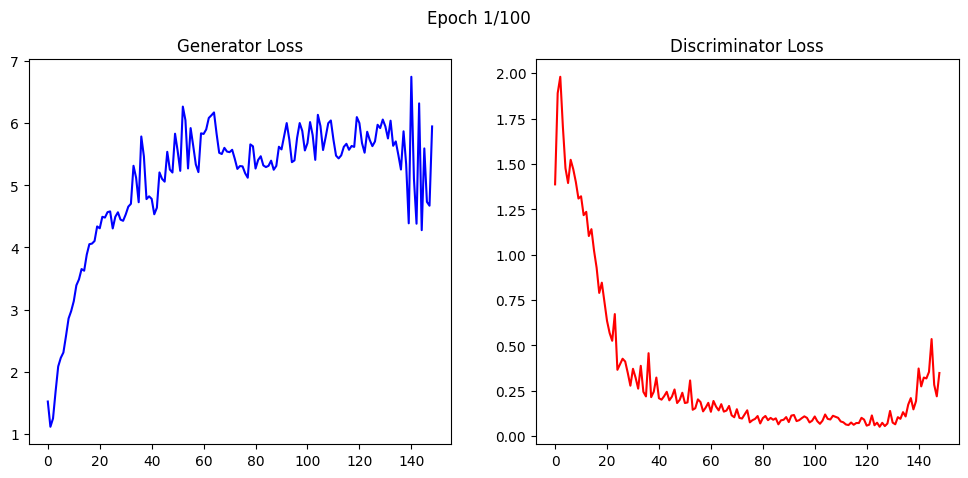

Epoch 2/100: 100%|██████████| 149/149 [00:06<00:00, 24.59it/s]


New best Generator saved with loss: 3.3703
Epoch 2/100 - Generator Loss: 3.3703, Discriminator Loss: 0.6023


<Figure size 640x480 with 0 Axes>

Epoch 3/100: 100%|██████████| 149/149 [00:06<00:00, 24.65it/s]


New best Generator saved with loss: 3.3041
Epoch 3/100 - Generator Loss: 3.3041, Discriminator Loss: 0.5774


<Figure size 640x480 with 0 Axes>

Epoch 4/100: 100%|██████████| 149/149 [00:05<00:00, 25.22it/s]


New best Generator saved with loss: 3.0659
Epoch 4/100 - Generator Loss: 3.0659, Discriminator Loss: 0.5989


<Figure size 640x480 with 0 Axes>

Epoch 5/100: 100%|██████████| 149/149 [00:06<00:00, 24.67it/s]

Epoch 5/100 - Generator Loss: 3.4592, Discriminator Loss: 0.4838


<Figure size 640x480 with 0 Axes>

Epoch 6/100: 100%|██████████| 149/149 [00:05<00:00, 25.34it/s]


Epoch 6/100 - Generator Loss: 3.1044, Discriminator Loss: 0.5973


<Figure size 640x480 with 0 Axes>

Epoch 7/100: 100%|██████████| 149/149 [00:06<00:00, 24.59it/s]


New best Generator saved with loss: 2.9469
Epoch 7/100 - Generator Loss: 2.9469, Discriminator Loss: 0.6067


<Figure size 640x480 with 0 Axes>

Epoch 8/100: 100%|██████████| 149/149 [00:05<00:00, 25.02it/s]


New best Generator saved with loss: 2.8836
Epoch 8/100 - Generator Loss: 2.8836, Discriminator Loss: 0.6666


<Figure size 640x480 with 0 Axes>

Epoch 9/100: 100%|██████████| 149/149 [00:06<00:00, 23.98it/s]

Epoch 9/100 - Generator Loss: 3.0880, Discriminator Loss: 0.5336


<Figure size 640x480 with 0 Axes>

Epoch 10/100: 100%|██████████| 149/149 [00:06<00:00, 24.26it/s]


Epoch 10/100 - Generator Loss: 3.2624, Discriminator Loss: 0.4521


<Figure size 640x480 with 0 Axes>

Epoch 11/100: 100%|██████████| 149/149 [00:05<00:00, 24.95it/s]


New best Generator saved with loss: 2.7244
Epoch 11/100 - Generator Loss: 2.7244, Discriminator Loss: 0.6796


<Figure size 640x480 with 0 Axes>

Epoch 12/100: 100%|██████████| 149/149 [00:06<00:00, 24.82it/s]


New best Generator saved with loss: 2.6491
Epoch 12/100 - Generator Loss: 2.6491, Discriminator Loss: 0.5492


<Figure size 640x480 with 0 Axes>

Epoch 13/100: 100%|██████████| 149/149 [00:05<00:00, 25.39it/s]


Epoch 13/100 - Generator Loss: 2.8160, Discriminator Loss: 0.5655


<Figure size 640x480 with 0 Axes>

Epoch 14/100: 100%|██████████| 149/149 [00:06<00:00, 24.78it/s]

Epoch 14/100 - Generator Loss: 2.8908, Discriminator Loss: 0.5943


<Figure size 640x480 with 0 Axes>

Epoch 15/100: 100%|██████████| 149/149 [00:05<00:00, 25.15it/s]

Epoch 15/100 - Generator Loss: 2.9285, Discriminator Loss: 0.5424


<Figure size 640x480 with 0 Axes>

Epoch 16/100: 100%|██████████| 149/149 [00:06<00:00, 24.83it/s]

Epoch 16/100 - Generator Loss: 3.1061, Discriminator Loss: 0.4998


<Figure size 640x480 with 0 Axes>

Epoch 17/100: 100%|██████████| 149/149 [00:06<00:00, 24.41it/s]


New best Generator saved with loss: 2.6219
Epoch 17/100 - Generator Loss: 2.6219, Discriminator Loss: 0.6641


<Figure size 640x480 with 0 Axes>

Epoch 18/100: 100%|██████████| 149/149 [00:06<00:00, 24.61it/s]

Epoch 18/100 - Generator Loss: 3.0860, Discriminator Loss: 0.4876


<Figure size 640x480 with 0 Axes>

Epoch 19/100: 100%|██████████| 149/149 [00:06<00:00, 24.53it/s]

Epoch 19/100 - Generator Loss: 3.1237, Discriminator Loss: 0.4273


<Figure size 640x480 with 0 Axes>

Epoch 20/100: 100%|██████████| 149/149 [00:05<00:00, 24.91it/s]


Epoch 20/100 - Generator Loss: 3.0953, Discriminator Loss: 0.5266


<Figure size 640x480 with 0 Axes>

Epoch 21/100: 100%|██████████| 149/149 [00:06<00:00, 24.53it/s]


Epoch 21/100 - Generator Loss: 2.9596, Discriminator Loss: 0.6169


<Figure size 640x480 with 0 Axes>

Epoch 22/100: 100%|██████████| 149/149 [00:06<00:00, 24.52it/s]


Epoch 22/100 - Generator Loss: 3.0989, Discriminator Loss: 0.5278


<Figure size 640x480 with 0 Axes>

Epoch 23/100: 100%|██████████| 149/149 [00:05<00:00, 25.21it/s]


Epoch 23/100 - Generator Loss: 2.7487, Discriminator Loss: 0.5676


<Figure size 640x480 with 0 Axes>

Epoch 24/100: 100%|██████████| 149/149 [00:06<00:00, 24.57it/s]


Epoch 24/100 - Generator Loss: 3.1677, Discriminator Loss: 0.3787


<Figure size 640x480 with 0 Axes>

Epoch 25/100: 100%|██████████| 149/149 [00:05<00:00, 25.31it/s]


Epoch 25/100 - Generator Loss: 3.0962, Discriminator Loss: 0.5919


<Figure size 640x480 with 0 Axes>

Epoch 26/100: 100%|██████████| 149/149 [00:06<00:00, 24.07it/s]


Epoch 26/100 - Generator Loss: 3.1089, Discriminator Loss: 0.3630


<Figure size 640x480 with 0 Axes>

Epoch 27/100: 100%|██████████| 149/149 [00:06<00:00, 24.83it/s]


Epoch 27/100 - Generator Loss: 3.1744, Discriminator Loss: 0.5433


<Figure size 640x480 with 0 Axes>

Epoch 28/100: 100%|██████████| 149/149 [00:06<00:00, 23.90it/s]

Epoch 28/100 - Generator Loss: 2.9741, Discriminator Loss: 0.4047


<Figure size 640x480 with 0 Axes>

Epoch 29/100: 100%|██████████| 149/149 [00:06<00:00, 24.33it/s]

Epoch 29/100 - Generator Loss: 3.0065, Discriminator Loss: 0.5112


<Figure size 640x480 with 0 Axes>

Epoch 30/100: 100%|██████████| 149/149 [00:05<00:00, 25.16it/s]

Epoch 30/100 - Generator Loss: 3.2086, Discriminator Loss: 0.4815


<Figure size 640x480 with 0 Axes>

Epoch 31/100: 100%|██████████| 149/149 [00:06<00:00, 24.48it/s]


New best Generator saved with loss: 2.1744
Epoch 31/100 - Generator Loss: 2.1744, Discriminator Loss: 0.4125


<Figure size 640x480 with 0 Axes>

Epoch 32/100: 100%|██████████| 149/149 [00:05<00:00, 24.92it/s]


Epoch 32/100 - Generator Loss: 2.1840, Discriminator Loss: 0.3676


<Figure size 640x480 with 0 Axes>

Epoch 33/100: 100%|██████████| 149/149 [00:06<00:00, 24.38it/s]


Epoch 33/100 - Generator Loss: 2.1992, Discriminator Loss: 0.3542


<Figure size 640x480 with 0 Axes>

Epoch 34/100: 100%|██████████| 149/149 [00:06<00:00, 24.82it/s]

Epoch 34/100 - Generator Loss: 2.1906, Discriminator Loss: 0.3471


<Figure size 640x480 with 0 Axes>

Epoch 35/100: 100%|██████████| 149/149 [00:06<00:00, 24.70it/s]


Epoch 35/100 - Generator Loss: 2.2398, Discriminator Loss: 0.3373


<Figure size 640x480 with 0 Axes>

Epoch 36/100: 100%|██████████| 149/149 [00:06<00:00, 24.06it/s]


Epoch 36/100 - Generator Loss: 2.2731, Discriminator Loss: 0.3288


<Figure size 640x480 with 0 Axes>

Epoch 37/100: 100%|██████████| 149/149 [00:05<00:00, 25.07it/s]

New best Discriminator saved with loss: 0.3259
Epoch 37/100 - Generator Loss: 2.2770, Discriminator Loss: 0.3259


<Figure size 640x480 with 0 Axes>

Epoch 38/100: 100%|██████████| 149/149 [00:06<00:00, 24.15it/s]


New best Discriminator saved with loss: 0.3171
Epoch 38/100 - Generator Loss: 2.2975, Discriminator Loss: 0.3171


<Figure size 640x480 with 0 Axes>

Epoch 39/100: 100%|██████████| 149/149 [00:05<00:00, 24.92it/s]


New best Discriminator saved with loss: 0.3092
Epoch 39/100 - Generator Loss: 2.3215, Discriminator Loss: 0.3092


<Figure size 640x480 with 0 Axes>

Epoch 40/100: 100%|██████████| 149/149 [00:06<00:00, 24.52it/s]


New best Discriminator saved with loss: 0.3010
Epoch 40/100 - Generator Loss: 2.3493, Discriminator Loss: 0.3010


<Figure size 640x480 with 0 Axes>

Epoch 41/100: 100%|██████████| 149/149 [00:05<00:00, 25.13it/s]

Epoch 41/100 - Generator Loss: 2.3624, Discriminator Loss: 0.3018


<Figure size 640x480 with 0 Axes>

Epoch 42/100: 100%|██████████| 149/149 [00:06<00:00, 24.64it/s]


New best Discriminator saved with loss: 0.3003
Epoch 42/100 - Generator Loss: 2.3742, Discriminator Loss: 0.3003


<Figure size 640x480 with 0 Axes>

Epoch 43/100: 100%|██████████| 149/149 [00:06<00:00, 24.44it/s]

New best Discriminator saved with loss: 0.2914
Epoch 43/100 - Generator Loss: 2.4139, Discriminator Loss: 0.2914


<Figure size 640x480 with 0 Axes>

Epoch 44/100: 100%|██████████| 149/149 [00:05<00:00, 25.06it/s]

New best Discriminator saved with loss: 0.2809
Epoch 44/100 - Generator Loss: 2.4379, Discriminator Loss: 0.2809


<Figure size 640x480 with 0 Axes>

Epoch 45/100: 100%|██████████| 149/149 [00:06<00:00, 24.45it/s]

Epoch 45/100 - Generator Loss: 2.4429, Discriminator Loss: 0.2848


<Figure size 640x480 with 0 Axes>

Epoch 46/100: 100%|██████████| 149/149 [00:05<00:00, 25.14it/s]

New best Discriminator saved with loss: 0.2670
Epoch 46/100 - Generator Loss: 2.5202, Discriminator Loss: 0.2670


<Figure size 640x480 with 0 Axes>

Epoch 47/100: 100%|██████████| 149/149 [00:06<00:00, 24.23it/s]


Epoch 47/100 - Generator Loss: 2.5098, Discriminator Loss: 0.2749


<Figure size 640x480 with 0 Axes>

Epoch 48/100: 100%|██████████| 149/149 [00:05<00:00, 25.19it/s]

Epoch 48/100 - Generator Loss: 2.5058, Discriminator Loss: 0.2721


<Figure size 640x480 with 0 Axes>

Epoch 49/100: 100%|██████████| 149/149 [00:06<00:00, 24.75it/s]


New best Discriminator saved with loss: 0.2604
Epoch 49/100 - Generator Loss: 2.5487, Discriminator Loss: 0.2604


<Figure size 640x480 with 0 Axes>

Epoch 50/100: 100%|██████████| 149/149 [00:05<00:00, 24.84it/s]


New best Discriminator saved with loss: 0.2545
Epoch 50/100 - Generator Loss: 2.5788, Discriminator Loss: 0.2545


<Figure size 640x480 with 0 Axes>

Epoch 51/100: 100%|██████████| 149/149 [00:05<00:00, 25.06it/s]

New best Discriminator saved with loss: 0.2508
Epoch 51/100 - Generator Loss: 2.6187, Discriminator Loss: 0.2508


<Figure size 640x480 with 0 Axes>

Epoch 52/100: 100%|██████████| 149/149 [00:06<00:00, 24.80it/s]

New best Discriminator saved with loss: 0.2436
Epoch 52/100 - Generator Loss: 2.6296, Discriminator Loss: 0.2436


<Figure size 640x480 with 0 Axes>

Epoch 53/100: 100%|██████████| 149/149 [00:05<00:00, 25.16it/s]


Epoch 53/100 - Generator Loss: 2.6544, Discriminator Loss: 0.2440


<Figure size 640x480 with 0 Axes>

Epoch 54/100: 100%|██████████| 149/149 [00:06<00:00, 24.52it/s]

New best Discriminator saved with loss: 0.2325
Epoch 54/100 - Generator Loss: 2.7011, Discriminator Loss: 0.2325


<Figure size 640x480 with 0 Axes>

Epoch 55/100: 100%|██████████| 149/149 [00:05<00:00, 24.96it/s]

New best Discriminator saved with loss: 0.2268
Epoch 55/100 - Generator Loss: 2.7166, Discriminator Loss: 0.2268


<Figure size 640x480 with 0 Axes>

Epoch 56/100: 100%|██████████| 149/149 [00:06<00:00, 24.48it/s]

New best Discriminator saved with loss: 0.2245
Epoch 56/100 - Generator Loss: 2.7393, Discriminator Loss: 0.2245


<Figure size 640x480 with 0 Axes>

Epoch 57/100: 100%|██████████| 149/149 [00:06<00:00, 23.95it/s]


Epoch 57/100 - Generator Loss: 2.7537, Discriminator Loss: 0.2281


<Figure size 640x480 with 0 Axes>

Epoch 58/100: 100%|██████████| 149/149 [00:05<00:00, 25.05it/s]


New best Discriminator saved with loss: 0.2183
Epoch 58/100 - Generator Loss: 2.7890, Discriminator Loss: 0.2183


<Figure size 640x480 with 0 Axes>

Epoch 59/100: 100%|██████████| 149/149 [00:06<00:00, 24.64it/s]


New best Discriminator saved with loss: 0.2169
Epoch 59/100 - Generator Loss: 2.7962, Discriminator Loss: 0.2169


<Figure size 640x480 with 0 Axes>

Epoch 60/100: 100%|██████████| 149/149 [00:05<00:00, 25.15it/s]

Epoch 60/100 - Generator Loss: 2.7997, Discriminator Loss: 0.2177


<Figure size 640x480 with 0 Axes>

Epoch 61/100: 100%|██████████| 149/149 [00:06<00:00, 24.09it/s]


New best Discriminator saved with loss: 0.2024
Epoch 61/100 - Generator Loss: 2.7942, Discriminator Loss: 0.2024


<Figure size 640x480 with 0 Axes>

Epoch 62/100: 100%|██████████| 149/149 [00:05<00:00, 25.19it/s]

New best Discriminator saved with loss: 0.2014
Epoch 62/100 - Generator Loss: 2.7808, Discriminator Loss: 0.2014


<Figure size 640x480 with 0 Axes>

Epoch 63/100: 100%|██████████| 149/149 [00:05<00:00, 25.17it/s]

Epoch 63/100 - Generator Loss: 2.7696, Discriminator Loss: 0.2060


<Figure size 640x480 with 0 Axes>

Epoch 64/100: 100%|██████████| 149/149 [00:06<00:00, 24.69it/s]

New best Discriminator saved with loss: 0.2008
Epoch 64/100 - Generator Loss: 2.7891, Discriminator Loss: 0.2008


<Figure size 640x480 with 0 Axes>

Epoch 65/100: 100%|██████████| 149/149 [00:05<00:00, 25.10it/s]


New best Discriminator saved with loss: 0.1988
Epoch 65/100 - Generator Loss: 2.8027, Discriminator Loss: 0.1988


<Figure size 640x480 with 0 Axes>

Epoch 66/100: 100%|██████████| 149/149 [00:06<00:00, 24.44it/s]

Epoch 66/100 - Generator Loss: 2.7893, Discriminator Loss: 0.1996


<Figure size 640x480 with 0 Axes>

Epoch 67/100: 100%|██████████| 149/149 [00:06<00:00, 24.64it/s]


Epoch 67/100 - Generator Loss: 2.7704, Discriminator Loss: 0.2071


<Figure size 640x480 with 0 Axes>

Epoch 68/100: 100%|██████████| 149/149 [00:06<00:00, 23.98it/s]


Epoch 68/100 - Generator Loss: 2.7726, Discriminator Loss: 0.2026


<Figure size 640x480 with 0 Axes>

Epoch 69/100: 100%|██████████| 149/149 [00:06<00:00, 24.34it/s]


Epoch 69/100 - Generator Loss: 2.7715, Discriminator Loss: 0.2004


<Figure size 640x480 with 0 Axes>

Epoch 70/100: 100%|██████████| 149/149 [00:05<00:00, 24.90it/s]


New best Discriminator saved with loss: 0.1954
Epoch 70/100 - Generator Loss: 2.8113, Discriminator Loss: 0.1954


<Figure size 640x480 with 0 Axes>

Epoch 71/100: 100%|██████████| 149/149 [00:06<00:00, 24.37it/s]


Epoch 71/100 - Generator Loss: 2.7947, Discriminator Loss: 0.1988


<Figure size 640x480 with 0 Axes>

Epoch 72/100: 100%|██████████| 149/149 [00:05<00:00, 25.41it/s]

Epoch 72/100 - Generator Loss: 2.8069, Discriminator Loss: 0.1988


<Figure size 640x480 with 0 Axes>

Epoch 73/100: 100%|██████████| 149/149 [00:06<00:00, 24.48it/s]


New best Discriminator saved with loss: 0.1937
Epoch 73/100 - Generator Loss: 2.8243, Discriminator Loss: 0.1937


<Figure size 640x480 with 0 Axes>

Epoch 74/100: 100%|██████████| 149/149 [00:05<00:00, 24.95it/s]

Epoch 74/100 - Generator Loss: 2.7857, Discriminator Loss: 0.2004


<Figure size 640x480 with 0 Axes>

Epoch 75/100: 100%|██████████| 149/149 [00:06<00:00, 24.28it/s]


Epoch 75/100 - Generator Loss: 2.8016, Discriminator Loss: 0.1967


<Figure size 640x480 with 0 Axes>

Epoch 76/100: 100%|██████████| 149/149 [00:06<00:00, 24.16it/s]


Epoch 76/100 - Generator Loss: 2.8118, Discriminator Loss: 0.1959


<Figure size 640x480 with 0 Axes>

Epoch 77/100: 100%|██████████| 149/149 [00:06<00:00, 24.34it/s]

New best Discriminator saved with loss: 0.1899
Epoch 77/100 - Generator Loss: 2.8402, Discriminator Loss: 0.1899


<Figure size 640x480 with 0 Axes>

Epoch 78/100: 100%|██████████| 149/149 [00:06<00:00, 24.17it/s]

New best Discriminator saved with loss: 0.1878
Epoch 78/100 - Generator Loss: 2.8492, Discriminator Loss: 0.1878


<Figure size 640x480 with 0 Axes>

Epoch 79/100: 100%|██████████| 149/149 [00:05<00:00, 24.83it/s]


Epoch 79/100 - Generator Loss: 2.8259, Discriminator Loss: 0.1906


<Figure size 640x480 with 0 Axes>

Epoch 80/100: 100%|██████████| 149/149 [00:06<00:00, 24.27it/s]

Epoch 80/100 - Generator Loss: 2.8515, Discriminator Loss: 0.1909


<Figure size 640x480 with 0 Axes>

Epoch 81/100: 100%|██████████| 149/149 [00:06<00:00, 24.82it/s]

Epoch 81/100 - Generator Loss: 2.8180, Discriminator Loss: 0.1970


<Figure size 640x480 with 0 Axes>

Epoch 82/100: 100%|██████████| 149/149 [00:06<00:00, 24.63it/s]

Epoch 82/100 - Generator Loss: 2.8266, Discriminator Loss: 0.1906


<Figure size 640x480 with 0 Axes>

Epoch 83/100: 100%|██████████| 149/149 [00:06<00:00, 24.34it/s]

Epoch 83/100 - Generator Loss: 2.8549, Discriminator Loss: 0.1921


<Figure size 640x480 with 0 Axes>

Epoch 84/100: 100%|██████████| 149/149 [00:06<00:00, 24.83it/s]

Epoch 84/100 - Generator Loss: 2.8223, Discriminator Loss: 0.1940


<Figure size 640x480 with 0 Axes>

Epoch 85/100: 100%|██████████| 149/149 [00:06<00:00, 24.18it/s]


Epoch 85/100 - Generator Loss: 2.8420, Discriminator Loss: 0.1941


<Figure size 640x480 with 0 Axes>

Epoch 86/100: 100%|██████████| 149/149 [00:06<00:00, 24.82it/s]


Epoch 86/100 - Generator Loss: 2.8202, Discriminator Loss: 0.1922


<Figure size 640x480 with 0 Axes>

Epoch 87/100: 100%|██████████| 149/149 [00:06<00:00, 23.42it/s]


Epoch 87/100 - Generator Loss: 2.8711, Discriminator Loss: 0.1884


<Figure size 640x480 with 0 Axes>

Epoch 88/100: 100%|██████████| 149/149 [00:06<00:00, 24.21it/s]


New best Discriminator saved with loss: 0.1871
Epoch 88/100 - Generator Loss: 2.8536, Discriminator Loss: 0.1871


<Figure size 640x480 with 0 Axes>

Epoch 89/100: 100%|██████████| 149/149 [00:05<00:00, 25.02it/s]


New best Discriminator saved with loss: 0.1858
Epoch 89/100 - Generator Loss: 2.8810, Discriminator Loss: 0.1858


<Figure size 640x480 with 0 Axes>

Epoch 90/100: 100%|██████████| 149/149 [00:06<00:00, 24.25it/s]


New best Discriminator saved with loss: 0.1854
Epoch 90/100 - Generator Loss: 2.8805, Discriminator Loss: 0.1854


<Figure size 640x480 with 0 Axes>

Epoch 91/100: 100%|██████████| 149/149 [00:05<00:00, 24.90it/s]


Epoch 91/100 - Generator Loss: 2.8164, Discriminator Loss: 0.1874


<Figure size 640x480 with 0 Axes>

Epoch 92/100: 100%|██████████| 149/149 [00:06<00:00, 24.45it/s]


Epoch 92/100 - Generator Loss: 2.8481, Discriminator Loss: 0.1879


<Figure size 640x480 with 0 Axes>

Epoch 93/100: 100%|██████████| 149/149 [00:05<00:00, 25.01it/s]


New best Discriminator saved with loss: 0.1808
Epoch 93/100 - Generator Loss: 2.9035, Discriminator Loss: 0.1808


<Figure size 640x480 with 0 Axes>

Epoch 94/100: 100%|██████████| 149/149 [00:06<00:00, 24.30it/s]

Epoch 94/100 - Generator Loss: 2.8538, Discriminator Loss: 0.1871


<Figure size 640x480 with 0 Axes>

Epoch 95/100: 100%|██████████| 149/149 [00:06<00:00, 24.03it/s]


Epoch 95/100 - Generator Loss: 2.8784, Discriminator Loss: 0.1838


<Figure size 640x480 with 0 Axes>

Epoch 96/100: 100%|██████████| 149/149 [00:06<00:00, 24.62it/s]

Epoch 96/100 - Generator Loss: 2.8868, Discriminator Loss: 0.1829


<Figure size 640x480 with 0 Axes>

Epoch 97/100: 100%|██████████| 149/149 [00:06<00:00, 24.22it/s]

Epoch 97/100 - Generator Loss: 2.8795, Discriminator Loss: 0.1834


<Figure size 640x480 with 0 Axes>

Epoch 98/100: 100%|██████████| 149/149 [00:06<00:00, 24.73it/s]


Epoch 98/100 - Generator Loss: 2.8577, Discriminator Loss: 0.1859


<Figure size 640x480 with 0 Axes>

Epoch 99/100: 100%|██████████| 149/149 [00:06<00:00, 24.17it/s]

Epoch 99/100 - Generator Loss: 2.9000, Discriminator Loss: 0.1820


<Figure size 640x480 with 0 Axes>

Epoch 100/100: 100%|██████████| 149/149 [00:05<00:00, 24.95it/s]

Epoch 100/100 - Generator Loss: 2.8552, Discriminator Loss: 0.1860


<Figure size 640x480 with 0 Axes>


Final Epoch Losses:
Epoch 1: G_loss=5.0958, D_loss=0.3278
Epoch 2: G_loss=3.3703, D_loss=0.6023
Epoch 3: G_loss=3.3041, D_loss=0.5774
Epoch 4: G_loss=3.0659, D_loss=0.5989
Epoch 5: G_loss=3.4592, D_loss=0.4838
Epoch 6: G_loss=3.1044, D_loss=0.5973
Epoch 7: G_loss=2.9469, D_loss=0.6067
Epoch 8: G_loss=2.8836, D_loss=0.6666
Epoch 9: G_loss=3.0880, D_loss=0.5336
Epoch 10: G_loss=3.2624, D_loss=0.4521
Epoch 11: G_loss=2.7244, D_loss=0.6796
Epoch 12: G_loss=2.6491, D_loss=0.5492
Epoch 13: G_loss=2.8160, D_loss=0.5655
Epoch 14: G_loss=2.8908, D_loss=0.5943
Epoch 15: G_loss=2.9285, D_loss=0.5424
Epoch 16: G_loss=3.1061, D_loss=0.4998
Epoch 17: G_loss=2.6219, D_loss=0.6641
Epoch 18: G_loss=3.0860, D_loss=0.4876
Epoch 19: G_loss=3.1237, D_loss=0.4273
Epoch 20: G_loss=3.0953, D_loss=0.5266
Epoch 21: G_loss=2.9596, D_loss=0.6169
Epoch 22: G_loss=3.0989, D_loss=0.5278
Epoch 23: G_loss=2.7487, D_loss=0.5676
Epoch 24: G_loss=3.1677, D_loss=0.3787
Epoch 25: G_loss=3.0962, D_loss=0.5919
Epoch 26: G_l

In [8]:
dataset = MultiClassImageDataset("train")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

G = Generator(latent_dim=latent_dim, num_classes=num_classes).to(device)
D = Discriminator(num_classes=num_classes).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

scheduler_G = StepLR(optimizer_G, step_size=30, gamma=0.1)
scheduler_D = StepLR(optimizer_D, step_size=30, gamma=0.1)

criterion = nn.BCELoss()

# Обучение
losses_G = []
losses_D = []
epoch_losses_G = []
epoch_losses_D = []

# Для сохранения лучших моделей
best_G_loss = float('inf')
best_D_loss = float('inf')
best_G = None
best_D = None

plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for epoch in range(num_epochs):
    epoch_loss_G = 0.0
    epoch_loss_D = 0.0
    num_batches = 0
    
    for real_images, real_labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):

        if real_images is None or real_labels is None:
            raise ValueError("DataLoader вернул None!")
        
        real_images = real_images.to(device)
        real_labels = real_labels.to(device)
        batch_size_curr = real_images.size(0)

    
        labels_real = torch.full((batch_size_curr,), 1.0, device=device)
        labels_fake = torch.full((batch_size_curr,), 0.0, device=device)

        optimizer_D.zero_grad()
        

        output_real = D(real_images, real_labels)
        loss_D_real = criterion(output_real, labels_real)

        noise = torch.randn(batch_size_curr, latent_dim, device=device)
        fake_labels = torch.randint(0, num_classes, (batch_size_curr,), device=device)
        fake_images = G(noise, fake_labels)
        
        output_fake = D(fake_images.detach(), fake_labels)
        loss_D_fake = criterion(output_fake, labels_fake)
        
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        output_fake_for_G = D(fake_images, fake_labels)
        loss_G = criterion(output_fake_for_G, labels_real)
        loss_G.backward()
        optimizer_G.step()

        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())
        epoch_loss_G += loss_G.item()
        epoch_loss_D += loss_D.item()
        num_batches += 1

    avg_loss_G = epoch_loss_G / num_batches
    avg_loss_D = epoch_loss_D / num_batches
    epoch_losses_G.append(avg_loss_G)
    epoch_losses_D.append(avg_loss_D)

    if avg_loss_G < best_G_loss:
        best_G_loss = avg_loss_G
        best_G = G.state_dict()
        torch.save(best_G, 'best_generator.pth')
        print(f"New best Generator saved with loss: {best_G_loss:.4f}")
        
    if avg_loss_D < best_D_loss:
        best_D_loss = avg_loss_D
        best_D = D.state_dict()
        torch.save(best_D, 'best_discriminator.pth')
        print(f"New best Discriminator saved with loss: {best_D_loss:.4f}")

    print(f"Epoch {epoch+1}/{num_epochs} - Generator Loss: {avg_loss_G:.4f}, Discriminator Loss: {avg_loss_D:.4f}")
    
    # Визуализация
    ax1.clear()
    ax1.plot(losses_G, label="Generator Loss", color='blue')
    ax1.set_title("Generator Loss")
    
    ax2.clear()
    ax2.plot(losses_D, label="Discriminator Loss", color='red')
    ax2.set_title("Discriminator Loss")
    
    plt.suptitle(f"Epoch {epoch+1}/{num_epochs}")
    plt.pause(0.1)

    scheduler_G.step()
    scheduler_D.step()

plt.ioff()
plt.show()
print("\nFinal Epoch Losses:")
for epoch, (loss_G, loss_D) in enumerate(zip(epoch_losses_G, epoch_losses_D)):
    print(f"Epoch {epoch+1}: G_loss={loss_G:.4f}, D_loss={loss_D:.4f}")
torch.save(G.state_dict(), 'last_generator.pth')
torch.save(D.state_dict(), 'last_discriminator.pth')
print("\nModels saved:")
print("best_generator.pth - Generator with lowest loss")
print("best_discriminator.pth - Discriminator with lowest loss")
print("last_generator.pth - Last Generator")
print("last_discriminator.pth - Last Discriminator")

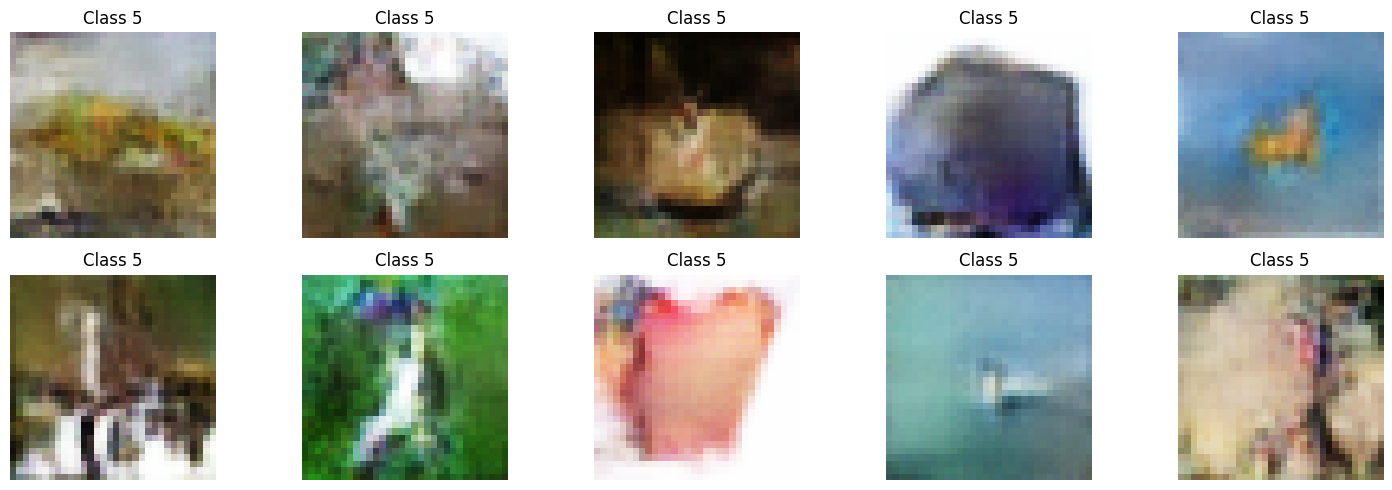

In [11]:

latent_dim = 100  
num_classes = 100 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator(latent_dim=latent_dim, num_classes=num_classes).to(device)
G.load_state_dict(torch.load('last_generator.pth'))
G.eval()
def generate_images(class_idx, num_images=10):
    z = torch.randn(num_images, latent_dim, device=device)
    labels = torch.full((num_images,), class_idx, dtype=torch.long, device=device)
    with torch.no_grad():
        fake_images = G(z, labels)
    
    return fake_images

target_class = 5  
fake_images = generate_images(target_class, 10)

fake_images = fake_images.cpu()
fake_images = (fake_images + 1) / 2  # Из диапазона [-1, 1] в [0, 1]
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = fake_images[i].permute(1, 2, 0).numpy()  # Из (C, H, W) в (H, W, C)
    plt.imshow(img)
    plt.title(f"Class {target_class}")
    plt.axis('off')
plt.tight_layout()
plt.show()

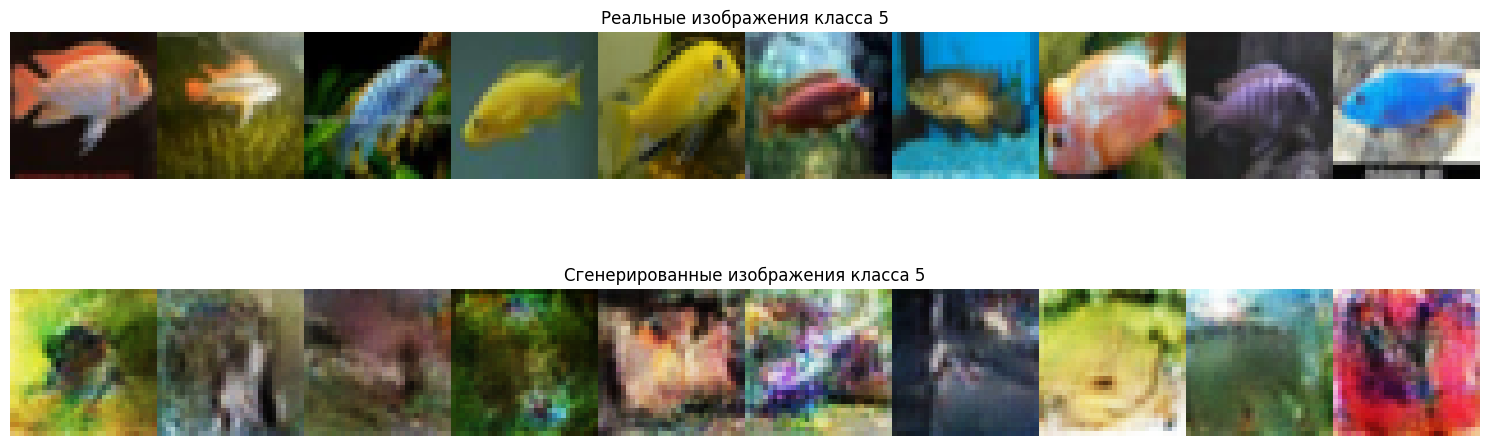

In [12]:

latent_dim = 100  
num_classes = 100 
batch_size = 10  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator(latent_dim=latent_dim, num_classes=num_classes).to(device)
G.load_state_dict(torch.load('last_generator.pth'))
G.eval()

dataset = MultiClassImageDataset("train") 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def get_real_images(class_idx, num_images=10):
    real_images = []
    for images, labels in dataloader:
        indices = (labels == class_idx).nonzero().squeeze()
        if indices.numel() > 0:
            if indices.numel() == 1:
                real_images.append(images[indices.item()])
            else:
                real_images.extend(images[i] for i in indices)
        if len(real_images) >= num_images:
            break
    return torch.stack(real_images[:num_images]).to(device)

def generate_images(class_idx, num_images=10):
    z = torch.randn(num_images, latent_dim, device=device)
    labels = torch.full((num_images,), class_idx, dtype=torch.long, device=device)
    with torch.no_grad():
        fake_images = G(z, labels)
    return fake_images
target_class = 5
real_images = get_real_images(target_class, batch_size)
fake_images = generate_images(target_class, batch_size)

def prepare_images(images):
    images = images.cpu()
    images = (images + 1) / 2  # Из [-1, 1] в [0, 1]
    return images.permute(0, 2, 3, 1).numpy()  # Из (N, C, H, W) в (N, H, W, C)

real_images_prepared = prepare_images(real_images)
fake_images_prepared = prepare_images(fake_images)
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.title(f"Реальные изображения класса {target_class}")
plt.imshow(np.concatenate([real_images_prepared[i] for i in range(batch_size)], axis=1))
plt.axis('off')

plt.subplot(2, 1, 2)
plt.title(f"Сгенерированные изображения класса {target_class}")
plt.imshow(np.concatenate([fake_images_prepared[i] for i in range(batch_size)], axis=1))
plt.axis('off')

plt.tight_layout()
plt.show()

# for i in range(batch_size):
#     save_image(real_images[i], f'real_class_{target_class}_{i}.png')
#     save_image(fake_images[i], f'generated_class_{target_class}_{i}.png')

Добавляем сгенерированные картинки в датасет, но только в те классы, где изображений меньше 70

In [42]:
# Параметры модели
latent_dim = 100
num_classes = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка генератора
G = Generator(latent_dim=latent_dim, num_classes=num_classes).to(device)
G.load_state_dict(torch.load('last_generator.pth'))
G.eval()

def find_classes_needing_augmentation(train_dir, min_samples=70):
    classes_to_augment = {}
    for class_name in os.listdir(train_dir):
        class_dir = os.path.join(train_dir, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
            if count < min_samples:
                classes_to_augment[class_name] = count
    return classes_to_augment

def generate_class_images(class_name, class_idx, num_to_generate=20):
    class_dir = os.path.join("train_edsr", class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    # Генерация изображений
    z = torch.randn(num_to_generate, latent_dim, device=device)
    labels = torch.full((num_to_generate,), class_idx, device=device)
    
    with torch.no_grad():
        generated_images = G(z, labels)
    
    # Сохранение с новыми именами
    for i in range(num_to_generate):
        img_name = f"gener_{class_idx}_{i+1}.png"
        img_path = os.path.join(class_dir, img_name)
        
        # Сохраняем через PIL для лучшего контроля качества
        img = generated_images[i].cpu()
        img = (img + 1) / 2  # Денормализация из [-1,1] в [0,1]
        img = img.clamp(0, 1)  # Гарантируем корректный диапазон
        
        save_image(img, img_path)

def main():
    train_dir = "train"
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Директория {train_dir} не найдена!")
    
    # Создаем mapping имен классов к индексам
    dataset = ImageFolder(train_dir)
    class_to_idx = dataset.class_to_idx
    
    # Находим классы для аугментации
    classes_to_augment = find_classes_needing_augmentation(train_dir)
    
    # Генерируем для каждого класса
    for class_name, current_count in classes_to_augment.items():
        class_idx = class_to_idx[class_name]
        
        generate_class_images(class_name, class_idx)

if __name__ == "__main__":
    main()

Класс: 18 (индекс 10), текущее количество: 67
Класс: 23 (индекс 16), текущее количество: 52
Класс: 26 (индекс 19), текущее количество: 64
Класс: 33 (индекс 27), текущее количество: 66
Класс: 43 (индекс 38), текущее количество: 54
Класс: 5 (индекс 45), текущее количество: 65
Класс: 60 (индекс 57), текущее количество: 57
Класс: 69 (индекс 66), текущее количество: 64
Класс: 70 (индекс 68), текущее количество: 58
Класс: 71 (индекс 69), текущее количество: 68
Класс: 76 (индекс 74), текущее количество: 68
Класс: 77 (индекс 75), текущее количество: 64
Класс: 8 (индекс 78), текущее количество: 65
Класс: 81 (индекс 80), текущее количество: 68
Класс: 9 (индекс 89), текущее количество: 69
Класс: 90 (индекс 90), текущее количество: 54
Класс: 97 (индекс 97), текущее количество: 60


Удаление из датасета сгенерированных изображений

In [45]:
# import os
# import glob

# def delete_generated_images(root_dir="train"):
#     deleted_count = 0
    
#     # Проходим по всем подпапкам
#     for class_dir in glob.glob(os.path.join(root_dir, "*")):
#         if os.path.isdir(class_dir):
#             # Находим все сгенерированные файлы
#             generated_files = glob.glob(os.path.join(class_dir, "gener_*.png"))
            
#             # Удаляем каждый файл
#             for file_path in generated_files:
#                 try:
#                     os.remove(file_path)
#                     print(f"Удалено: {file_path}")
#                     deleted_count += 1
#                 except Exception as e:
#                     print(f"Ошибка при удалении {file_path}: {e}")
# delete_generated_images(train_dir)

Начинаю удаление сгенерированных изображений...
Удалено: train_edsr/5/gener_45_1.png
Удалено: train_edsr/5/gener_45_2.png
Удалено: train_edsr/5/gener_45_3.png
Удалено: train_edsr/5/gener_45_4.png
Удалено: train_edsr/5/gener_45_5.png
Удалено: train_edsr/5/gener_45_6.png
Удалено: train_edsr/5/gener_45_7.png
Удалено: train_edsr/5/gener_45_8.png
Удалено: train_edsr/5/gener_45_9.png
Удалено: train_edsr/5/gener_45_10.png
Удалено: train_edsr/5/gener_45_11.png
Удалено: train_edsr/5/gener_45_12.png
Удалено: train_edsr/5/gener_45_13.png
Удалено: train_edsr/5/gener_45_14.png
Удалено: train_edsr/5/gener_45_15.png
Удалено: train_edsr/5/gener_45_16.png
Удалено: train_edsr/5/gener_45_17.png
Удалено: train_edsr/5/gener_45_18.png
Удалено: train_edsr/5/gener_45_19.png
Удалено: train_edsr/5/gener_45_20.png
Удалено: train_edsr/8/gener_78_1.png
Удалено: train_edsr/8/gener_78_2.png
Удалено: train_edsr/8/gener_78_3.png
Удалено: train_edsr/8/gener_78_4.png
Удалено: train_edsr/8/gener_78_5.png
Удалено: train_e

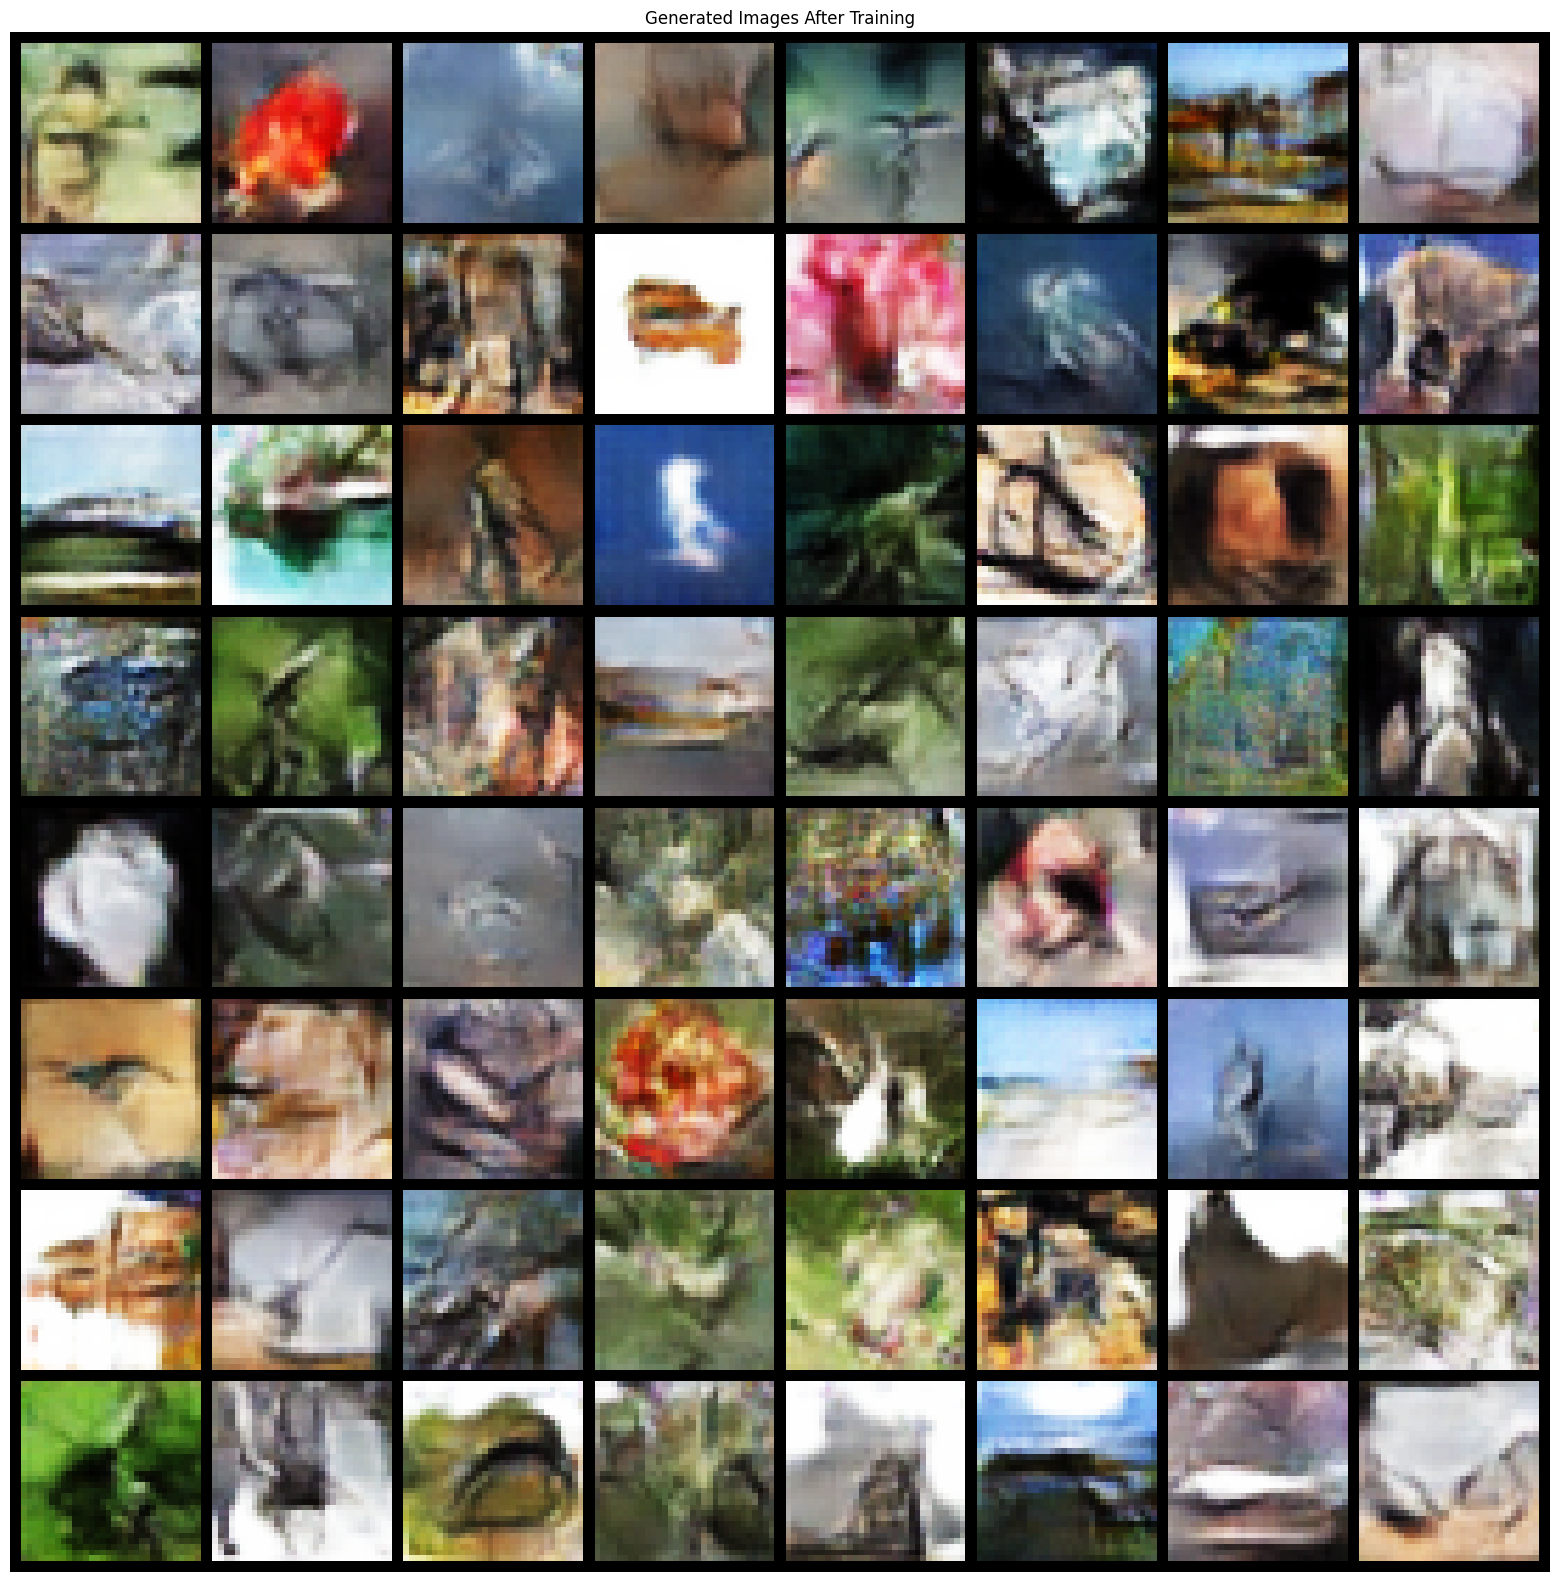

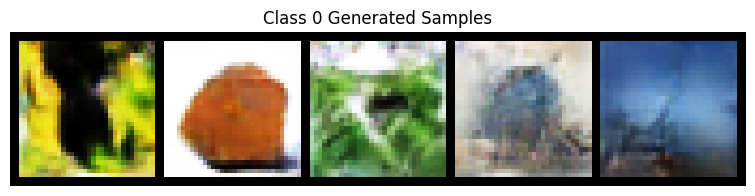

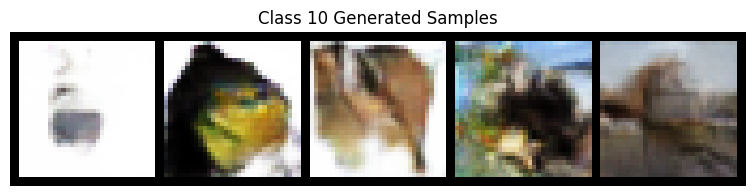

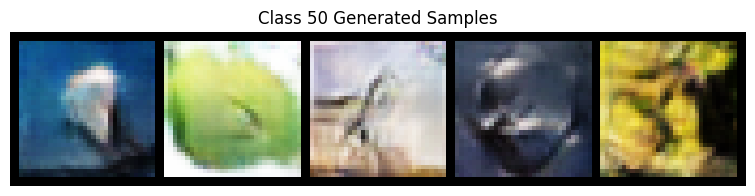

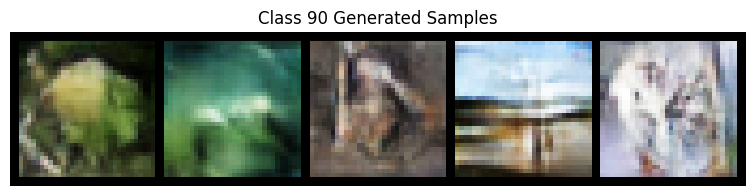

In [3]:

num_images = 64
fixed_noise = torch.randn(num_images, latent_dim, device=device)
fixed_labels = torch.arange(0, num_classes, device=device).repeat(num_images // num_classes + 1)[:num_images]

with torch.no_grad():
    G.eval() 
    fake_images = G(fixed_noise, fixed_labels).detach().cpu()
grid = vutils.make_grid(fake_images, nrow=8, normalize=True, padding=2)

# 4. Визуализация
plt.figure(figsize=(20, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.title('Generated Images After Training')
plt.show()

# 5. Сохранение в файл
plt.savefig('generated_images_final.png')
plt.close()

selected_classes = [0, 10, 50, 90] 
num_per_class = 5

for class_idx in selected_classes:
    class_noise = torch.randn(num_per_class, latent_dim, device=device)
    class_labels = torch.full((num_per_class,), class_idx, device=device, dtype=torch.long)
    
    with torch.no_grad():
        class_images = G(class_noise, class_labels).detach().cpu()
    
    # Визуализация
    grid = vutils.make_grid(class_images, nrow=num_per_class, normalize=True)
    plt.figure(figsize=(10, 2))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    plt.title(f'Class {class_idx} Generated Samples')
    plt.show()
    plt.close()

In [33]:
class CustomMultiClassLoss(nn.Module):
    def __init__(self):
        super(CustomMultiClassLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        loss = self.ce(outputs, targets)
        penalty = 0.001 * torch.mean(torch.sum(outputs**2, dim=1))
        return loss + penalty
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, val_metric, model):
        score = -val_metric  # Assuming lower loss is better
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0
def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs:
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self, filenames, aug=None):
    self.filenames = filenames
    self.aug = aug

  def __getitem__(self, idx):
    img = cv2.cvtColor(cv2.imread(self.filenames[idx]), cv2.COLOR_BGR2RGB)
    label = self.filenames[idx].split('/')[-2]
    if self.aug:
      img = self.aug(image=img)['image']
    label = torch.tensor(int(label))
    return img, label

  def __len__(self):
    return len(self.filenames)

**wide_resnet50_2**

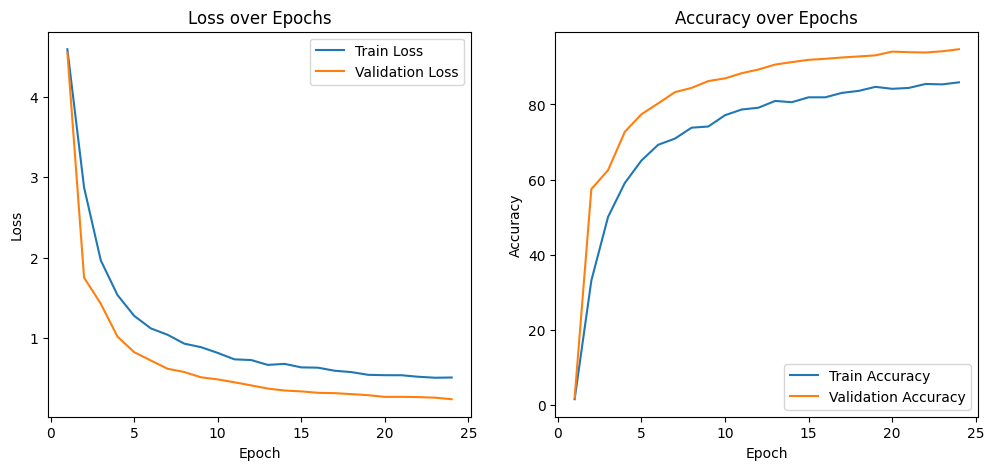

100%|██████████| 24/24 [38:35<00:00, 96.49s/it]

Epoch 24/24 | LR: 0.000730 | Train Loss: 0.5120, Train Acc: 85.88% | Val Loss: 0.2423, Val Acc: 94.69%


In [53]:
filenames = glob.glob(os.path.join('train_edsr') + "/**/*.png", recursive=True)
model = models.wide_resnet50_2(weights=models.Wide_ResNet50_2_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False
num_classes = 100
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(model.fc.in_features, num_classes) 
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Модель готова, устройство: {device}")
aug_upscale_plus = A.Compose(
    [
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 24
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_Wide_ResNet50_2_Weights.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
# best_model_efficient_L_gener_2.pth.csv

Как и ожидалась, генерация только усугубила положение. Дальше ее не спользуем, я удалила из датасета картинки сгенерированные.
Хоть на трейне все неплохо, а на валидации вообще улет, на тесте 0.52 и 0.26

**efficientnet_b4**

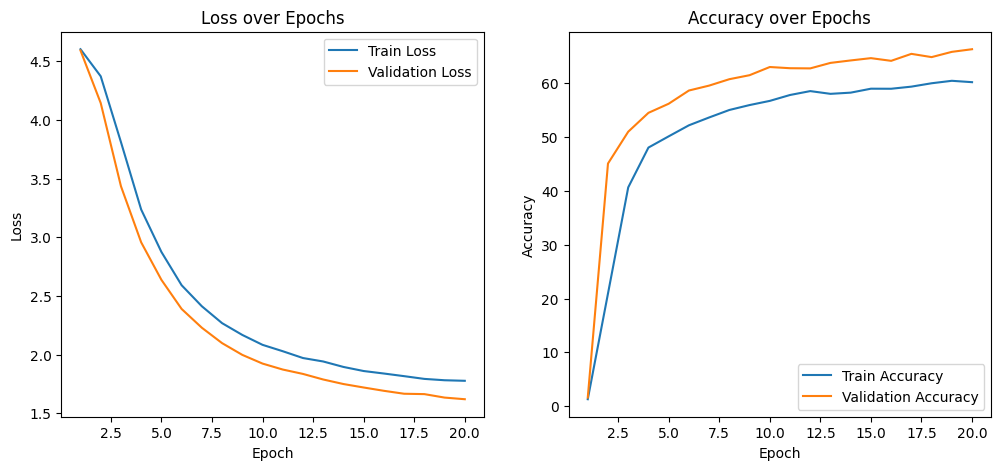

100%|██████████| 20/20 [26:20<00:00, 79.03s/it]

Epoch 20/20 | LR: 0.000112 | Train Loss: 1.7774, Train Acc: 60.22% | Val Loss: 1.6205, Val Acc: 66.35%


In [58]:
filenames = glob.glob(os.path.join('train_edsr') + "/**/*.png", recursive=True)

model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
num_classes = 100
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True), 
    nn.Linear(model.classifier[1].in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Модель готова {device}")
aug_upscale_plus = A.Compose(
    [
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.001
num_epochs = 20
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_wide_resnet50_2.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
        
# best_model_wide_resnet50_2.csv

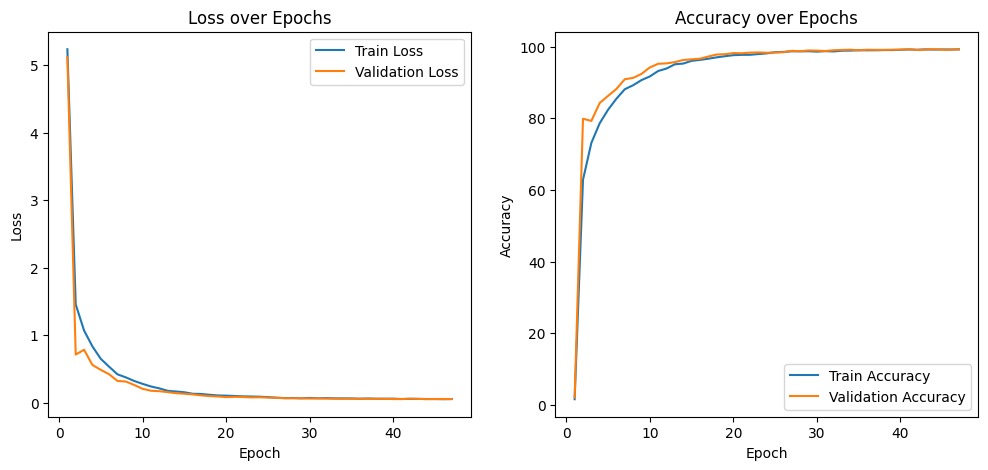

 92%|█████████▏| 46/50 [48:41<04:14, 63.51s/it]

Epoch 47/50 | LR: 0.000065 | Train Loss: 0.0544, Train Acc: 99.24% | Val Loss: 0.0535, Val Acc: 99.23%
EarlyStopping counter: 3 out of 3
No improvement in validation loss. Switching loss function to custom multiclass loss.
EarlyStopping counter: 3 out of 3
No improvement after loss switch. Switching optimizer to Adam.


NameError: name 'AdamW' is not defined

In [72]:
filenames = glob.glob(os.path.join('train_edsr') + "/**/*.png", recursive=True)
model = timm.create_model('vit_small_patch16_224', pretrained=True)
num_classes = 100
if hasattr(model, 'head'):
    model.head = nn.Linear(model.head.in_features, num_classes)
else:
    model.reset_classifier(num_classes)  # Автоматическая замена головы

for param in model.parameters():
    param.requires_grad = False
for param in model.get_classifier().parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Модель готова, устройство: {device}")
aug_upscale_plus = A.Compose(
    [
      #A.SmallestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC),
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 50
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_vit_s_patch16_224.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
# best_model_vit_small_patch16_224.csv

In [6]:
# pip install timm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip


Пробуем convnext_tiny без edsr

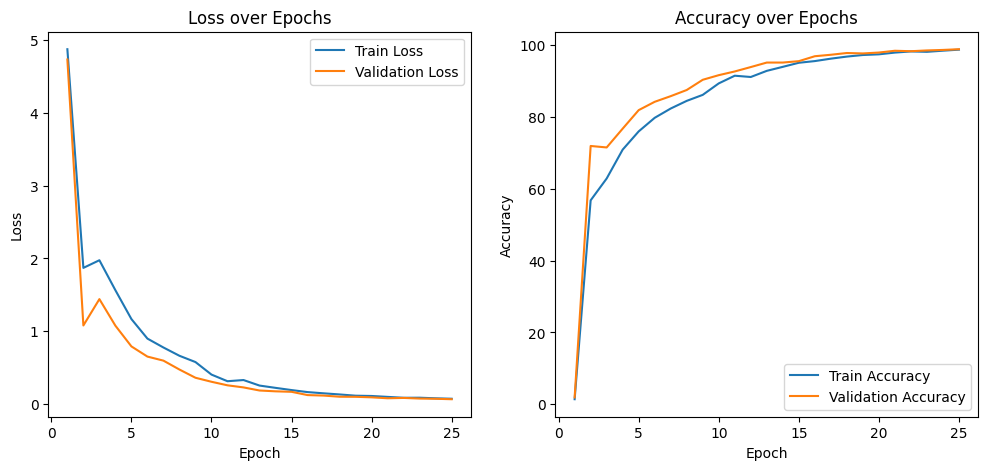

Epoch 25/25 | LR: 0.000657 | Train Loss: 0.0710, Train Acc: 98.72% | Val Loss: 0.0644, Val Acc: 98.84%


100%|██████████| 25/25 [31:24<00:00, 75.39s/it]


In [16]:
filenames = glob.glob(os.path.join('train') + "/**/*.png", recursive=True)
model = timm.create_model('convnext_tiny', pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_classes = 100
model.reset_classifier(num_classes)  

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Модель готова, устройство: {device}")
aug_upscale_plus = A.Compose(
    [
      #A.SmallestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC),
      A.Resize(256, 256),
      A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 25
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_convnext_tiny2.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
# best_model_convnext_tiny2.csv

**Лучший скор пока** 0.75364

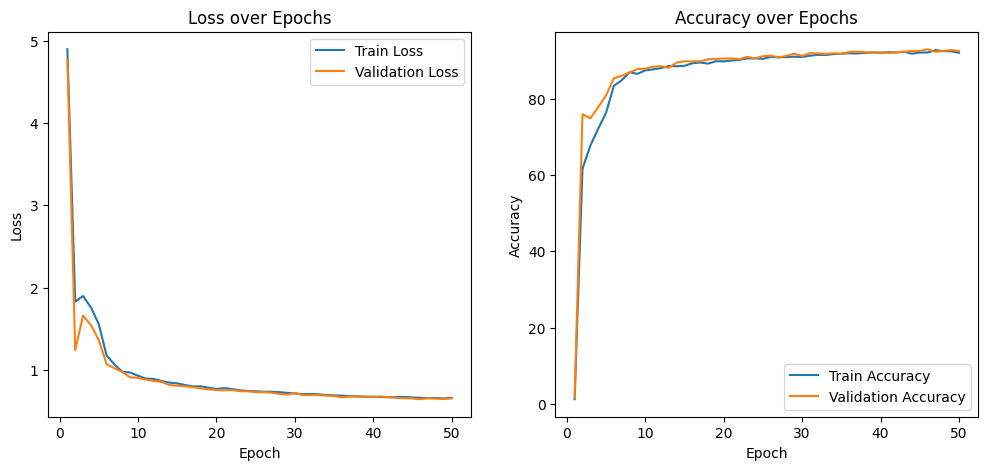

100%|██████████| 50/50 [1:17:35<00:00, 93.10s/it]

Epoch 50/50 | LR: 0.000100 | Train Loss: 0.6651, Train Acc: 92.00% | Val Loss: 0.6588, Val Acc: 92.47%
EarlyStopping counter: 4 out of 3
EarlyStopping counter: 4 out of 3


In [42]:
model = timm.create_model('convnext_tiny', pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_classes = 100
for i, (name, param) in enumerate(model.named_parameters()):
    if i < 100:  # Например, заморозить первые 100 слоев
        param.requires_grad = False
        model.reset_classifier(num_classes)  
def pixel_dropout(image, drop_prob=0.01, **kwargs):
    if drop_prob <= 0:
        return image
    
    h, w = image.shape[:2]
    mask = np.random.random((h, w)) < drop_prob
    if image.ndim == 3:  # RGB
        mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    image[mask] = 0
    return image
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
aug_upscale_plus = A.Compose(
    [
      A.Resize(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
      A.Lambda(name="pixel_dropout", image=lambda x, **k: pixel_dropout(x, drop_prob=0.02), p=0.5),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 50
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_cconvnext_tiny_modern.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

**Лучший скор пока** - 75

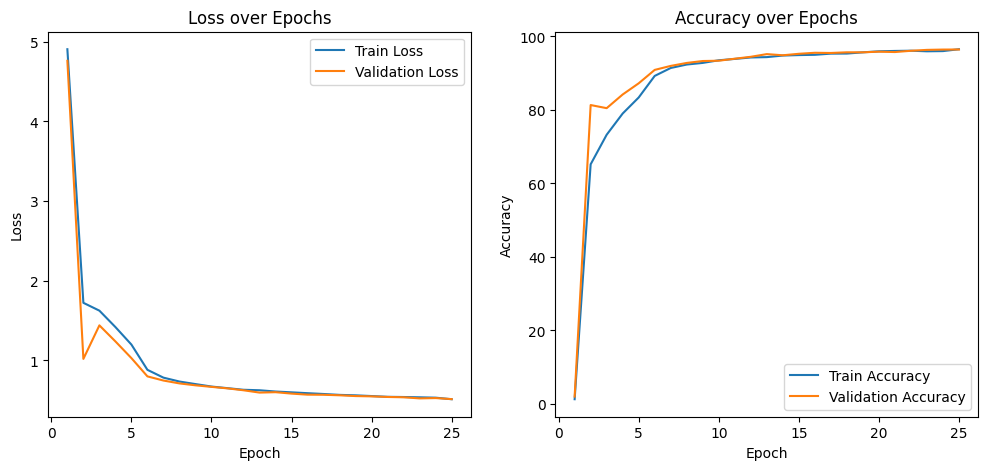

100%|██████████| 25/25 [35:29<00:00, 85.17s/it]

Epoch 25/25 | LR: 0.000100 | Train Loss: 0.5133, Train Acc: 96.53% | Val Loss: 0.5146, Val Acc: 96.46%


In [33]:
model = timm.create_model('convnext_tiny', pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_classes = 100
for i, (name, param) in enumerate(model.named_parameters()):
    if i < 100:  # Например, заморозить первые 100 слоев
        param.requires_grad = False
model.reset_classifier(num_classes)  

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
aug_upscale_plus = A.Compose(
    [
      #A.SmallestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC),
      A.Resize(224, 224),
      # A.CenterCrop(224, 224),
      A.HorizontalFlip(p=.7),
      A.VerticalFlip(p=.3),
     #  # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
     #  A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
     # #A.RandomCrop(height=16, width=16, p=.5),
     #  A.RandomBrightnessContrast(),
      # A.RandomRotate90(p = .4),
     #  A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
     #  #A.Blur(blur_limit=2, p=0.3),
     # # A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.1, 0.1)},p=.5),
     #  A.ChannelDropout(p=.3),
     #  #A.GaussNoise(var_limit=(0.001, 0.005), p=0.3),
     #  A.CoarseDropout(max_holes=1, max_height=16, max_width=16, p=0.5),
     #  A.RandomGamma(gamma_limit=(80, 120), p=0.5),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 25
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_convnext_small.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

**convnext_base**

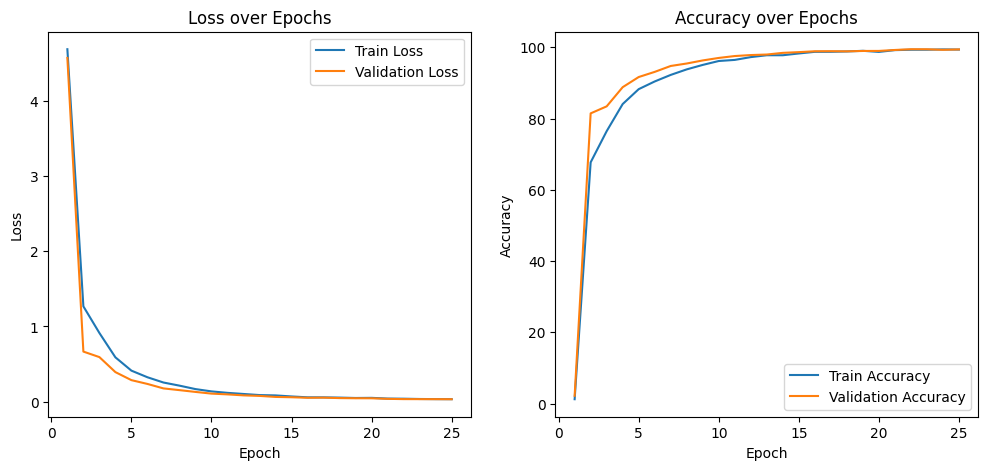

100%|██████████| 25/25 [1:16:44<00:00, 184.17s/it]

Epoch 25/25 | LR: 0.000657 | Train Loss: 0.0330, Train Acc: 99.35% | Val Loss: 0.0325, Val Acc: 99.39%


In [13]:
model = timm.create_model('convnext_base', pretrained=True, num_classes=100)
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
aug_upscale_plus = A.Compose(
    [
      A.Resize(224, 224),
      A.HorizontalFlip(p=.5),
      A.VerticalFlip(p=.5),
      A.PixelDropout(p=.3),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 25
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_convnext_base.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
# best_model_convnext_base.csv

In [ ]:
# pip install transformers

**convnext_large**

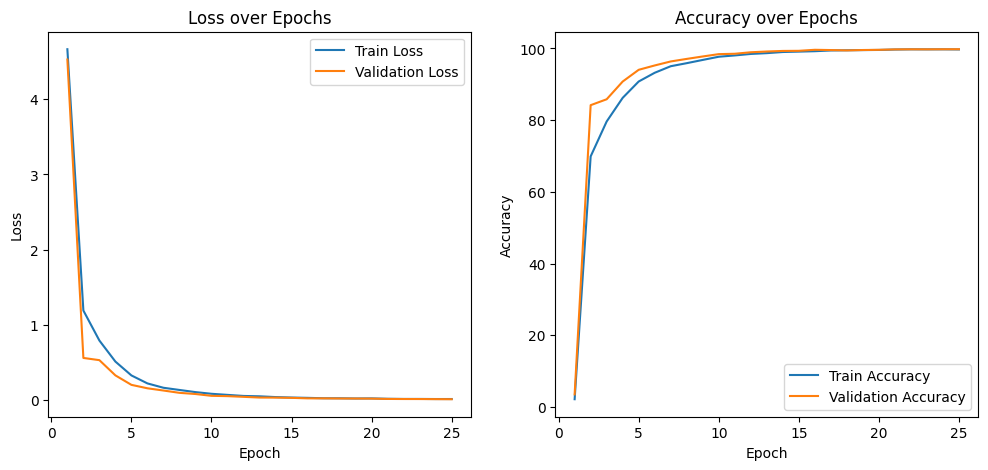

100%|██████████| 25/25 [2:09:46<00:00, 311.46s/it]

Epoch 25/25 | LR: 0.000657 | Train Loss: 0.0166, Train Acc: 99.73% | Val Loss: 0.0139, Val Acc: 99.80%


In [17]:
import timm
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

model = timm.create_model('convnext_large', pretrained=True, num_classes=100)
for param in model.parameters():
    param.requires_grad = False
if hasattr(model, 'head'):
    for param in model.head.parameters():
        param.requires_grad = True
elif hasattr(model, 'classifier'):
    for param in model.classifier.parameters():
        param.requires_grad = True
else:
    raise AttributeError("Не найден головной слой (head/classifier)")

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
aug_upscale_plus = A.Compose(
    [
      A.Resize(224, 224),
      A.HorizontalFlip(p=.5),
      A.VerticalFlip(p=.5),
      A.PixelDropout(p=.3),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 25
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_convnext_large.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  # Reset counter.

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
# best_model_convnext_large.csv

**Модель ViT-Base/16**

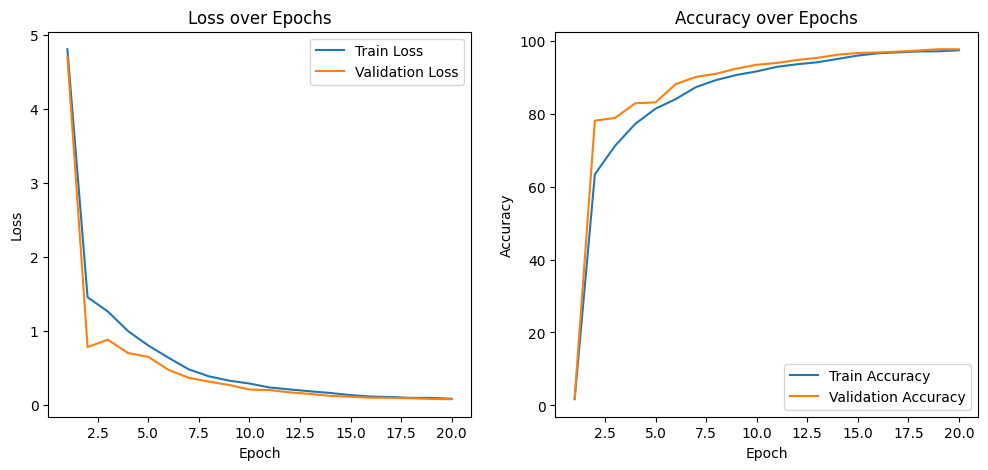

100%|██████████| 20/20 [55:41<00:00, 167.05s/it]

Epoch 20/20 | LR: 0.001112 | Train Loss: 0.0890, Train Acc: 97.34% | Val Loss: 0.0831, Val Acc: 97.63%


In [9]:
filenames = glob.glob(os.path.join('train_edsr') + "/**/*.png", recursive=True)
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=100)
num_classes = 100
for name, param in model.named_parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001,
    weight_decay=0.01
)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
aug_upscale_plus = A.Compose(
    [
      A.Resize(224, 224),
      A.HorizontalFlip(p=.5),
      A.VerticalFlip(p=.5),
      A.PixelDropout(p=.3),
      A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
      ToTensorV2()
    ]
  )
dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)
base_lr = 0.01
num_epochs = 20
warmup_epochs = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_vit_base_patch16_224.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)  

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

0.75208 на тесте 


**улучшаем лучшую модель с помощью чата**

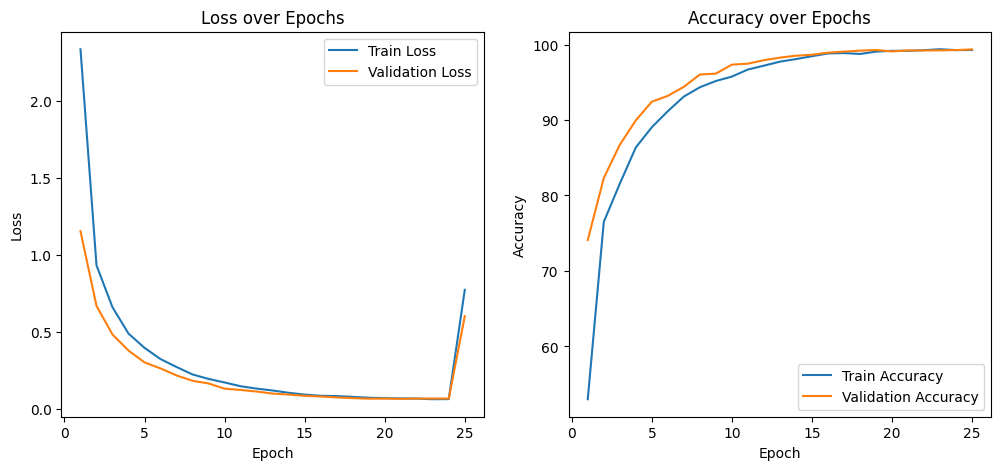

100%|██████████| 25/25 [2:10:04<00:00, 312.16s/it]

Epoch 25/25 | LR: 0.000100 | Train Loss: 0.7724, Train Acc: 99.28% | Val Loss: 0.6007, Val Acc: 99.36%


In [25]:
model = timm.create_model('convnext_large', pretrained=True, num_classes=100)
for param in model.parameters():
    param.requires_grad = False
if hasattr(model, 'head'):
    for param in model.head.parameters():
        param.requires_grad = True
elif hasattr(model, 'classifier'):
    for param in model.classifier.parameters():
        param.requires_grad = True
else:
    raise AttributeError("Не найден головной слой (head/classifier)")
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=0.001,                   
    weight_decay=0.05,           
    betas=(0.9, 0.999),          
    eps=1e-8                    
)

num_epochs = 25
warmup_epochs = 3

warmup_scheduler = LinearLR(
    optimizer,
    start_factor=1e-5,           
    end_factor=1.0,            
    total_iters=warmup_epochs
)

cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=num_epochs - warmup_epochs, 
    eta_min=1e-6                      
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

aug_upscale_plus = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.PixelDropout(p=.3),
    A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507, 0.25536751, 0.27503409)),
    ToTensorV2()
])

dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        cosine_scheduler.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_convnext_large_2.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

0.84 - пока самый высокий скор

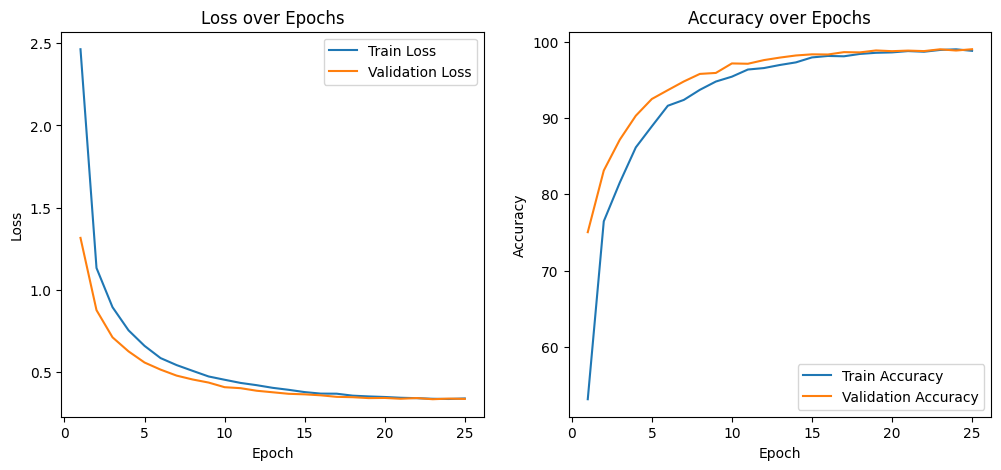

100%|██████████| 25/25 [2:08:02<00:00, 307.32s/it]

Epoch 25/25 | LR: 0.000001 | Train Loss: 0.3385, Train Acc: 98.79% | Val Loss: 0.3358, Val Acc: 99.00%
EarlyStopping counter: 2 out of 3
EarlyStopping counter: 2 out of 3


In [27]:
import timm
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR
from torch.utils.data import DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
filenames = glob.glob(os.path.join('train_edsr') + "/**/*.png", recursive=True)
# Инициализация модели (оставляем без изменений)
model = timm.create_model('convnext_large', pretrained=True, num_classes=100)
for param in model.parameters():
    param.requires_grad = False
if hasattr(model, 'head'):
    for param in model.head.parameters():
        param.requires_grad = True
elif hasattr(model, 'classifier'):
    for param in model.classifier.parameters():
        param.requires_grad = True
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),  
    lr=0.001,                   
    weight_decay=0.05,           
    betas=(0.9, 0.999),          
    eps=1e-8                     
)
num_epochs = 25
warmup_epochs = 3

warmup_scheduler = LinearLR(
    optimizer,
    start_factor=1e-5,           
    end_factor=1.0,             
    total_iters=warmup_epochs
)

cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=num_epochs - warmup_epochs,  
    eta_min=1e-6                     
)

# Перенос модели на устройство (без изменений)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Остальной код остается без изменений:
aug_upscale_plus = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.PixelDropout(p=.3),
    A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507, 0.25536751, 0.27503409)),
    ToTensorV2()
])

dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        cosine_scheduler.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_convnext_large_3.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

0.84166 - на тесте

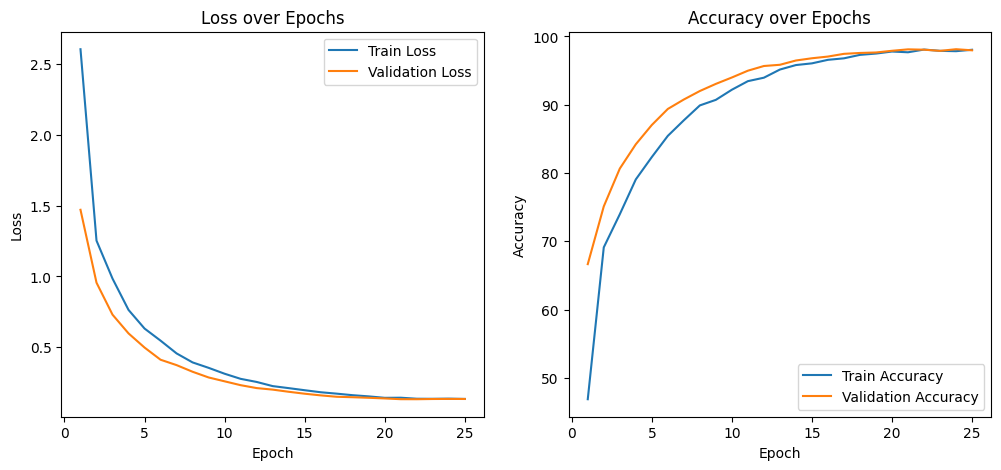

 96%|█████████▌| 24/25 [2:12:37<05:31, 331.56s/it]

Epoch 25/25 | LR: 0.000001 | Train Loss: 0.1338, Train Acc: 98.05% | Val Loss: 0.1335, Val Acc: 97.97%
EarlyStopping counter: 3 out of 3
No improvement in validation loss. Switching loss function to custom multiclass loss.
EarlyStopping counter: 3 out of 3
No improvement after loss switch. Switching optimizer to Adam.


NameError: name 'AdamW' is not defined

In [4]:
filenames = glob.glob(os.path.join('train') + "/**/*.png", recursive=True)
criterion = nn.CrossEntropyLoss()
model = timm.create_model('convnext_large', pretrained=True, num_classes=100)
for param in model.parameters():
    param.requires_grad = False
if hasattr(model, 'head'):
    for param in model.head.parameters():
        param.requires_grad = True
elif hasattr(model, 'classifier'):
    for param in model.classifier.parameters():
        param.requires_grad = True
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),  
    lr=0.001,                    
    weight_decay=0.05,          
    betas=(0.9, 0.999),          
    eps=1e-8                     
)
num_epochs = 25
warmup_epochs = 3

warmup_scheduler = LinearLR(
    optimizer,
    start_factor=1e-5,          
    end_factor=1.0,              
    total_iters=warmup_epochs
)

cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=num_epochs - warmup_epochs,  
    eta_min=1e-6                       
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

aug_upscale_plus = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.PixelDropout(p=.3),
    A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507, 0.25536751, 0.27503409)),
    ToTensorV2()
])

dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Обновление learning rate (новая логика)
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        cosine_scheduler.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_convnext_large_4.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

0.81666- на тесте (без edsr)

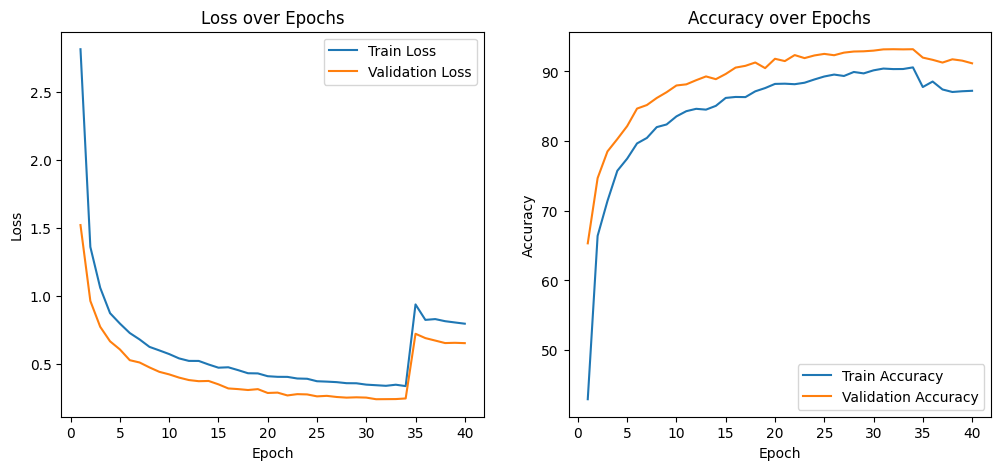

100%|██████████| 40/40 [3:39:33<00:00, 329.34s/it]

Epoch 40/40 | LR: 0.001000 | Train Loss: 0.7944, Train Acc: 87.22% | Val Loss: 0.6512, Val Acc: 91.16%


In [10]:
filenames = glob.glob(os.path.join('train_edsr') + "/**/*.png", recursive=True)
criterion = nn.CrossEntropyLoss()
model = timm.create_model(
    'convnext_large',
    pretrained=True,
    num_classes=100,
    drop_path_rate=0.2  # Stochastic Depth для регуляризации
)
for param in model.parameters():
    param.requires_grad = False
if hasattr(model, 'head'):
    for param in model.head.parameters():
        param.requires_grad = True
elif hasattr(model, 'classifier'):
    for param in model.classifier.parameters():
        param.requires_grad = True
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),  # Только размороженные параметры
    lr=0.001,                    # Базовый learning rate
    weight_decay=0.05,           # Оптимально для ConvNeXt
    betas=(0.9, 0.999),          # Стандартные beta параметры
    eps=1e-8                     # Для численной стабильности
)

# Новый шедулер (Cosine с Warmup)
num_epochs = 40
warmup_epochs = 3

# Warmup шедулер
warmup_scheduler = LinearLR(
    optimizer,
    start_factor=1e-5,          
    end_factor=1.0,              
    total_iters=warmup_epochs
)

# Основной cosine шедулер
cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=num_epochs - warmup_epochs,  # Продолжительность cosine расписания
    eta_min=1e-6                       # Минимальный learning rate
)

# Перенос модели на устройство (без изменений)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Остальной код остается без изменений:
aug_upscale_plus = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.PixelDropout(p=.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.Perspective(scale=(0.05, 0.1), p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507, 0.25536751, 0.27503409)),
    ToTensorV2()
])

dataset_advanced_densnet_upscale_plus = MyDataset(filenames, aug_upscale_plus)
train_size = int(.8 * len(dataset_advanced_densnet_upscale_plus))
val_size = len(dataset_advanced_densnet_upscale_plus) - train_size
train_dataset_upscale, val_dataset_upscale = random_split(dataset_advanced_densnet_upscale_plus, [train_size, val_size])
train_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=True)
val_loader_upscale = DataLoader(dataset_advanced_densnet_upscale_plus, batch_size=64, shuffle=False)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
loss_switched = False
optimizer_switched = False
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_acc = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Обновление learning rate (новая логика)
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        cosine_scheduler.step()

    for inputs, targets in train_loader_upscale:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader_upscale.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_upscale:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss = running_val_loss / len(val_loader_upscale.dataset)
    val_acc = 100. * correct / total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'best_model_convnext_large_5.pth')
        print(f'Best Val Acc: {best_val_acc:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

0.84270 - на тесте

 **САМАЯ ЛУЧШАЯ МОДЕЛЬ**

Нужно запустить все, что ниже

In [9]:
class CustomMultiClassLoss(nn.Module):
    def __init__(self):
        super(CustomMultiClassLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        loss = self.ce(outputs, targets)
        penalty = 0.001 * torch.mean(torch.sum(outputs**2, dim=1))
        return loss + penalty
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, val_metric, model):
        score = -val_metric  # Assuming lower loss is better
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0
def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs:
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self, filenames, aug=None):
    self.filenames = filenames
    self.aug = aug

  def __getitem__(self, idx):
    img = cv2.cvtColor(cv2.imread(self.filenames[idx]), cv2.COLOR_BGR2RGB)
    label = self.filenames[idx].split('/')[-2]
    if self.aug:
      img = self.aug(image=img)['image']
    label = torch.tensor(int(label))
    return img, label

  def __len__(self):
    return len(self.filenames)

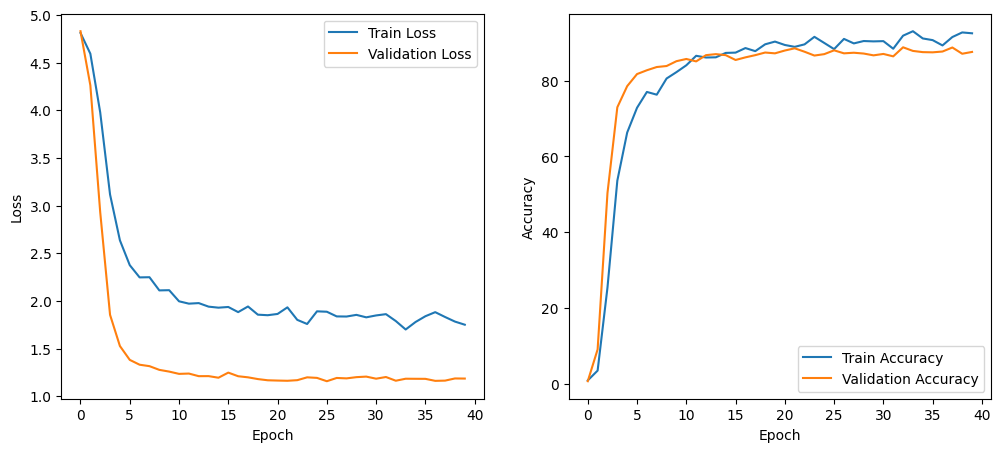

Epoch 40/40 | LR: 7.81e-07 | Train Loss: 1.7501 | Val Loss: 1.1851 | Train Acc: 92.53% | Val Acc: 87.61%


In [5]:
# 1. Инициализация MixUp
mixup_fn = Mixup(
    mixup_alpha=0.8,
    cutmix_alpha=1.0,
    prob=0.5,
    switch_prob=0.5,
    label_smoothing=0.1,
    num_classes=100
)

# 2. Модель
model = timm.create_model(
    'convnext_large',
    pretrained=True,
    num_classes=100,
    drop_path_rate=0.2
)

# 3. Разморозка слоев
for param in model.parameters():
    param.requires_grad = False

for layer in [model.stages[-1], model.stages[-2]]:
    for param in layer.parameters():
        param.requires_grad = True

if hasattr(model, 'head'):
    for param in model.head.parameters():
        param.requires_grad = True
elif hasattr(model, 'classifier'):
    for param in model.classifier.parameters():
        param.requires_grad = True

# 4. Оптимизатор
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
    weight_decay=0.05,
    betas=(0.9, 0.999),
    eps=1e-8
)

# 5. Шедулеры
num_epochs = 40
warmup_epochs = 5

warmup_scheduler = LinearLR(
    optimizer,
    start_factor=1e-5,
    end_factor=1.0,
    total_iters=warmup_epochs
)

reduce_lr_scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    verbose=True
)

# 6. Устройство и mixed precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
scaler = torch.cuda.amp.GradScaler()

# 7. Аугментации
aug_upscale_plus = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.PixelDropout(p=.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.Perspective(scale=(0.05, 0.1), p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507, 0.25536751, 0.27503409)),
    ToTensorV2()
])

# 8. Загрузка данных
filenames = glob.glob(os.path.join('train_edsr') + "/**/*.png", recursive=True)
dataset = MyDataset(filenames, aug_upscale_plus)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True  # Для MixUp
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
)

# 9. Loss функция
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# 10. Training loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Применяем MixUp 
        inputs, targets = mixup_fn(inputs, targets)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Метрики
        _, original_targets = targets.max(1) if len(targets.shape) > 1 else (None, targets)
        _, predicted = outputs.max(1)
        total += original_targets.size(0)
        correct += predicted.eq(original_targets).sum().item()
        running_loss += loss.item() * inputs.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total
    
    # Validation
    model.eval()
    running_val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
    
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = 100. * val_correct / val_total
    
    # Обновление шедулеров
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        reduce_lr_scheduler.step(val_acc)
    
    # Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_convnext_large_FINAL.pth')
        print(f'New best val acc: {best_val_acc:.2f}%')
    
    # Визуализация
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    clear_output(wait=True)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.2e} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = timm.create_model('convnext_large', pretrained=True, num_classes=100)
for param in model.parameters():
    param.requires_grad = False
if hasattr(model, 'head'):
    for param in model.head.parameters():
        param.requires_grad = True
elif hasattr(model, 'classifier'):
    for param in model.classifier.parameters():
        param.requires_grad = True
try:
    model.load_state_dict(torch.load('best_model_convnext_large_FINAL.pth', map_location=device))
except TypeError:
    full_model = torch.load('best_model_convnext_large_FINAL.pth', map_location=device)
    model.load_state_dict(full_model.state_dict())
model.to(device)
model.eval()
test_transform = A.Compose([
    A.Resize(224, 224),
    # A.CenterCrop(224, 224),
    A.Normalize((0.50691125, 0.48691937, 0.44028778), (0.2668507,  0.25536751, 0.27503409)),
    ToTensorV2()
])
test_dir = './test_edsr'
test_files = sorted([f for f in os.listdir(test_dir) if f.lower().endswith(('.png'))])
def predict_image(model, image_path, transform):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = transform(image=image)
    image_tensor = transformed['image'].unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
    return preds.item()
predictions = []
for filename in tqdm(test_files, desc="Обработка изображений"):
    try:
        img_path = os.path.join(test_dir, filename)
        file_id = os.path.splitext(filename)[0]
        class_id = predict_image(model, img_path, test_transform)
        predictions.append({'id': file_id, 'target': class_id})
    except Exception as e:
        print(f"Ошибка при обработке {filename}: {str(e)}")
        predictions.append({'id': os.path.splitext(filename)[0], 'target': -1})
results_df = pd.DataFrame(predictions)
results_df['id_num'] = results_df['id'].str.extract('(\d+)').astype(int)  
results_df = results_df.sort_values('id_num')
results_df = results_df.drop('id_num', axis=1)
results_df = results_df.reset_index(drop=True)
results_df.to_csv('best_model_convnext_large_FINAL.csv', index=False)
print(results_df.head(7))

Обработка изображений: 100%|██████████| 3878/3878 [01:13<00:00, 52.82it/s]


  id  target
0  0      71
1  1      62
2  2      18
3  3      41
4  4      66
5  5      59
6  6      12
